## ARIMA Baseline

### Nieuwe arima die elke listing apart bekijkt


Running day-by-day individual ARIMA prediction with order (1, 1, 1)
Loading data...
Data loaded in 5.60 seconds
Train data shape: (1640389, 46), Test data shape: (55048, 46)
Converting dates...
Test set contains 7 unique dates
Processing 7864 unique listings over 7 days
Total predictions to make: ~55048
Global average price (fallback): $0.00


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]


--- Day 1/7: 2024-02-09 ---
Found 7864 listings for this day


  Processed 100/7864 listings in 25.2s, est. 1959.2s remaining
  ARIMA success rate so far: 100/100 (100.0%)


  Processed 200/7864 listings in 42.9s, est. 1644.5s remaining
  ARIMA success rate so far: 200/200 (100.0%)


  Processed 300/7864 listings in 68.5s, est. 1728.1s remaining
  ARIMA success rate so far: 300/300 (100.0%)


  Processed 400/7864 listings in 90.5s, est. 1688.0s remaining
  ARIMA success rate so far: 400/400 (100.0%)


  Processed 500/7864 listings in 101.6s, est. 1496.0s remaining
  ARIMA success rate so far: 500/500 (100.0%)


  Processed 600/7864 listings in 112.5s, est. 1362.5s remaining
  ARIMA success rate so far: 600/600 (100.0%)


  Processed 700/7864 listings in 123.2s, est. 1260.4s remaining
  ARIMA success rate so far: 700/700 (100.0%)


  Processed 800/7864 listings in 135.0s, est. 1192.4s remaining
  ARIMA success rate so far: 800/800 (100.0%)


  Processed 900/7864 listings in 152.5s, est. 1180.1s remaining
  ARIMA success rate so far: 900/900 (100.0%)


Day 1 listings:  11%|█▏        | 902/7864 [02:32<17:30,  6.63it/s]

  Processed 1000/7864 listings in 163.7s, est. 1123.5s remaining
  ARIMA success rate so far: 1000/1000 (100.0%)


  Processed 1100/7864 listings in 174.8s, est. 1074.7s remaining
  ARIMA success rate so far: 1100/1100 (100.0%)


  Processed 1200/7864 listings in 186.0s, est. 1032.9s remaining
  ARIMA success rate so far: 1200/1200 (100.0%)


  Processed 1300/7864 listings in 198.3s, est. 1001.1s remaining
  ARIMA success rate so far: 1300/1300 (100.0%)


  Processed 1400/7864 listings in 216.2s, est. 998.2s remaining
  ARIMA success rate so far: 1400/1400 (100.0%)


  Processed 1500/7864 listings in 238.6s, est. 1012.1s remaining
  ARIMA success rate so far: 1500/1500 (100.0%)


  Processed 1600/7864 listings in 263.7s, est. 1032.5s remaining
  ARIMA success rate so far: 1600/1600 (100.0%)


  Processed 1700/7864 listings in 276.5s, est. 1002.4s remaining
  ARIMA success rate so far: 1700/1700 (100.0%)


  Processed 1800/7864 listings in 287.7s, est. 969.3s remaining
  ARIMA success rate so far: 1800/1800 (100.0%)


Day 1 listings:  23%|██▎       | 1801/7864 [04:47<14:40,  6.89it/s]


  Processed 1900/7864 listings in 297.8s, est. 934.7s remaining
  ARIMA success rate so far: 1900/1900 (100.0%)


Day 1 listings:  24%|██▍       | 1903/7864 [04:57<07:36, 13.06it/s]

  Processed 2000/7864 listings in 308.1s, est. 903.3s remaining
  ARIMA success rate so far: 2000/2000 (100.0%)


  Processed 2100/7864 listings in 318.8s, est. 874.9s remaining
  ARIMA success rate so far: 2100/2100 (100.0%)


  Processed 2200/7864 listings in 330.4s, est. 850.7s remaining
  ARIMA success rate so far: 2200/2200 (100.0%)


  Processed 2300/7864 listings in 342.1s, est. 827.5s remaining
  ARIMA success rate so far: 2300/2300 (100.0%)


  Processed 2400/7864 listings in 352.9s, est. 803.4s remaining
  ARIMA success rate so far: 2400/2400 (100.0%)


  Processed 2500/7864 listings in 364.1s, est. 781.2s remaining
  ARIMA success rate so far: 2500/2500 (100.0%)


  Processed 2600/7864 listings in 374.7s, est. 758.5s remaining
  ARIMA success rate so far: 2600/2600 (100.0%)


  Processed 2700/7864 listings in 388.1s, est. 742.2s remaining
  ARIMA success rate so far: 2700/2700 (100.0%)


  Processed 2800/7864 listings in 413.7s, est. 748.1s remaining
  ARIMA success rate so far: 2800/2800 (100.0%)


  Processed 2900/7864 listings in 439.4s, est. 752.1s remaining
  ARIMA success rate so far: 2900/2900 (100.0%)


  Processed 3000/7864 listings in 455.7s, est. 738.8s remaining
  ARIMA success rate so far: 3000/3000 (100.0%)


  Processed 3100/7864 listings in 466.4s, est. 716.7s remaining
  ARIMA success rate so far: 3100/3100 (100.0%)


Day 1 listings:  39%|███▉      | 3103/7864 [07:46<06:10, 12.86it/s]

  Processed 3200/7864 listings in 475.8s, est. 693.5s remaining
  ARIMA success rate so far: 3200/3200 (100.0%)


  Processed 3300/7864 listings in 487.4s, est. 674.1s remaining
  ARIMA success rate so far: 3300/3300 (100.0%)


  Processed 3400/7864 listings in 497.7s, est. 653.4s remaining
  ARIMA success rate so far: 3400/3400 (100.0%)


  Processed 3500/7864 listings in 508.8s, est. 634.4s remaining
  ARIMA success rate so far: 3500/3500 (100.0%)


  Processed 3600/7864 listings in 519.3s, est. 615.1s remaining
  ARIMA success rate so far: 3600/3600 (100.0%)


  Processed 3700/7864 listings in 530.9s, est. 597.4s remaining
  ARIMA success rate so far: 3700/3700 (100.0%)


  Processed 3800/7864 listings in 541.6s, est. 579.2s remaining
  ARIMA success rate so far: 3800/3800 (100.0%)


  Processed 3900/7864 listings in 552.5s, est. 561.6s remaining
  ARIMA success rate so far: 3900/3900 (100.0%)


  Processed 4000/7864 listings in 562.3s, est. 543.2s remaining
  ARIMA success rate so far: 4000/4000 (100.0%)


  Processed 4100/7864 listings in 579.6s, est. 532.1s remaining
  ARIMA success rate so far: 4100/4100 (100.0%)


  Processed 4200/7864 listings in 608.5s, est. 530.9s remaining
  ARIMA success rate so far: 4200/4200 (100.0%)


  Processed 4300/7864 listings in 630.8s, est. 522.8s remaining
  ARIMA success rate so far: 4300/4300 (100.0%)


  Processed 4400/7864 listings in 641.4s, est. 504.9s remaining
  ARIMA success rate so far: 4400/4400 (100.0%)


  Processed 4500/7864 listings in 651.1s, est. 486.8s remaining
  ARIMA success rate so far: 4500/4500 (100.0%)


  Processed 4600/7864 listings in 661.4s, est. 469.3s remaining
  ARIMA success rate so far: 4600/4600 (100.0%)


  Processed 4700/7864 listings in 670.5s, est. 451.4s remaining
  ARIMA success rate so far: 4700/4700 (100.0%)


  Processed 4800/7864 listings in 681.7s, est. 435.1s remaining
  ARIMA success rate so far: 4800/4800 (100.0%)


  Processed 4900/7864 listings in 693.2s, est. 419.3s remaining
  ARIMA success rate so far: 4900/4900 (100.0%)


  Processed 5000/7864 listings in 703.7s, est. 403.1s remaining
  ARIMA success rate so far: 5000/5000 (100.0%)


  Processed 5100/7864 listings in 714.0s, est. 386.9s remaining
  ARIMA success rate so far: 5100/5100 (100.0%)


  Processed 5200/7864 listings in 724.1s, est. 370.9s remaining
  ARIMA success rate so far: 5200/5200 (100.0%)


  Processed 5300/7864 listings in 733.9s, est. 355.0s remaining
  ARIMA success rate so far: 5300/5300 (100.0%)


  Processed 5400/7864 listings in 744.6s, est. 339.7s remaining
  ARIMA success rate so far: 5400/5400 (100.0%)


  Processed 5500/7864 listings in 764.5s, est. 328.6s remaining
  ARIMA success rate so far: 5500/5500 (100.0%)


  Processed 5600/7864 listings in 787.4s, est. 318.3s remaining
  ARIMA success rate so far: 5600/5600 (100.0%)


  Processed 5700/7864 listings in 808.6s, est. 307.0s remaining
  ARIMA success rate so far: 5700/5700 (100.0%)


  Processed 5800/7864 listings in 818.2s, est. 291.2s remaining
  ARIMA success rate so far: 5800/5800 (100.0%)


  Processed 5900/7864 listings in 827.8s, est. 275.6s remaining
  ARIMA success rate so far: 5900/5900 (100.0%)


  Processed 6000/7864 listings in 842.0s, est. 261.6s remaining
  ARIMA success rate so far: 6000/6000 (100.0%)


  Processed 6100/7864 listings in 852.2s, est. 246.4s remaining
  ARIMA success rate so far: 6100/6100 (100.0%)


  Processed 6200/7864 listings in 860.7s, est. 231.0s remaining
  ARIMA success rate so far: 6200/6200 (100.0%)


  Processed 6300/7864 listings in 870.0s, est. 216.0s remaining
  ARIMA success rate so far: 6300/6300 (100.0%)


  Processed 6400/7864 listings in 879.5s, est. 201.2s remaining
  ARIMA success rate so far: 6400/6400 (100.0%)


  Processed 6500/7864 listings in 888.6s, est. 186.5s remaining
  ARIMA success rate so far: 6500/6500 (100.0%)


  Processed 6600/7864 listings in 898.2s, est. 172.0s remaining
  ARIMA success rate so far: 6600/6600 (100.0%)


  Processed 6700/7864 listings in 913.9s, est. 158.8s remaining
  ARIMA success rate so far: 6700/6700 (100.0%)


Day 1 listings:  85%|████████▌ | 6704/7864 [15:14<01:23, 13.94it/s]

  Processed 6800/7864 listings in 924.9s, est. 144.7s remaining
  ARIMA success rate so far: 6800/6800 (100.0%)


  Processed 6900/7864 listings in 941.4s, est. 131.5s remaining
  ARIMA success rate so far: 6900/6900 (100.0%)


  Processed 7000/7864 listings in 968.7s, est. 119.6s remaining
  ARIMA success rate so far: 7000/7000 (100.0%)


  Processed 7100/7864 listings in 990.0s, est. 106.5s remaining
  ARIMA success rate so far: 7100/7100 (100.0%)


Day 1 listings:  90%|█████████ | 7102/7864 [16:30<01:07, 11.21it/s]

  Processed 7200/7864 listings in 1001.6s, est. 92.4s remaining
  ARIMA success rate so far: 7200/7200 (100.0%)


  Processed 7300/7864 listings in 1012.5s, est. 78.2s remaining
  ARIMA success rate so far: 7300/7300 (100.0%)


  Processed 7400/7864 listings in 1021.8s, est. 64.1s remaining
  ARIMA success rate so far: 7400/7400 (100.0%)


  Processed 7500/7864 listings in 1031.7s, est. 50.1s remaining
  ARIMA success rate so far: 7500/7500 (100.0%)


  Processed 7600/7864 listings in 1041.7s, est. 36.2s remaining
  ARIMA success rate so far: 7600/7600 (100.0%)


  Processed 7700/7864 listings in 1050.9s, est. 22.4s remaining
  ARIMA success rate so far: 7700/7700 (100.0%)


  Processed 7800/7864 listings in 1059.8s, est. 8.7s remaining
  ARIMA success rate so far: 7800/7800 (100.0%)


Processing days:  14%|█▍        | 1/7 [17:45<1:46:33, 1065.57s/it]]

Day 1 complete in 1065.41 seconds
Day MAE: 0.03, RMSE: 0.08
ARIMA success rate for day: 7864/7864 (100.0%)
Training data updated in 0.16s, now contains 1648253 records
Estimated time remaining: 1:47:09

--- Day 2/7: 2024-02-10 ---
Found 7864 listings for this day


  Processed 100/7864 listings in 10.5s, est. 816.1s remaining
  ARIMA success rate so far: 100/100 (100.0%)


  Processed 200/7864 listings in 20.9s, est. 800.8s remaining
  ARIMA success rate so far: 200/200 (100.0%)


  Processed 300/7864 listings in 30.7s, est. 774.3s remaining
  ARIMA success rate so far: 300/300 (100.0%)


  Processed 400/7864 listings in 41.4s, est. 771.7s remaining
  ARIMA success rate so far: 400/400 (100.0%)


  Processed 500/7864 listings in 62.3s, est. 918.0s remaining
  ARIMA success rate so far: 500/500 (100.0%)


  Processed 600/7864 listings in 86.1s, est. 1042.0s remaining
  ARIMA success rate so far: 600/600 (100.0%)


  Processed 700/7864 listings in 108.9s, est. 1114.5s remaining
  ARIMA success rate so far: 700/700 (100.0%)


  Processed 800/7864 listings in 120.2s, est. 1061.1s remaining
  ARIMA success rate so far: 800/800 (100.0%)


  Processed 900/7864 listings in 130.4s, est. 1009.3s remaining
  ARIMA success rate so far: 900/900 (100.0%)


  Processed 1000/7864 listings in 141.3s, est. 970.0s remaining
  ARIMA success rate so far: 1000/1000 (100.0%)


  Processed 1100/7864 listings in 152.3s, est. 936.7s remaining
  ARIMA success rate so far: 1100/1100 (100.0%)


  Processed 1200/7864 listings in 162.2s, est. 901.0s remaining
  ARIMA success rate so far: 1200/1200 (100.0%)


  Processed 1300/7864 listings in 174.1s, est. 879.1s remaining
  ARIMA success rate so far: 1300/1300 (100.0%)


Day 2 listings:  17%|█▋        | 1301/7864 [02:54<11:51,  9.22it/s]

  Processed 1400/7864 listings in 183.6s, est. 847.7s remaining
  ARIMA success rate so far: 1400/1400 (100.0%)


  Processed 1500/7864 listings in 193.6s, est. 821.6s remaining
  ARIMA success rate so far: 1500/1500 (100.0%)


Day 2 listings:  19%|█▉        | 1503/7864 [03:13<09:18, 11.39it/s]

  Processed 1600/7864 listings in 203.6s, est. 797.1s remaining
  ARIMA success rate so far: 1600/1600 (100.0%)


  Processed 1700/7864 listings in 214.1s, est. 776.3s remaining
  ARIMA success rate so far: 1700/1700 (100.0%)


  Processed 1800/7864 listings in 225.7s, est. 760.3s remaining
  ARIMA success rate so far: 1800/1800 (100.0%)


  Processed 1900/7864 listings in 251.7s, est. 790.0s remaining
  ARIMA success rate so far: 1900/1900 (100.0%)


  Processed 2000/7864 listings in 276.5s, est. 810.6s remaining
  ARIMA success rate so far: 2000/2000 (100.0%)


  Processed 2100/7864 listings in 293.5s, est. 805.7s remaining
  ARIMA success rate so far: 2100/2100 (100.0%)


  Processed 2200/7864 listings in 305.1s, est. 785.5s remaining
  ARIMA success rate so far: 2200/2200 (100.0%)


Day 2 listings:  28%|██▊       | 2202/7864 [05:05<10:07,  9.32it/s]

  Processed 2300/7864 listings in 315.8s, est. 763.9s remaining
  ARIMA success rate so far: 2300/2300 (100.0%)


  Processed 2400/7864 listings in 326.7s, est. 743.8s remaining
  ARIMA success rate so far: 2400/2400 (100.0%)


Day 2 listings:  31%|███       | 2403/7864 [05:26<08:32, 10.65it/s]

  Processed 2500/7864 listings in 337.1s, est. 723.4s remaining
  ARIMA success rate so far: 2500/2500 (100.0%)


  Processed 2600/7864 listings in 348.6s, est. 705.9s remaining
  ARIMA success rate so far: 2600/2600 (100.0%)


  Processed 2700/7864 listings in 359.6s, est. 687.7s remaining
  ARIMA success rate so far: 2700/2700 (100.0%)


Day 2 listings:  34%|███▍      | 2703/7864 [05:59<08:26, 10.19it/s]

  Processed 2800/7864 listings in 369.6s, est. 668.4s remaining
  ARIMA success rate so far: 2800/2800 (100.0%)


  Processed 2900/7864 listings in 380.8s, est. 651.9s remaining
  ARIMA success rate so far: 2900/2900 (100.0%)


Day 2 listings:  37%|███▋      | 2901/7864 [06:21<10:45,  7.69it/s]

  Processed 3000/7864 listings in 391.1s, est. 634.1s remaining
  ARIMA success rate so far: 3000/3000 (100.0%)


  Processed 3100/7864 listings in 402.3s, est. 618.2s remaining
  ARIMA success rate so far: 3100/3100 (100.0%)


  Processed 3200/7864 listings in 418.3s, est. 609.6s remaining
  ARIMA success rate so far: 3200/3200 (100.0%)



Day 2 listings:  42%|████▏     | 3301/7864 [07:28<25:42,  2.96it/s]

  Processed 3300/7864 listings in 448.1s, est. 619.7s remaining
  ARIMA success rate so far: 3300/3300 (100.0%)


  Processed 3400/7864 listings in 471.0s, est. 618.4s remaining
  ARIMA success rate so far: 3400/3400 (100.0%)


  Processed 3500/7864 listings in 482.5s, est. 601.7s remaining
  ARIMA success rate so far: 3500/3500 (100.0%)


  Processed 3600/7864 listings in 492.3s, est. 583.1s remaining
  ARIMA success rate so far: 3600/3600 (100.0%)


  Processed 3700/7864 listings in 502.0s, est. 564.9s remaining
  ARIMA success rate so far: 3700/3700 (100.0%)


  Processed 3800/7864 listings in 513.1s, est. 548.7s remaining
  ARIMA success rate so far: 3800/3800 (100.0%)


  Processed 3900/7864 listings in 524.5s, est. 533.1s remaining
  ARIMA success rate so far: 3900/3900 (100.0%)


Day 2 listings:  50%|████▉     | 3902/7864 [08:44<08:02,  8.21it/s]

  Processed 4000/7864 listings in 533.4s, est. 515.3s remaining
  ARIMA success rate so far: 4000/4000 (100.0%)


  Processed 4100/7864 listings in 543.7s, est. 499.2s remaining
  ARIMA success rate so far: 4100/4100 (100.0%)


  Processed 4200/7864 listings in 553.9s, est. 483.2s remaining
  ARIMA success rate so far: 4200/4200 (100.0%)


  Processed 4300/7864 listings in 564.1s, est. 467.5s remaining
  ARIMA success rate so far: 4300/4300 (100.0%)


Day 2 listings:  55%|█████▍    | 4302/7864 [09:24<05:30, 10.79it/s]

  Processed 4400/7864 listings in 574.1s, est. 452.0s remaining
  ARIMA success rate so far: 4400/4400 (100.0%)


  Processed 4500/7864 listings in 584.7s, est. 437.1s remaining
  ARIMA success rate so far: 4500/4500 (100.0%)


  Processed 4600/7864 listings in 603.2s, est. 428.0s remaining
  ARIMA success rate so far: 4600/4600 (100.0%)


  Processed 4700/7864 listings in 624.6s, est. 420.5s remaining
  ARIMA success rate so far: 4700/4700 (100.0%)


  Processed 4800/7864 listings in 648.1s, est. 413.7s remaining
  ARIMA success rate so far: 4800/4800 (100.0%)


  Processed 4900/7864 listings in 659.1s, est. 398.7s remaining
  ARIMA success rate so far: 4900/4900 (100.0%)


  Processed 5000/7864 listings in 670.8s, est. 384.2s remaining
  ARIMA success rate so far: 5000/5000 (100.0%)


  Processed 5100/7864 listings in 680.6s, est. 368.9s remaining
  ARIMA success rate so far: 5100/5100 (100.0%)


  Processed 5200/7864 listings in 690.2s, est. 353.6s remaining
  ARIMA success rate so far: 5200/5200 (100.0%)


  Processed 5300/7864 listings in 699.6s, est. 338.4s remaining
  ARIMA success rate so far: 5300/5300 (100.0%)


  Processed 5400/7864 listings in 709.6s, est. 323.8s remaining
  ARIMA success rate so far: 5400/5400 (100.0%)


  Processed 5500/7864 listings in 719.2s, est. 309.1s remaining
  ARIMA success rate so far: 5500/5500 (100.0%)


  Processed 5600/7864 listings in 729.1s, est. 294.8s remaining
  ARIMA success rate so far: 5600/5600 (100.0%)


  Processed 5700/7864 listings in 740.8s, est. 281.2s remaining
  ARIMA success rate so far: 5700/5700 (100.0%)


  Processed 5800/7864 listings in 749.2s, est. 266.6s remaining
  ARIMA success rate so far: 5800/5800 (100.0%)


  Processed 5900/7864 listings in 759.0s, est. 252.7s remaining
  ARIMA success rate so far: 5900/5900 (100.0%)


  Processed 6000/7864 listings in 769.4s, est. 239.0s remaining
  ARIMA success rate so far: 6000/6000 (100.0%)


  Processed 6100/7864 listings in 791.0s, est. 228.8s remaining
  ARIMA success rate so far: 6100/6100 (100.0%)


  Processed 6200/7864 listings in 814.2s, est. 218.5s remaining
  ARIMA success rate so far: 6200/6200 (100.0%)


  Processed 6300/7864 listings in 833.8s, est. 207.0s remaining
  ARIMA success rate so far: 6300/6300 (100.0%)


  Processed 6400/7864 listings in 843.4s, est. 192.9s remaining
  ARIMA success rate so far: 6400/6400 (100.0%)


  Processed 6500/7864 listings in 852.8s, est. 179.0s remaining
  ARIMA success rate so far: 6500/6500 (100.0%)


Day 2 listings:  83%|████████▎ | 6501/7864 [14:13<02:32,  8.93it/s]

  Processed 6600/7864 listings in 863.5s, est. 165.4s remaining
  ARIMA success rate so far: 6600/6600 (100.0%)


  Processed 6700/7864 listings in 873.8s, est. 151.8s remaining
  ARIMA success rate so far: 6700/6700 (100.0%)


  Processed 6800/7864 listings in 884.2s, est. 138.4s remaining
  ARIMA success rate so far: 6800/6800 (100.0%)


  Processed 6900/7864 listings in 893.0s, est. 124.8s remaining
  ARIMA success rate so far: 6900/6900 (100.0%)


  Processed 7000/7864 listings in 902.6s, est. 111.4s remaining
  ARIMA success rate so far: 7000/7000 (100.0%)


  Processed 7100/7864 listings in 912.3s, est. 98.2s remaining
  ARIMA success rate so far: 7100/7100 (100.0%)


  Processed 7200/7864 listings in 922.9s, est. 85.1s remaining
  ARIMA success rate so far: 7200/7200 (100.0%)


  Processed 7300/7864 listings in 932.6s, est. 72.1s remaining
  ARIMA success rate so far: 7300/7300 (100.0%)


  Processed 7400/7864 listings in 941.5s, est. 59.0s remaining
  ARIMA success rate so far: 7400/7400 (100.0%)


  Processed 7500/7864 listings in 952.3s, est. 46.2s remaining
  ARIMA success rate so far: 7500/7500 (100.0%)


  Processed 7600/7864 listings in 980.6s, est. 34.1s remaining
  ARIMA success rate so far: 7600/7600 (100.0%)


  Processed 7700/7864 listings in 1004.1s, est. 21.4s remaining
  ARIMA success rate so far: 7700/7700 (100.0%)


  Processed 7800/7864 listings in 1016.8s, est. 8.3s remaining
  ARIMA success rate so far: 7800/7800 (100.0%)


Processing days:  29%|██▊       | 2/7 [34:49<1:26:44, 1040.91s/it]

Day 2 complete in 1023.49 seconds
Day MAE: 0.02, RMSE: 0.07
ARIMA success rate for day: 7864/7864 (100.0%)
Training data updated in 0.16s, now contains 1656117 records
Estimated time remaining: 1:27:18

--- Day 3/7: 2024-02-11 ---
Found 7864 listings for this day


  Processed 100/7864 listings in 11.0s, est. 856.6s remaining
  ARIMA success rate so far: 100/100 (100.0%)


  Processed 200/7864 listings in 20.4s, est. 783.4s remaining
  ARIMA success rate so far: 200/200 (100.0%)


  Processed 300/7864 listings in 31.3s, est. 788.4s remaining
  ARIMA success rate so far: 300/300 (100.0%)


  Processed 400/7864 listings in 41.8s, est. 780.1s remaining
  ARIMA success rate so far: 400/400 (100.0%)


  Processed 500/7864 listings in 52.5s, est. 773.8s remaining
  ARIMA success rate so far: 500/500 (100.0%)


  Processed 600/7864 listings in 62.8s, est. 760.1s remaining
  ARIMA success rate so far: 600/600 (100.0%)


  Processed 700/7864 listings in 73.7s, est. 754.1s remaining
  ARIMA success rate so far: 700/700 (100.0%)


  Processed 800/7864 listings in 84.8s, est. 749.2s remaining
  ARIMA success rate so far: 800/800 (100.0%)


  Processed 900/7864 listings in 95.4s, est. 738.2s remaining
  ARIMA success rate so far: 900/900 (100.0%)


  Processed 1000/7864 listings in 106.8s, est. 733.1s remaining
  ARIMA success rate so far: 1000/1000 (100.0%)


Day 3 listings:  13%|█▎        | 1003/7864 [01:46<09:48, 11.65it/s]

  Processed 1100/7864 listings in 131.4s, est. 808.3s remaining
  ARIMA success rate so far: 1100/1100 (100.0%)


  Processed 1200/7864 listings in 159.7s, est. 886.6s remaining
  ARIMA success rate so far: 1200/1200 (100.0%)


  Processed 1300/7864 listings in 176.0s, est. 888.7s remaining
  ARIMA success rate so far: 1300/1300 (100.0%)


  Processed 1400/7864 listings in 186.0s, est. 858.6s remaining
  ARIMA success rate so far: 1400/1400 (100.0%)


  Processed 1500/7864 listings in 195.9s, est. 831.3s remaining
  ARIMA success rate so far: 1500/1500 (100.0%)


  Processed 1600/7864 listings in 205.4s, est. 804.0s remaining
  ARIMA success rate so far: 1600/1600 (100.0%)


  Processed 1700/7864 listings in 216.8s, est. 786.2s remaining
  ARIMA success rate so far: 1700/1700 (100.0%)


Day 3 listings:  22%|██▏       | 1702/7864 [03:37<09:22, 10.95it/s]

  Processed 1800/7864 listings in 228.7s, est. 770.5s remaining
  ARIMA success rate so far: 1800/1800 (100.0%)


  Processed 1900/7864 listings in 241.6s, est. 758.5s remaining
  ARIMA success rate so far: 1900/1900 (100.0%)


  Processed 2000/7864 listings in 251.6s, est. 737.8s remaining
  ARIMA success rate so far: 2000/2000 (100.0%)


  Processed 2100/7864 listings in 261.9s, est. 718.9s remaining
  ARIMA success rate so far: 2100/2100 (100.0%)


  Processed 2200/7864 listings in 273.0s, est. 702.7s remaining
  ARIMA success rate so far: 2200/2200 (100.0%)


Day 3 listings:  28%|██▊       | 2201/7864 [04:33<10:18,  9.15it/s]

  Processed 2300/7864 listings in 283.9s, est. 686.8s remaining
  ARIMA success rate so far: 2300/2300 (100.0%)


  Processed 2400/7864 listings in 303.1s, est. 690.0s remaining
  ARIMA success rate so far: 2400/2400 (100.0%)


  Processed 2500/7864 listings in 329.3s, est. 706.6s remaining
  ARIMA success rate so far: 2500/2500 (100.0%)


  Processed 2600/7864 listings in 351.7s, est. 712.1s remaining
  ARIMA success rate so far: 2600/2600 (100.0%)


  Processed 2700/7864 listings in 364.0s, est. 696.2s remaining
  ARIMA success rate so far: 2700/2700 (100.0%)


  Processed 2800/7864 listings in 375.4s, est. 679.0s remaining
  ARIMA success rate so far: 2800/2800 (100.0%)


  Processed 2900/7864 listings in 385.8s, est. 660.4s remaining
  ARIMA success rate so far: 2900/2900 (100.0%)


Day 3 listings:  37%|███▋      | 2902/7864 [06:25<09:16,  8.91it/s]

  Processed 3000/7864 listings in 396.7s, est. 643.1s remaining
  ARIMA success rate so far: 3000/3000 (100.0%)


  Processed 3100/7864 listings in 407.1s, est. 625.7s remaining
  ARIMA success rate so far: 3100/3100 (100.0%)


  Processed 3200/7864 listings in 416.9s, est. 607.6s remaining
  ARIMA success rate so far: 3200/3200 (100.0%)


  Processed 3300/7864 listings in 427.1s, est. 590.7s remaining
  ARIMA success rate so far: 3300/3300 (100.0%)


Day 3 listings:  42%|████▏     | 3301/7864 [07:07<07:37,  9.97it/s]

  Processed 3400/7864 listings in 439.3s, est. 576.7s remaining
  ARIMA success rate so far: 3400/3400 (100.0%)


  Processed 3500/7864 listings in 450.2s, est. 561.4s remaining
  ARIMA success rate so far: 3500/3500 (100.0%)


  Processed 3600/7864 listings in 462.6s, est. 547.9s remaining
  ARIMA success rate so far: 3600/3600 (100.0%)


  Processed 3700/7864 listings in 474.8s, est. 534.4s remaining
  ARIMA success rate so far: 3700/3700 (100.0%)


  Processed 3800/7864 listings in 502.3s, est. 537.2s remaining
  ARIMA success rate so far: 3800/3800 (100.0%)


  Processed 3900/7864 listings in 528.2s, est. 536.8s remaining
  ARIMA success rate so far: 3900/3900 (100.0%)


Day 3 listings:  50%|████▉     | 3902/7864 [08:48<11:29,  5.75it/s]

  Processed 4000/7864 listings in 537.7s, est. 519.4s remaining
  ARIMA success rate so far: 4000/4000 (100.0%)


  Processed 4100/7864 listings in 547.3s, est. 502.4s remaining
  ARIMA success rate so far: 4100/4100 (100.0%)


Day 3 listings:  52%|█████▏    | 4103/7864 [09:07<05:38, 11.13it/s]


  Processed 4200/7864 listings in 559.0s, est. 487.7s remaining
  ARIMA success rate so far: 4200/4200 (100.0%)


Day 3 listings:  53%|█████▎    | 4202/7864 [09:19<07:03,  8.65it/s]

  Processed 4300/7864 listings in 569.2s, est. 471.8s remaining
  ARIMA success rate so far: 4300/4300 (100.0%)


  Processed 4400/7864 listings in 580.7s, est. 457.2s remaining
  ARIMA success rate so far: 4400/4400 (100.0%)


  Processed 4500/7864 listings in 591.9s, est. 442.5s remaining
  ARIMA success rate so far: 4500/4500 (100.0%)


  Processed 4600/7864 listings in 608.7s, est. 431.9s remaining
  ARIMA success rate so far: 4600/4600 (100.0%)


  Processed 4700/7864 listings in 618.3s, est. 416.2s remaining
  ARIMA success rate so far: 4700/4700 (100.0%)


  Processed 4800/7864 listings in 629.6s, est. 401.9s remaining
  ARIMA success rate so far: 4800/4800 (100.0%)


  Processed 4900/7864 listings in 640.1s, est. 387.2s remaining
  ARIMA success rate so far: 4900/4900 (100.0%)


  Processed 5000/7864 listings in 651.5s, est. 373.2s remaining
  ARIMA success rate so far: 5000/5000 (100.0%)


  Processed 5100/7864 listings in 675.5s, est. 366.1s remaining
  ARIMA success rate so far: 5100/5100 (100.0%)


  Processed 5200/7864 listings in 699.9s, est. 358.6s remaining
  ARIMA success rate so far: 5200/5200 (100.0%)


Day 3 listings:  66%|██████▌   | 5202/7864 [11:40<09:26,  4.70it/s]

  Processed 5300/7864 listings in 716.8s, est. 346.8s remaining
  ARIMA success rate so far: 5300/5300 (100.0%)


  Processed 5400/7864 listings in 726.9s, est. 331.7s remaining
  ARIMA success rate so far: 5400/5400 (100.0%)


  Processed 5500/7864 listings in 736.2s, est. 316.4s remaining
  ARIMA success rate so far: 5500/5500 (100.0%)


  Processed 5600/7864 listings in 746.1s, est. 301.6s remaining
  ARIMA success rate so far: 5600/5600 (100.0%)


  Processed 5700/7864 listings in 758.1s, est. 287.8s remaining
  ARIMA success rate so far: 5700/5700 (100.0%)


  Processed 5800/7864 listings in 771.9s, est. 274.7s remaining
  ARIMA success rate so far: 5800/5800 (100.0%)


  Processed 5900/7864 listings in 782.8s, est. 260.6s remaining
  ARIMA success rate so far: 5900/5900 (100.0%)


  Processed 6000/7864 listings in 793.8s, est. 246.6s remaining
  ARIMA success rate so far: 6000/6000 (100.0%)


  Processed 6100/7864 listings in 804.0s, est. 232.5s remaining
  ARIMA success rate so far: 6100/6100 (100.0%)


Day 3 listings:  78%|███████▊  | 6102/7864 [13:24<02:46, 10.56it/s]

  Processed 6200/7864 listings in 813.5s, est. 218.3s remaining
  ARIMA success rate so far: 6200/6200 (100.0%)


  Processed 6300/7864 listings in 827.4s, est. 205.4s remaining
  ARIMA success rate so far: 6300/6300 (100.0%)


  Processed 6400/7864 listings in 861.9s, est. 197.1s remaining
  ARIMA success rate so far: 6400/6400 (100.0%)


  Processed 6500/7864 listings in 885.0s, est. 185.7s remaining
  ARIMA success rate so far: 6500/6500 (100.0%)


  Processed 6600/7864 listings in 901.9s, est. 172.7s remaining
  ARIMA success rate so far: 6600/6600 (100.0%)


  Processed 6700/7864 listings in 913.0s, est. 158.6s remaining
  ARIMA success rate so far: 6700/6700 (100.0%)


  Processed 6800/7864 listings in 923.2s, est. 144.5s remaining
  ARIMA success rate so far: 6800/6800 (100.0%)


  Processed 6900/7864 listings in 932.4s, est. 130.3s remaining
  ARIMA success rate so far: 6900/6900 (100.0%)


  Processed 7000/7864 listings in 943.0s, est. 116.4s remaining
  ARIMA success rate so far: 7000/7000 (100.0%)


  Processed 7100/7864 listings in 952.3s, est. 102.5s remaining
  ARIMA success rate so far: 7100/7100 (100.0%)


  Processed 7200/7864 listings in 962.8s, est. 88.8s remaining
  ARIMA success rate so far: 7200/7200 (100.0%)


  Processed 7300/7864 listings in 973.8s, est. 75.2s remaining
  ARIMA success rate so far: 7300/7300 (100.0%)


  Processed 7400/7864 listings in 983.6s, est. 61.7s remaining
  ARIMA success rate so far: 7400/7400 (100.0%)


  Processed 7500/7864 listings in 994.6s, est. 48.3s remaining
  ARIMA success rate so far: 7500/7500 (100.0%)


  Processed 7600/7864 listings in 1005.3s, est. 34.9s remaining
  ARIMA success rate so far: 7600/7600 (100.0%)


  Processed 7700/7864 listings in 1014.5s, est. 21.6s remaining
  ARIMA success rate so far: 7700/7700 (100.0%)


  Processed 7800/7864 listings in 1039.3s, est. 8.5s remaining
  ARIMA success rate so far: 7800/7800 (100.0%)


Processing days:  43%|████▎     | 3/7 [52:23<1:09:47, 1046.82s/it]

Day 3 complete in 1053.67 seconds
Day MAE: 0.03, RMSE: 0.08
ARIMA success rate for day: 7864/7864 (100.0%)
Training data updated in 0.18s, now contains 1663981 records
Estimated time remaining: 1:09:58

--- Day 4/7: 2024-02-12 ---
Found 7864 listings for this day


  Processed 100/7864 listings in 22.9s, est. 1779.1s remaining
  ARIMA success rate so far: 100/100 (100.0%)


  Processed 200/7864 listings in 33.1s, est. 1269.2s remaining
  ARIMA success rate so far: 200/200 (100.0%)


  Processed 300/7864 listings in 44.1s, est. 1112.9s remaining
  ARIMA success rate so far: 300/300 (100.0%)


  Processed 400/7864 listings in 54.8s, est. 1022.8s remaining
  ARIMA success rate so far: 400/400 (100.0%)


  Processed 500/7864 listings in 66.5s, est. 979.0s remaining
  ARIMA success rate so far: 500/500 (100.0%)


  Processed 600/7864 listings in 78.0s, est. 944.8s remaining
  ARIMA success rate so far: 600/600 (100.0%)


  Processed 700/7864 listings in 89.4s, est. 914.8s remaining
  ARIMA success rate so far: 700/700 (100.0%)


  Processed 800/7864 listings in 101.5s, est. 896.2s remaining
  ARIMA success rate so far: 800/800 (100.0%)


Day 4 listings:  10%|█         | 802/7864 [01:41<11:18, 10.41it/s]

  Processed 900/7864 listings in 111.8s, est. 865.1s remaining
  ARIMA success rate so far: 900/900 (100.0%)


  Processed 1000/7864 listings in 123.1s, est. 844.9s remaining
  ARIMA success rate so far: 1000/1000 (100.0%)


  Processed 1100/7864 listings in 134.5s, est. 827.0s remaining
  ARIMA success rate so far: 1100/1100 (100.0%)


  Processed 1200/7864 listings in 149.0s, est. 827.4s remaining
  ARIMA success rate so far: 1200/1200 (100.0%)


  Processed 1300/7864 listings in 176.3s, est. 890.3s remaining
  ARIMA success rate so far: 1300/1300 (100.0%)


  Processed 1400/7864 listings in 200.0s, est. 923.4s remaining
  ARIMA success rate so far: 1400/1400 (100.0%)


  Processed 1500/7864 listings in 209.4s, est. 888.4s remaining
  ARIMA success rate so far: 1500/1500 (100.0%)


Day 4 listings:  19%|█▉        | 1502/7864 [03:29<09:34, 11.07it/s]

  Processed 1600/7864 listings in 219.1s, est. 857.9s remaining
  ARIMA success rate so far: 1600/1600 (100.0%)


  Processed 1700/7864 listings in 229.8s, est. 833.2s remaining
  ARIMA success rate so far: 1700/1700 (100.0%)


  Processed 1800/7864 listings in 240.4s, est. 809.7s remaining
  ARIMA success rate so far: 1800/1800 (100.0%)


  Processed 1900/7864 listings in 251.1s, est. 788.1s remaining
  ARIMA success rate so far: 1900/1900 (100.0%)


  Processed 2000/7864 listings in 261.6s, est. 766.9s remaining
  ARIMA success rate so far: 2000/2000 (100.0%)


  Processed 2100/7864 listings in 272.1s, est. 746.9s remaining
  ARIMA success rate so far: 2100/2100 (100.0%)


Day 4 listings:  27%|██▋       | 2101/7864 [04:32<10:04,  9.54it/s]

  Processed 2200/7864 listings in 283.1s, est. 729.0s remaining
  ARIMA success rate so far: 2200/2200 (100.0%)


  Processed 2300/7864 listings in 293.6s, est. 710.3s remaining
  ARIMA success rate so far: 2300/2300 (100.0%)


  Processed 2400/7864 listings in 305.2s, est. 694.9s remaining
  ARIMA success rate so far: 2400/2400 (100.0%)


  Processed 2500/7864 listings in 316.3s, est. 678.8s remaining
  ARIMA success rate so far: 2500/2500 (100.0%)


  Processed 2600/7864 listings in 331.0s, est. 670.1s remaining
  ARIMA success rate so far: 2600/2600 (100.0%)


  Processed 2700/7864 listings in 359.4s, est. 687.4s remaining
  ARIMA success rate so far: 2700/2700 (100.0%)


  Processed 2800/7864 listings in 382.2s, est. 691.2s remaining
  ARIMA success rate so far: 2800/2800 (100.0%)


  Processed 2900/7864 listings in 392.3s, est. 671.5s remaining
  ARIMA success rate so far: 2900/2900 (100.0%)


  Processed 3000/7864 listings in 406.6s, est. 659.3s remaining
  ARIMA success rate so far: 3000/3000 (100.0%)


  Processed 3100/7864 listings in 416.2s, est. 639.7s remaining
  ARIMA success rate so far: 3100/3100 (100.0%)


  Processed 3200/7864 listings in 424.7s, est. 619.0s remaining
  ARIMA success rate so far: 3200/3200 (100.0%)


  Processed 3300/7864 listings in 439.6s, est. 607.9s remaining
  ARIMA success rate so far: 3300/3300 (100.0%)


  Processed 3400/7864 listings in 451.7s, est. 593.1s remaining
  ARIMA success rate so far: 3400/3400 (100.0%)


  Processed 3500/7864 listings in 463.8s, est. 578.3s remaining
  ARIMA success rate so far: 3500/3500 (100.0%)


  Processed 3600/7864 listings in 474.2s, est. 561.7s remaining
  ARIMA success rate so far: 3600/3600 (100.0%)


  Processed 3700/7864 listings in 483.8s, est. 544.5s remaining
  ARIMA success rate so far: 3700/3700 (100.0%)


  Processed 3800/7864 listings in 494.5s, est. 528.9s remaining
  ARIMA success rate so far: 3800/3800 (100.0%)


  Processed 3900/7864 listings in 505.0s, est. 513.3s remaining
  ARIMA success rate so far: 3900/3900 (100.0%)


  Processed 4000/7864 listings in 526.5s, est. 508.6s remaining
  ARIMA success rate so far: 4000/4000 (100.0%)


  Processed 4100/7864 listings in 550.7s, est. 505.6s remaining
  ARIMA success rate so far: 4100/4100 (100.0%)


  Processed 4200/7864 listings in 566.7s, est. 494.4s remaining
  ARIMA success rate so far: 4200/4200 (100.0%)


  Processed 4300/7864 listings in 577.6s, est. 478.7s remaining
  ARIMA success rate so far: 4300/4300 (100.0%)


  Processed 4400/7864 listings in 587.6s, est. 462.6s remaining
  ARIMA success rate so far: 4400/4400 (100.0%)


  Processed 4500/7864 listings in 596.8s, est. 446.1s remaining
  ARIMA success rate so far: 4500/4500 (100.0%)


  Processed 4600/7864 listings in 608.2s, est. 431.6s remaining
  ARIMA success rate so far: 4600/4600 (100.0%)


  Processed 4700/7864 listings in 616.7s, est. 415.1s remaining
  ARIMA success rate so far: 4700/4700 (100.0%)


  Processed 4800/7864 listings in 626.6s, est. 400.0s remaining
  ARIMA success rate so far: 4800/4800 (100.0%)


  Processed 4900/7864 listings in 637.3s, est. 385.5s remaining
  ARIMA success rate so far: 4900/4900 (100.0%)


  Processed 5000/7864 listings in 647.8s, est. 371.1s remaining
  ARIMA success rate so far: 5000/5000 (100.0%)


  Processed 5100/7864 listings in 656.7s, est. 355.9s remaining
  ARIMA success rate so far: 5100/5100 (100.0%)


  Processed 5200/7864 listings in 666.5s, est. 341.5s remaining
  ARIMA success rate so far: 5200/5200 (100.0%)


  Processed 5300/7864 listings in 676.1s, est. 327.1s remaining
  ARIMA success rate so far: 5300/5300 (100.0%)


  Processed 5400/7864 listings in 685.5s, est. 312.8s remaining
  ARIMA success rate so far: 5400/5400 (100.0%)


  Processed 5500/7864 listings in 710.3s, est. 305.3s remaining
  ARIMA success rate so far: 5500/5500 (100.0%)


  Processed 5600/7864 listings in 735.7s, est. 297.4s remaining
  ARIMA success rate so far: 5600/5600 (100.0%)


  Processed 5700/7864 listings in 752.0s, est. 285.5s remaining
  ARIMA success rate so far: 5700/5700 (100.0%)


Day 4 listings:  73%|███████▎  | 5702/7864 [12:32<03:36,  9.97it/s]

  Processed 5800/7864 listings in 775.7s, est. 276.0s remaining
  ARIMA success rate so far: 5800/5800 (100.0%)


  Processed 5900/7864 listings in 788.5s, est. 262.5s remaining
  ARIMA success rate so far: 5900/5900 (100.0%)


  Processed 6000/7864 listings in 798.5s, est. 248.1s remaining
  ARIMA success rate so far: 6000/6000 (100.0%)


  Processed 6100/7864 listings in 808.0s, est. 233.7s remaining
  ARIMA success rate so far: 6100/6100 (100.0%)


  Processed 6200/7864 listings in 817.7s, est. 219.5s remaining
  ARIMA success rate so far: 6200/6200 (100.0%)


  Processed 6300/7864 listings in 827.1s, est. 205.3s remaining
  ARIMA success rate so far: 6300/6300 (100.0%)


  Processed 6400/7864 listings in 836.7s, est. 191.4s remaining
  ARIMA success rate so far: 6400/6400 (100.0%)


  Processed 6500/7864 listings in 846.3s, est. 177.6s remaining
  ARIMA success rate so far: 6500/6500 (100.0%)


  Processed 6600/7864 listings in 855.5s, est. 163.8s remaining
  ARIMA success rate so far: 6600/6600 (100.0%)


Day 4 listings:  84%|████████▍ | 6601/7864 [14:15<02:17,  9.19it/s]

  Processed 6700/7864 listings in 865.7s, est. 150.4s remaining
  ARIMA success rate so far: 6700/6700 (100.0%)


  Processed 6800/7864 listings in 886.1s, est. 138.7s remaining
  ARIMA success rate so far: 6800/6800 (100.0%)


  Processed 6900/7864 listings in 908.1s, est. 126.9s remaining
  ARIMA success rate so far: 6900/6900 (100.0%)


  Processed 7000/7864 listings in 925.9s, est. 114.3s remaining
  ARIMA success rate so far: 7000/7000 (100.0%)


  Processed 7100/7864 listings in 936.0s, est. 100.7s remaining
  ARIMA success rate so far: 7100/7100 (100.0%)


  Processed 7200/7864 listings in 946.5s, est. 87.3s remaining
  ARIMA success rate so far: 7200/7200 (100.0%)


  Processed 7300/7864 listings in 955.6s, est. 73.8s remaining
  ARIMA success rate so far: 7300/7300 (100.0%)


  Processed 7400/7864 listings in 964.4s, est. 60.5s remaining
  ARIMA success rate so far: 7400/7400 (100.0%)


  Processed 7500/7864 listings in 974.1s, est. 47.3s remaining
  ARIMA success rate so far: 7500/7500 (100.0%)


  Processed 7600/7864 listings in 983.6s, est. 34.2s remaining
  ARIMA success rate so far: 7600/7600 (100.0%)


  Processed 7700/7864 listings in 992.4s, est. 21.1s remaining
  ARIMA success rate so far: 7700/7700 (100.0%)


  Processed 7800/7864 listings in 1000.5s, est. 8.2s remaining
  ARIMA success rate so far: 7800/7800 (100.0%)


Processing days:  57%|█████▋    | 4/7 [1:09:09<51:32, 1030.79s/it]

Day 4 complete in 1006.04 seconds
Day MAE: 0.02, RMSE: 0.06
ARIMA success rate for day: 7864/7864 (100.0%)
Training data updated in 0.16s, now contains 1671845 records
Estimated time remaining: 0:51:56

--- Day 5/7: 2024-02-13 ---
Found 7864 listings for this day


  Processed 100/7864 listings in 10.7s, est. 827.4s remaining
  ARIMA success rate so far: 100/100 (100.0%)


  Processed 200/7864 listings in 20.9s, est. 802.8s remaining
  ARIMA success rate so far: 200/200 (100.0%)


  Processed 300/7864 listings in 31.0s, est. 782.5s remaining
  ARIMA success rate so far: 300/300 (100.0%)


  Processed 400/7864 listings in 41.1s, est. 766.7s remaining
  ARIMA success rate so far: 400/400 (100.0%)


  Processed 500/7864 listings in 66.1s, est. 974.0s remaining
  ARIMA success rate so far: 500/500 (100.0%)


  Processed 600/7864 listings in 90.7s, est. 1097.7s remaining
  ARIMA success rate so far: 600/600 (100.0%)


  Processed 700/7864 listings in 105.6s, est. 1080.5s remaining
  ARIMA success rate so far: 700/700 (100.0%)


  Processed 800/7864 listings in 116.7s, est. 1030.8s remaining
  ARIMA success rate so far: 800/800 (100.0%)


  Processed 900/7864 listings in 126.5s, est. 978.6s remaining
  ARIMA success rate so far: 900/900 (100.0%)


  Processed 1000/7864 listings in 136.5s, est. 937.0s remaining
  ARIMA success rate so far: 1000/1000 (100.0%)


  Processed 1100/7864 listings in 146.3s, est. 899.6s remaining
  ARIMA success rate so far: 1100/1100 (100.0%)


  Processed 1200/7864 listings in 156.3s, est. 867.9s remaining
  ARIMA success rate so far: 1200/1200 (100.0%)


  Processed 1300/7864 listings in 167.8s, est. 847.3s remaining
  ARIMA success rate so far: 1300/1300 (100.0%)


  Processed 1400/7864 listings in 177.5s, est. 819.7s remaining
  ARIMA success rate so far: 1400/1400 (100.0%)


  Processed 1500/7864 listings in 187.8s, est. 796.6s remaining
  ARIMA success rate so far: 1500/1500 (100.0%)


  Processed 1600/7864 listings in 197.7s, est. 774.0s remaining
  ARIMA success rate so far: 1600/1600 (100.0%)


  Processed 1700/7864 listings in 208.2s, est. 754.8s remaining
  ARIMA success rate so far: 1700/1700 (100.0%)


  Processed 1800/7864 listings in 219.0s, est. 737.6s remaining
  ARIMA success rate so far: 1800/1800 (100.0%)


  Processed 1900/7864 listings in 237.4s, est. 745.3s remaining
  ARIMA success rate so far: 1900/1900 (100.0%)


  Processed 2000/7864 listings in 262.2s, est. 768.9s remaining
  ARIMA success rate so far: 2000/2000 (100.0%)


  Processed 2100/7864 listings in 282.1s, est. 774.3s remaining
  ARIMA success rate so far: 2100/2100 (100.0%)


  Processed 2200/7864 listings in 293.2s, est. 754.9s remaining
  ARIMA success rate so far: 2200/2200 (100.0%)


  Processed 2300/7864 listings in 302.7s, est. 732.2s remaining
  ARIMA success rate so far: 2300/2300 (100.0%)


  Processed 2400/7864 listings in 313.4s, est. 713.6s remaining
  ARIMA success rate so far: 2400/2400 (100.0%)


  Processed 2500/7864 listings in 324.1s, est. 695.4s remaining
  ARIMA success rate so far: 2500/2500 (100.0%)


  Processed 2600/7864 listings in 334.4s, est. 677.1s remaining
  ARIMA success rate so far: 2600/2600 (100.0%)


  Processed 2700/7864 listings in 345.9s, est. 661.5s remaining
  ARIMA success rate so far: 2700/2700 (100.0%)


  Processed 2800/7864 listings in 355.9s, est. 643.7s remaining
  ARIMA success rate so far: 2800/2800 (100.0%)


  Processed 2900/7864 listings in 365.8s, est. 626.2s remaining
  ARIMA success rate so far: 2900/2900 (100.0%)


Day 5 listings:  37%|███▋      | 2901/7864 [06:05<10:06,  8.18it/s]

  Processed 3000/7864 listings in 375.5s, est. 608.8s remaining
  ARIMA success rate so far: 3000/3000 (100.0%)


  Processed 3100/7864 listings in 386.5s, est. 594.0s remaining
  ARIMA success rate so far: 3100/3100 (100.0%)


  Processed 3200/7864 listings in 395.5s, est. 576.5s remaining
  ARIMA success rate so far: 3200/3200 (100.0%)


  Processed 3300/7864 listings in 407.2s, est. 563.2s remaining
  ARIMA success rate so far: 3300/3300 (100.0%)



Day 5 listings:  43%|████▎     | 3402/7864 [07:12<10:07,  7.35it/s]

  Processed 3400/7864 listings in 432.7s, est. 568.1s remaining
  ARIMA success rate so far: 3400/3400 (100.0%)


  Processed 3500/7864 listings in 459.0s, est. 572.3s remaining
  ARIMA success rate so far: 3500/3500 (100.0%)


  Processed 3600/7864 listings in 469.8s, est. 556.4s remaining
  ARIMA success rate so far: 3600/3600 (100.0%)


  Processed 3700/7864 listings in 479.2s, est. 539.3s remaining
  ARIMA success rate so far: 3700/3700 (100.0%)


  Processed 3800/7864 listings in 488.9s, est. 522.8s remaining
  ARIMA success rate so far: 3800/3800 (100.0%)


  Processed 3900/7864 listings in 499.4s, est. 507.6s remaining
  ARIMA success rate so far: 3900/3900 (100.0%)


  Processed 4000/7864 listings in 508.0s, est. 490.8s remaining
  ARIMA success rate so far: 4000/4000 (100.0%)


  Processed 4100/7864 listings in 519.5s, est. 476.9s remaining
  ARIMA success rate so far: 4100/4100 (100.0%)


  Processed 4200/7864 listings in 530.4s, est. 462.7s remaining
  ARIMA success rate so far: 4200/4200 (100.0%)


  Processed 4300/7864 listings in 541.3s, est. 448.6s remaining
  ARIMA success rate so far: 4300/4300 (100.0%)


  Processed 4400/7864 listings in 550.9s, est. 433.7s remaining
  ARIMA success rate so far: 4400/4400 (100.0%)


  Processed 4500/7864 listings in 560.5s, est. 419.0s remaining
  ARIMA success rate so far: 4500/4500 (100.0%)


  Processed 4600/7864 listings in 570.2s, est. 404.6s remaining
  ARIMA success rate so far: 4600/4600 (100.0%)


  Processed 4700/7864 listings in 579.7s, est. 390.2s remaining
  ARIMA success rate so far: 4700/4700 (100.0%)


  Processed 4800/7864 listings in 596.2s, est. 380.6s remaining
  ARIMA success rate so far: 4800/4800 (100.0%)


  Processed 4900/7864 listings in 625.6s, est. 378.4s remaining
  ARIMA success rate so far: 4900/4900 (100.0%)


  Processed 5000/7864 listings in 645.1s, est. 369.5s remaining
  ARIMA success rate so far: 5000/5000 (100.0%)


  Processed 5100/7864 listings in 656.0s, est. 355.6s remaining
  ARIMA success rate so far: 5100/5100 (100.0%)


  Processed 5200/7864 listings in 664.9s, est. 340.7s remaining
  ARIMA success rate so far: 5200/5200 (100.0%)


  Processed 5300/7864 listings in 675.4s, est. 326.7s remaining
  ARIMA success rate so far: 5300/5300 (100.0%)


  Processed 5400/7864 listings in 685.9s, est. 313.0s remaining
  ARIMA success rate so far: 5400/5400 (100.0%)


  Processed 5500/7864 listings in 695.3s, est. 298.8s remaining
  ARIMA success rate so far: 5500/5500 (100.0%)


  Processed 5600/7864 listings in 705.1s, est. 285.1s remaining
  ARIMA success rate so far: 5600/5600 (100.0%)


  Processed 5700/7864 listings in 715.6s, est. 271.7s remaining
  ARIMA success rate so far: 5700/5700 (100.0%)


  Processed 5800/7864 listings in 724.3s, est. 257.8s remaining
  ARIMA success rate so far: 5800/5800 (100.0%)


  Processed 5900/7864 listings in 734.0s, est. 244.3s remaining
  ARIMA success rate so far: 5900/5900 (100.0%)


  Processed 6000/7864 listings in 744.6s, est. 231.3s remaining
  ARIMA success rate so far: 6000/6000 (100.0%)


  Processed 6100/7864 listings in 754.2s, est. 218.1s remaining
  ARIMA success rate so far: 6100/6100 (100.0%)


  Processed 6200/7864 listings in 763.9s, est. 205.0s remaining
  ARIMA success rate so far: 6200/6200 (100.0%)


Day 5 listings:  79%|███████▉  | 6202/7864 [12:44<02:24, 11.51it/s]

  Processed 6300/7864 listings in 774.0s, est. 192.2s remaining
  ARIMA success rate so far: 6300/6300 (100.0%)


  Processed 6400/7864 listings in 783.3s, est. 179.2s remaining
  ARIMA success rate so far: 6400/6400 (100.0%)


  Processed 6500/7864 listings in 792.4s, est. 166.3s remaining
  ARIMA success rate so far: 6500/6500 (100.0%)


  Processed 6600/7864 listings in 803.3s, est. 153.9s remaining
  ARIMA success rate so far: 6600/6600 (100.0%)


  Processed 6700/7864 listings in 813.2s, est. 141.3s remaining
  ARIMA success rate so far: 6700/6700 (100.0%)


  Processed 6800/7864 listings in 822.5s, est. 128.7s remaining
  ARIMA success rate so far: 6800/6800 (100.0%)


  Processed 6900/7864 listings in 832.2s, est. 116.3s remaining
  ARIMA success rate so far: 6900/6900 (100.0%)


  Processed 7000/7864 listings in 841.7s, est. 103.9s remaining
  ARIMA success rate so far: 7000/7000 (100.0%)


  Processed 7100/7864 listings in 851.0s, est. 91.6s remaining
  ARIMA success rate so far: 7100/7100 (100.0%)


  Processed 7200/7864 listings in 861.5s, est. 79.5s remaining
  ARIMA success rate so far: 7200/7200 (100.0%)


  Processed 7300/7864 listings in 871.0s, est. 67.3s remaining
  ARIMA success rate so far: 7300/7300 (100.0%)


  Processed 7400/7864 listings in 880.0s, est. 55.2s remaining
  ARIMA success rate so far: 7400/7400 (100.0%)


  Processed 7500/7864 listings in 889.5s, est. 43.2s remaining
  ARIMA success rate so far: 7500/7500 (100.0%)


  Processed 7600/7864 listings in 899.4s, est. 31.2s remaining
  ARIMA success rate so far: 7600/7600 (100.0%)


  Processed 7700/7864 listings in 908.2s, est. 19.3s remaining
  ARIMA success rate so far: 7700/7700 (100.0%)


  Processed 7800/7864 listings in 916.5s, est. 7.5s remaining
  ARIMA success rate so far: 7800/7800 (100.0%)


Processing days:  71%|███████▏  | 5/7 [1:24:32<33:03, 991.94s/it] 

Day 5 complete in 922.88 seconds
Day MAE: 0.01, RMSE: 0.05
ARIMA success rate for day: 7864/7864 (100.0%)
Training data updated in 0.17s, now contains 1679709 records
Estimated time remaining: 0:33:51

--- Day 6/7: 2024-02-14 ---
Found 7864 listings for this day


  Processed 100/7864 listings in 10.0s, est. 776.7s remaining
  ARIMA success rate so far: 100/100 (100.0%)


  Processed 200/7864 listings in 20.2s, est. 773.3s remaining
  ARIMA success rate so far: 200/200 (100.0%)


  Processed 300/7864 listings in 30.7s, est. 772.9s remaining
  ARIMA success rate so far: 300/300 (100.0%)


  Processed 400/7864 listings in 41.5s, est. 774.8s remaining
  ARIMA success rate so far: 400/400 (100.0%)


  Processed 500/7864 listings in 52.1s, est. 767.3s remaining
  ARIMA success rate so far: 500/500 (100.0%)


  Processed 600/7864 listings in 62.4s, est. 755.2s remaining
  ARIMA success rate so far: 600/600 (100.0%)


  Processed 700/7864 listings in 73.1s, est. 747.7s remaining
  ARIMA success rate so far: 700/700 (100.0%)


  Processed 800/7864 listings in 83.6s, est. 737.9s remaining
  ARIMA success rate so far: 800/800 (100.0%)


  Processed 900/7864 listings in 93.6s, est. 724.1s remaining
  ARIMA success rate so far: 900/900 (100.0%)


  Processed 1000/7864 listings in 104.4s, est. 716.8s remaining
  ARIMA success rate so far: 1000/1000 (100.0%)


Day 6 listings:  13%|█▎        | 1003/7864 [01:44<10:54, 10.48it/s]

  Processed 1100/7864 listings in 115.7s, est. 711.7s remaining
  ARIMA success rate so far: 1100/1100 (100.0%)


  Processed 1200/7864 listings in 126.6s, est. 703.0s remaining
  ARIMA success rate so far: 1200/1200 (100.0%)


  Processed 1300/7864 listings in 142.2s, est. 718.1s remaining
  ARIMA success rate so far: 1300/1300 (100.0%)


  Processed 1400/7864 listings in 169.5s, est. 782.4s remaining
  ARIMA success rate so far: 1400/1400 (100.0%)


  Processed 1500/7864 listings in 194.7s, est. 826.0s remaining
  ARIMA success rate so far: 1500/1500 (100.0%)


  Processed 1600/7864 listings in 205.5s, est. 804.4s remaining
  ARIMA success rate so far: 1600/1600 (100.0%)


  Processed 1700/7864 listings in 216.5s, est. 785.1s remaining
  ARIMA success rate so far: 1700/1700 (100.0%)


  Processed 1800/7864 listings in 227.9s, est. 767.7s remaining
  ARIMA success rate so far: 1800/1800 (100.0%)


Day 6 listings:  23%|██▎       | 1803/7864 [03:48<10:59,  9.20it/s]

  Processed 1900/7864 listings in 238.2s, est. 747.6s remaining
  ARIMA success rate so far: 1900/1900 (100.0%)


  Processed 2000/7864 listings in 247.7s, est. 726.3s remaining
  ARIMA success rate so far: 2000/2000 (100.0%)


Day 6 listings:  25%|██▌       | 2001/7864 [04:07<08:51, 11.03it/s]

  Processed 2100/7864 listings in 258.6s, est. 709.9s remaining
  ARIMA success rate so far: 2100/2100 (100.0%)


  Processed 2200/7864 listings in 270.2s, est. 695.5s remaining
  ARIMA success rate so far: 2200/2200 (100.0%)


  Processed 2300/7864 listings in 280.3s, est. 678.0s remaining
  ARIMA success rate so far: 2300/2300 (100.0%)


  Processed 2400/7864 listings in 291.3s, est. 663.3s remaining
  ARIMA success rate so far: 2400/2400 (100.0%)


Day 6 listings:  31%|███       | 2403/7864 [04:51<08:08, 11.19it/s]

  Processed 2500/7864 listings in 301.9s, est. 647.8s remaining
  ARIMA success rate so far: 2500/2500 (100.0%)


  Processed 2600/7864 listings in 311.8s, est. 631.3s remaining
  ARIMA success rate so far: 2600/2600 (100.0%)


  Processed 2700/7864 listings in 332.9s, est. 636.7s remaining
  ARIMA success rate so far: 2700/2700 (100.0%)


  Processed 2800/7864 listings in 359.9s, est. 650.9s remaining
  ARIMA success rate so far: 2800/2800 (100.0%)


  Processed 2900/7864 listings in 379.9s, est. 650.3s remaining
  ARIMA success rate so far: 2900/2900 (100.0%)


  Processed 3000/7864 listings in 391.2s, est. 634.2s remaining
  ARIMA success rate so far: 3000/3000 (100.0%)


  Processed 3100/7864 listings in 400.3s, est. 615.2s remaining
  ARIMA success rate so far: 3100/3100 (100.0%)


  Processed 3200/7864 listings in 410.6s, est. 598.4s remaining
  ARIMA success rate so far: 3200/3200 (100.0%)


  Processed 3300/7864 listings in 420.9s, est. 582.1s remaining
  ARIMA success rate so far: 3300/3300 (100.0%)


  Processed 3400/7864 listings in 430.6s, est. 565.4s remaining
  ARIMA success rate so far: 3400/3400 (100.0%)


  Processed 3500/7864 listings in 441.3s, est. 550.2s remaining
  ARIMA success rate so far: 3500/3500 (100.0%)


  Processed 3600/7864 listings in 451.7s, est. 535.0s remaining
  ARIMA success rate so far: 3600/3600 (100.0%)


  Processed 3700/7864 listings in 460.2s, est. 518.0s remaining
  ARIMA success rate so far: 3700/3700 (100.0%)


  Processed 3800/7864 listings in 470.2s, est. 502.8s remaining
  ARIMA success rate so far: 3800/3800 (100.0%)


  Processed 3900/7864 listings in 482.5s, est. 490.4s remaining
  ARIMA success rate so far: 3900/3900 (100.0%)


  Processed 4000/7864 listings in 490.9s, est. 474.2s remaining
  ARIMA success rate so far: 4000/4000 (100.0%)


  Processed 4100/7864 listings in 502.6s, est. 461.4s remaining
  ARIMA success rate so far: 4100/4100 (100.0%)


  Processed 4200/7864 listings in 529.4s, est. 461.8s remaining
  ARIMA success rate so far: 4200/4200 (100.0%)


  Processed 4300/7864 listings in 555.6s, est. 460.5s remaining
  ARIMA success rate so far: 4300/4300 (100.0%)


  Processed 4400/7864 listings in 566.3s, est. 445.8s remaining
  ARIMA success rate so far: 4400/4400 (100.0%)


  Processed 4500/7864 listings in 575.7s, est. 430.4s remaining
  ARIMA success rate so far: 4500/4500 (100.0%)


  Processed 4600/7864 listings in 585.1s, est. 415.1s remaining
  ARIMA success rate so far: 4600/4600 (100.0%)


  Processed 4700/7864 listings in 594.3s, est. 400.1s remaining
  ARIMA success rate so far: 4700/4700 (100.0%)


  Processed 4800/7864 listings in 604.1s, est. 385.6s remaining
  ARIMA success rate so far: 4800/4800 (100.0%)


  Processed 4900/7864 listings in 614.0s, est. 371.4s remaining
  ARIMA success rate so far: 4900/4900 (100.0%)


  Processed 5000/7864 listings in 624.1s, est. 357.5s remaining
  ARIMA success rate so far: 5000/5000 (100.0%)


  Processed 5100/7864 listings in 633.9s, est. 343.6s remaining
  ARIMA success rate so far: 5100/5100 (100.0%)


  Processed 5200/7864 listings in 643.2s, est. 329.5s remaining
  ARIMA success rate so far: 5200/5200 (100.0%)


  Processed 5300/7864 listings in 652.8s, est. 315.8s remaining
  ARIMA success rate so far: 5300/5300 (100.0%)


  Processed 5400/7864 listings in 663.2s, est. 302.6s remaining
  ARIMA success rate so far: 5400/5400 (100.0%)


  Processed 5500/7864 listings in 672.3s, est. 289.0s remaining
  ARIMA success rate so far: 5500/5500 (100.0%)


  Processed 5600/7864 listings in 683.9s, est. 276.5s remaining
  ARIMA success rate so far: 5600/5600 (100.0%)


  Processed 5700/7864 listings in 710.1s, est. 269.6s remaining
  ARIMA success rate so far: 5700/5700 (100.0%)


  Processed 5800/7864 listings in 733.2s, est. 260.9s remaining
  ARIMA success rate so far: 5800/5800 (100.0%)


  Processed 5900/7864 listings in 745.6s, est. 248.2s remaining
  ARIMA success rate so far: 5900/5900 (100.0%)


  Processed 6000/7864 listings in 756.2s, est. 234.9s remaining
  ARIMA success rate so far: 6000/6000 (100.0%)


  Processed 6100/7864 listings in 765.4s, est. 221.3s remaining
  ARIMA success rate so far: 6100/6100 (100.0%)


  Processed 6200/7864 listings in 774.3s, est. 207.8s remaining
  ARIMA success rate so far: 6200/6200 (100.0%)


  Processed 6300/7864 listings in 784.2s, est. 194.7s remaining
  ARIMA success rate so far: 6300/6300 (100.0%)


  Processed 6400/7864 listings in 793.7s, est. 181.6s remaining
  ARIMA success rate so far: 6400/6400 (100.0%)


  Processed 6500/7864 listings in 803.0s, est. 168.5s remaining
  ARIMA success rate so far: 6500/6500 (100.0%)


  Processed 6600/7864 listings in 812.4s, est. 155.6s remaining
  ARIMA success rate so far: 6600/6600 (100.0%)


  Processed 6700/7864 listings in 822.1s, est. 142.8s remaining
  ARIMA success rate so far: 6700/6700 (100.0%)


  Processed 6800/7864 listings in 832.0s, est. 130.2s remaining
  ARIMA success rate so far: 6800/6800 (100.0%)


  Processed 6900/7864 listings in 841.5s, est. 117.6s remaining
  ARIMA success rate so far: 6900/6900 (100.0%)


Day 6 listings:  88%|████████▊ | 6902/7864 [14:01<01:22, 11.67it/s]


  Processed 7000/7864 listings in 850.4s, est. 105.0s remaining
  ARIMA success rate so far: 7000/7000 (100.0%)


Day 6 listings:  89%|████████▉ | 7001/7864 [14:10<01:20, 10.68it/s]

  Processed 7100/7864 listings in 859.6s, est. 92.5s remaining
  ARIMA success rate so far: 7100/7100 (100.0%)


  Processed 7200/7864 listings in 883.6s, est. 81.5s remaining
  ARIMA success rate so far: 7200/7200 (100.0%)


  Processed 7300/7864 listings in 908.9s, est. 70.2s remaining
  ARIMA success rate so far: 7300/7300 (100.0%)


  Processed 7400/7864 listings in 923.0s, est. 57.9s remaining
  ARIMA success rate so far: 7400/7400 (100.0%)


  Processed 7500/7864 listings in 933.1s, est. 45.3s remaining
  ARIMA success rate so far: 7500/7500 (100.0%)


  Processed 7600/7864 listings in 942.3s, est. 32.7s remaining
  ARIMA success rate so far: 7600/7600 (100.0%)


  Processed 7700/7864 listings in 951.2s, est. 20.3s remaining
  ARIMA success rate so far: 7700/7700 (100.0%)


  Processed 7800/7864 listings in 960.2s, est. 7.9s remaining
  ARIMA success rate so far: 7800/7800 (100.0%)


Processing days:  86%|████████▌ | 6/7 [1:40:38<16:23, 983.06s/it]

Day 6 complete in 965.65 seconds
Day MAE: 0.02, RMSE: 0.05
ARIMA success rate for day: 7864/7864 (100.0%)
Training data updated in 0.17s, now contains 1687573 records
Estimated time remaining: 0:16:47

--- Day 7/7: 2024-02-15 ---
Found 7864 listings for this day


  Processed 100/7864 listings in 12.3s, est. 953.6s remaining
  ARIMA success rate so far: 100/100 (100.0%)


  Processed 200/7864 listings in 22.5s, est. 864.1s remaining
  ARIMA success rate so far: 200/200 (100.0%)


  Processed 300/7864 listings in 32.7s, est. 824.2s remaining
  ARIMA success rate so far: 300/300 (100.0%)


Day 7 listings:   4%|▍         | 302/7864 [00:32<12:41,  9.92it/s]

  Processed 400/7864 listings in 42.4s, est. 791.7s remaining
  ARIMA success rate so far: 400/400 (100.0%)


  Processed 500/7864 listings in 52.9s, est. 778.9s remaining
  ARIMA success rate so far: 500/500 (100.0%)


  Processed 600/7864 listings in 63.5s, est. 769.2s remaining
  ARIMA success rate so far: 600/600 (100.0%)


  Processed 700/7864 listings in 74.7s, est. 764.9s remaining
  ARIMA success rate so far: 700/700 (100.0%)


  Processed 800/7864 listings in 97.6s, est. 862.0s remaining
  ARIMA success rate so far: 800/800 (100.0%)


  Processed 900/7864 listings in 129.4s, est. 1001.5s remaining
  ARIMA success rate so far: 900/900 (100.0%)


  Processed 1000/7864 listings in 143.2s, est. 983.1s remaining
  ARIMA success rate so far: 1000/1000 (100.0%)


  Processed 1100/7864 listings in 152.9s, est. 940.2s remaining
  ARIMA success rate so far: 1100/1100 (100.0%)


  Processed 1200/7864 listings in 163.5s, est. 907.8s remaining
  ARIMA success rate so far: 1200/1200 (100.0%)


  Processed 1300/7864 listings in 175.1s, est. 884.4s remaining
  ARIMA success rate so far: 1300/1300 (100.0%)


  Processed 1400/7864 listings in 184.2s, est. 850.6s remaining
  ARIMA success rate so far: 1400/1400 (100.0%)


  Processed 1500/7864 listings in 193.6s, est. 821.2s remaining
  ARIMA success rate so far: 1500/1500 (100.0%)


  Processed 1600/7864 listings in 203.1s, est. 795.0s remaining
  ARIMA success rate so far: 1600/1600 (100.0%)


  Processed 1700/7864 listings in 213.4s, est. 773.8s remaining
  ARIMA success rate so far: 1700/1700 (100.0%)


  Processed 1800/7864 listings in 224.2s, est. 755.3s remaining
  ARIMA success rate so far: 1800/1800 (100.0%)


  Processed 1900/7864 listings in 235.8s, est. 740.1s remaining
  ARIMA success rate so far: 1900/1900 (100.0%)


  Processed 2000/7864 listings in 245.5s, est. 719.9s remaining
  ARIMA success rate so far: 2000/2000 (100.0%)


  Processed 2100/7864 listings in 255.2s, est. 700.4s remaining
  ARIMA success rate so far: 2100/2100 (100.0%)


Day 7 listings:  27%|██▋       | 2103/7864 [04:15<08:16, 11.59it/s]

  Processed 2200/7864 listings in 278.3s, est. 716.5s remaining
  ARIMA success rate so far: 2200/2200 (100.0%)


  Processed 2300/7864 listings in 306.2s, est. 740.8s remaining
  ARIMA success rate so far: 2300/2300 (100.0%)


  Processed 2400/7864 listings in 323.5s, est. 736.5s remaining
  ARIMA success rate so far: 2400/2400 (100.0%)


  Processed 2500/7864 listings in 333.8s, est. 716.2s remaining
  ARIMA success rate so far: 2500/2500 (100.0%)


  Processed 2600/7864 listings in 344.0s, est. 696.4s remaining
  ARIMA success rate so far: 2600/2600 (100.0%)


  Processed 2700/7864 listings in 354.6s, est. 678.3s remaining
  ARIMA success rate so far: 2700/2700 (100.0%)


  Processed 2800/7864 listings in 364.3s, est. 658.9s remaining
  ARIMA success rate so far: 2800/2800 (100.0%)


  Processed 2900/7864 listings in 375.2s, est. 642.2s remaining
  ARIMA success rate so far: 2900/2900 (100.0%)


Day 7 listings:  37%|███▋      | 2901/7864 [06:15<10:09,  8.14it/s]

  Processed 3000/7864 listings in 385.8s, est. 625.6s remaining
  ARIMA success rate so far: 3000/3000 (100.0%)


  Processed 3100/7864 listings in 396.0s, est. 608.6s remaining
  ARIMA success rate so far: 3100/3100 (100.0%)


  Processed 3200/7864 listings in 405.5s, est. 591.0s remaining
  ARIMA success rate so far: 3200/3200 (100.0%)


  Processed 3300/7864 listings in 416.3s, est. 575.8s remaining
  ARIMA success rate so far: 3300/3300 (100.0%)


  Processed 3400/7864 listings in 426.3s, est. 559.7s remaining
  ARIMA success rate so far: 3400/3400 (100.0%)


  Processed 3500/7864 listings in 436.0s, est. 543.7s remaining
  ARIMA success rate so far: 3500/3500 (100.0%)


  Processed 3600/7864 listings in 456.7s, est. 541.0s remaining
  ARIMA success rate so far: 3600/3600 (100.0%)


  Processed 3700/7864 listings in 483.2s, est. 543.8s remaining
  ARIMA success rate so far: 3700/3700 (100.0%)


  Processed 3800/7864 listings in 505.4s, est. 540.5s remaining
  ARIMA success rate so far: 3800/3800 (100.0%)


  Processed 3900/7864 listings in 515.9s, est. 524.4s remaining
  ARIMA success rate so far: 3900/3900 (100.0%)


  Processed 4000/7864 listings in 524.7s, est. 506.8s remaining
  ARIMA success rate so far: 4000/4000 (100.0%)


  Processed 4100/7864 listings in 535.5s, est. 491.6s remaining
  ARIMA success rate so far: 4100/4100 (100.0%)


  Processed 4200/7864 listings in 544.9s, est. 475.4s remaining
  ARIMA success rate so far: 4200/4200 (100.0%)


  Processed 4300/7864 listings in 554.8s, est. 459.8s remaining
  ARIMA success rate so far: 4300/4300 (100.0%)


  Processed 4400/7864 listings in 564.3s, est. 444.3s remaining
  ARIMA success rate so far: 4400/4400 (100.0%)


  Processed 4500/7864 listings in 574.1s, est. 429.2s remaining
  ARIMA success rate so far: 4500/4500 (100.0%)


  Processed 4600/7864 listings in 583.0s, est. 413.7s remaining
  ARIMA success rate so far: 4600/4600 (100.0%)


  Processed 4700/7864 listings in 591.8s, est. 398.4s remaining
  ARIMA success rate so far: 4700/4700 (100.0%)


  Processed 4800/7864 listings in 601.7s, est. 384.1s remaining
  ARIMA success rate so far: 4800/4800 (100.0%)


  Processed 4900/7864 listings in 611.7s, est. 370.0s remaining
  ARIMA success rate so far: 4900/4900 (100.0%)


  Processed 5000/7864 listings in 624.0s, est. 357.4s remaining
  ARIMA success rate so far: 5000/5000 (100.0%)


  Processed 5100/7864 listings in 649.5s, est. 352.0s remaining
  ARIMA success rate so far: 5100/5100 (100.0%)


  Processed 5200/7864 listings in 675.1s, est. 345.9s remaining
  ARIMA success rate so far: 5200/5200 (100.0%)


  Processed 5300/7864 listings in 687.7s, est. 332.7s remaining
  ARIMA success rate so far: 5300/5300 (100.0%)


  Processed 5400/7864 listings in 697.7s, est. 318.3s remaining
  ARIMA success rate so far: 5400/5400 (100.0%)


Day 7 listings:  69%|██████▊   | 5402/7864 [11:37<04:05, 10.04it/s]


  Processed 5500/7864 listings in 708.1s, est. 304.4s remaining
  ARIMA success rate so far: 5500/5500 (100.0%)


Day 7 listings:  70%|██████▉   | 5502/7864 [11:48<05:12,  7.55it/s]

  Processed 5600/7864 listings in 717.8s, est. 290.2s remaining
  ARIMA success rate so far: 5600/5600 (100.0%)


  Processed 5700/7864 listings in 727.1s, est. 276.0s remaining
  ARIMA success rate so far: 5700/5700 (100.0%)


  Processed 5800/7864 listings in 736.2s, est. 262.0s remaining
  ARIMA success rate so far: 5800/5800 (100.0%)


  Processed 5900/7864 listings in 745.3s, est. 248.1s remaining
  ARIMA success rate so far: 5900/5900 (100.0%)


  Processed 6000/7864 listings in 755.5s, est. 234.7s remaining
  ARIMA success rate so far: 6000/6000 (100.0%)


  Processed 6100/7864 listings in 764.7s, est. 221.1s remaining
  ARIMA success rate so far: 6100/6100 (100.0%)


  Processed 6200/7864 listings in 773.8s, est. 207.7s remaining
  ARIMA success rate so far: 6200/6200 (100.0%)


  Processed 6300/7864 listings in 782.8s, est. 194.3s remaining
  ARIMA success rate so far: 6300/6300 (100.0%)


  Processed 6400/7864 listings in 792.1s, est. 181.2s remaining
  ARIMA success rate so far: 6400/6400 (100.0%)


  Processed 6500/7864 listings in 801.2s, est. 168.1s remaining
  ARIMA success rate so far: 6500/6500 (100.0%)


  Processed 6600/7864 listings in 825.1s, est. 158.0s remaining
  ARIMA success rate so far: 6600/6600 (100.0%)


  Processed 6700/7864 listings in 851.7s, est. 148.0s remaining
  ARIMA success rate so far: 6700/6700 (100.0%)


  Processed 6800/7864 listings in 865.8s, est. 135.5s remaining
  ARIMA success rate so far: 6800/6800 (100.0%)


  Processed 6900/7864 listings in 874.5s, est. 122.2s remaining
  ARIMA success rate so far: 6900/6900 (100.0%)


  Processed 7000/7864 listings in 883.1s, est. 109.0s remaining
  ARIMA success rate so far: 7000/7000 (100.0%)


  Processed 7100/7864 listings in 892.6s, est. 96.0s remaining
  ARIMA success rate so far: 7100/7100 (100.0%)


  Processed 7200/7864 listings in 903.1s, est. 83.3s remaining
  ARIMA success rate so far: 7200/7200 (100.0%)


Day 7 listings:  92%|█████████▏| 7202/7864 [15:03<00:59, 11.09it/s]

  Processed 7300/7864 listings in 912.0s, est. 70.5s remaining
  ARIMA success rate so far: 7300/7300 (100.0%)


  Processed 7400/7864 listings in 921.1s, est. 57.8s remaining
  ARIMA success rate so far: 7400/7400 (100.0%)


  Processed 7500/7864 listings in 931.2s, est. 45.2s remaining
  ARIMA success rate so far: 7500/7500 (100.0%)


  Processed 7600/7864 listings in 940.9s, est. 32.7s remaining
  ARIMA success rate so far: 7600/7600 (100.0%)


  Processed 7700/7864 listings in 949.4s, est. 20.2s remaining
  ARIMA success rate so far: 7700/7700 (100.0%)


  Processed 7800/7864 listings in 958.2s, est. 7.9s remaining
  ARIMA success rate so far: 7800/7800 (100.0%)


Processing days: 100%|██████████| 7/7 [1:56:41<00:00, 1000.22s/it]


Day 7 complete in 963.25 seconds
Day MAE: 0.02, RMSE: 0.07
ARIMA success rate for day: 7864/7864 (100.0%)
Training data updated in 0.16s, now contains 1695437 records

Combining results...
Calculating metrics...
Calculating error autocorrelation...
Calculating error stability metrics...
Saving results to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv...
Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv with location data
Daily metrics saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results_daily_metrics.csv

--- ARIMA Model Summary ---
Total execution time: 1:56:47
ARIMA success rate: 55048/55048 (100.0%)
Overall MAE: 0.0199
Overall RMSE: 0.0676
Overall MAPE: 19.73%
Overall R²: 0.9945
------------------------

===== ARIMA Baseline MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.0676
MAE: 0.0199
R²: 0.9945
MAPE: 19.7291%

=== Daily Perf

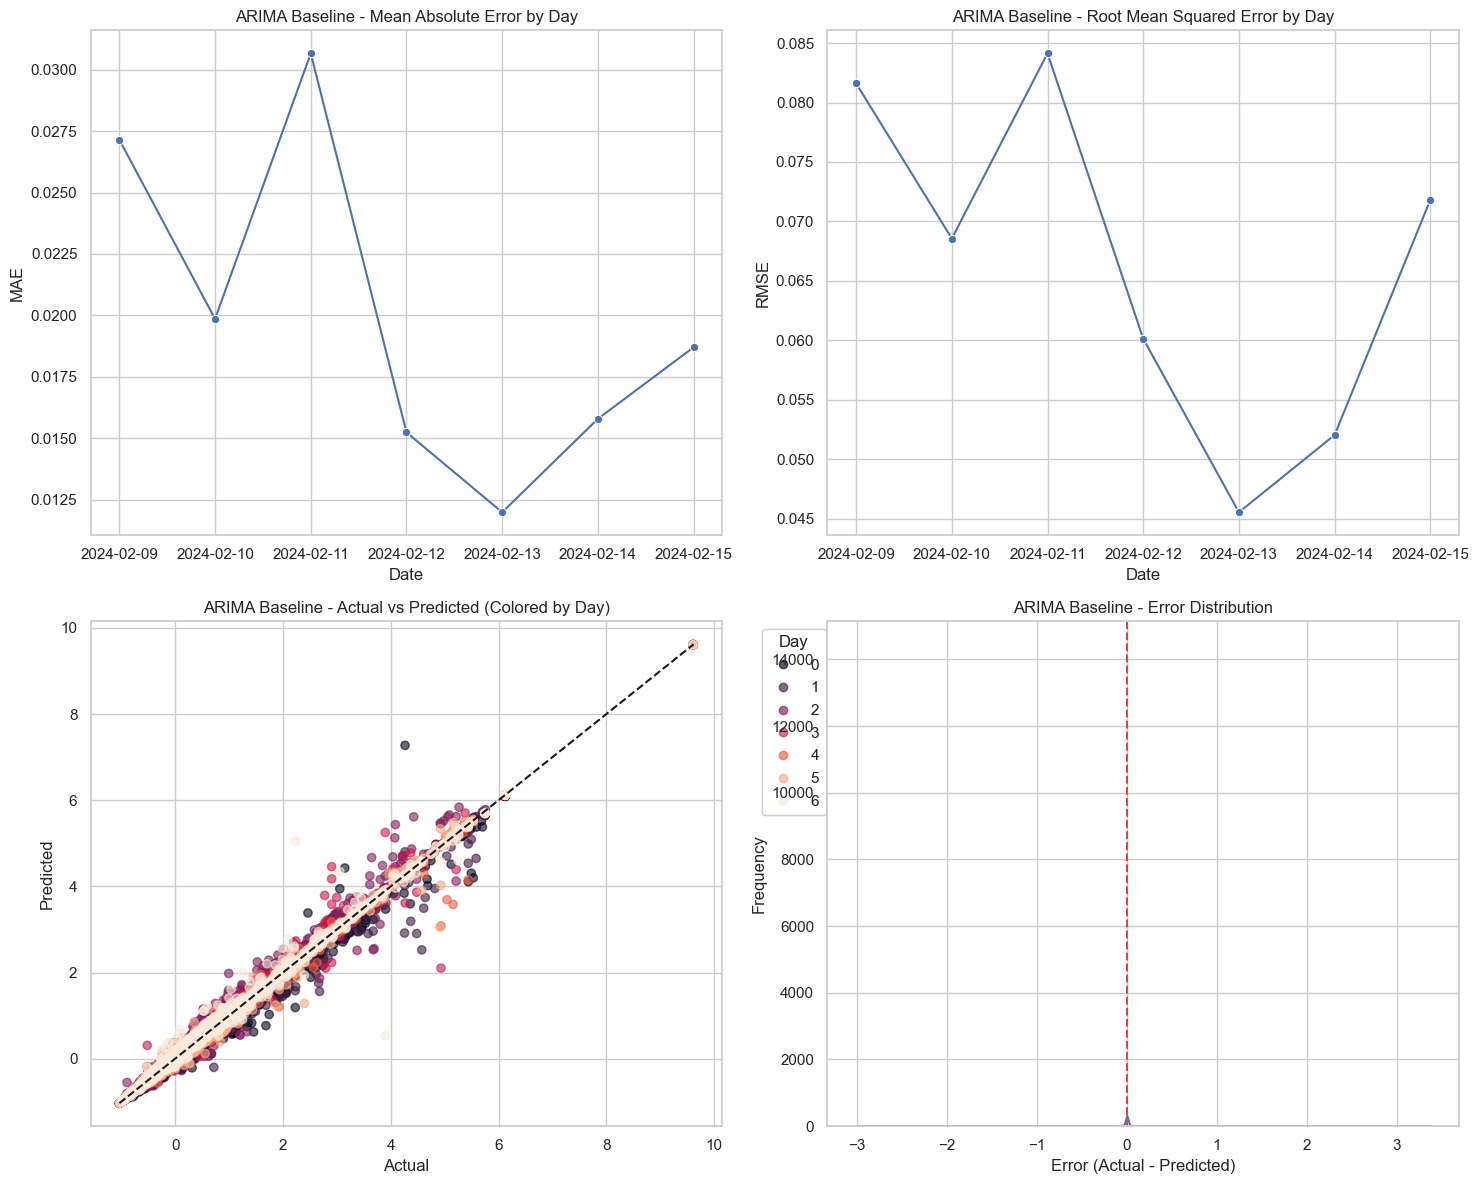

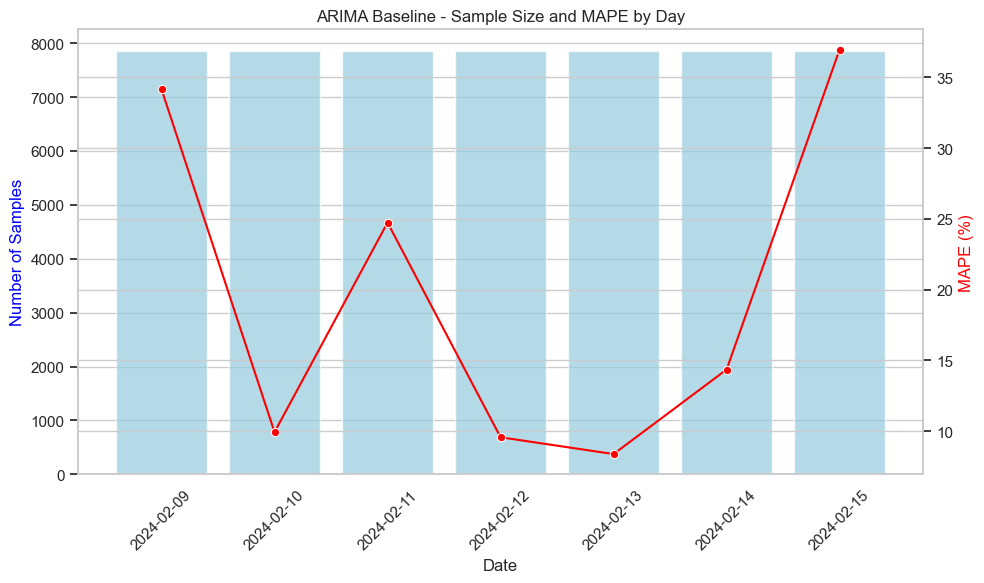

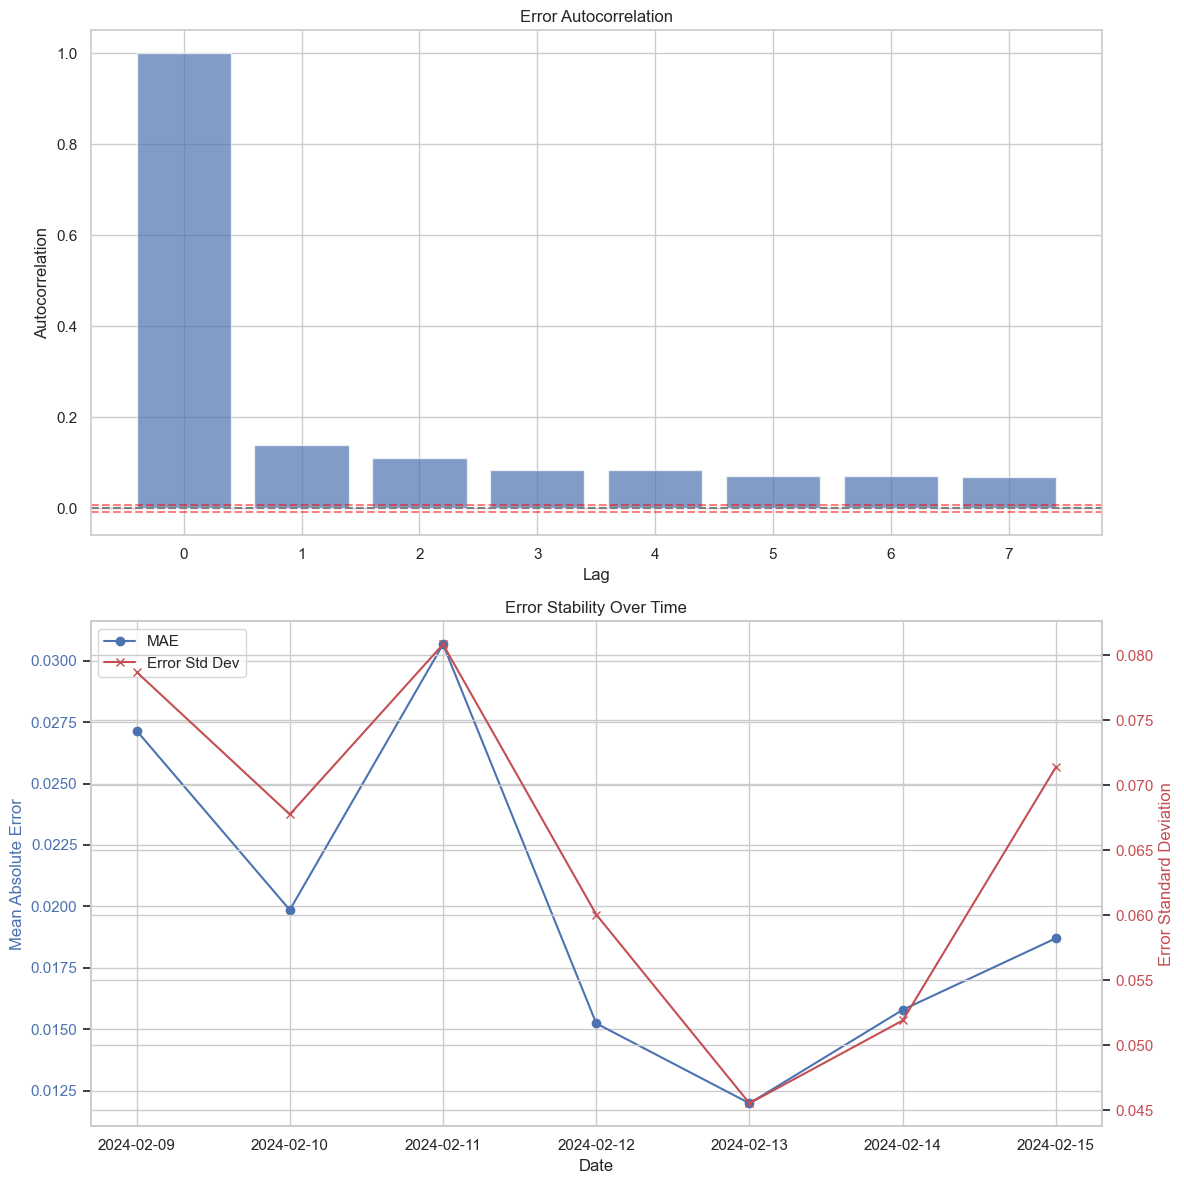

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import warnings
from datetime import datetime, timedelta
import math
import os  # Added for directory handling

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_day_by_day_arima_baseline(train_path, test_path, arima_order=(1, 1, 1), prediction_days=7, output_path=None):
    """
    Run ARIMA model with day-by-day prediction approach, using a separate ARIMA model
    for each individual listing's time series but with the same configuration for all.
    
    Parameters:
    -----------
    train_path : str
        Path to training data CSV
    test_path : str
        Path to test data CSV
    arima_order : tuple
        Order of the ARIMA model (p,d,q)
    prediction_days : int
        Number of days to predict
    output_path : str, optional
        Path to save results CSV. If None, results won't be saved.
    """
    import time
    from datetime import timedelta
    
    # Start timing the entire process
    start_time = time.time()
    
    print(f"Running day-by-day individual ARIMA prediction with order {arima_order}")
    
    # Load training and test data
    print("Loading data...")
    load_start = time.time()
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    load_time = time.time() - load_start
    print(f"Data loaded in {load_time:.2f} seconds")
    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    
    # Convert date columns to datetime
    print("Converting dates...")
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Sort by date
    train_data = train_data.sort_values(['listing_id', 'date'])
    test_data = test_data.sort_values(['listing_id', 'date'])
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction")
    
    # Get number of unique listings for estimation
    unique_listings = test_data['listing_id'].nunique()
    print(f"Processing {unique_listings} unique listings over {len(test_dates)} days")
    print(f"Total predictions to make: ~{unique_listings * len(test_dates)}")
    
    # Initialize results storage
    daily_results = []
    
    # Get global average price from training data (used as fallback)
    global_avg_price = train_data['price'].mean()
    print(f"Global average price (fallback): ${global_avg_price:.2f}")
    
    # Track ARIMA success rate
    arima_attempts = 0
    arima_success = 0
    
    # Process each day in the test set
    for day_idx, day in enumerate(tqdm(test_dates, desc="Processing days")):
        day_start = time.time()
        print(f"\n--- Day {day_idx+1}/{len(test_dates)}: {day} ---")
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        day_listings = day_test['listing_id'].unique()
        print(f"Found {len(day_listings)} listings for this day")
        
        # Make predictions for each listing on this day
        day_predictions = []
        
        # Track per-day ARIMA performance
        day_arima_attempts = 0
        day_arima_success = 0
        
        # Use tqdm to track progress within each day
        for listing_idx, listing_id in enumerate(tqdm(day_listings, desc=f"Day {day_idx+1} listings", leave=False)):
            # Get actual price from test data
            actual_price = day_test[day_test['listing_id'] == listing_id]['price'].values[0]
            
            # Get this listing's history from the training data
            day_dt = pd.to_datetime(day)
            listing_history = train_data[
                (train_data['listing_id'] == listing_id) & 
                (train_data['date'] < day_dt)
            ]
            
            # We need enough data points to fit an ARIMA model
            min_history_needed = max(4, sum(arima_order))  # At least 4 points or sum of p,d,q
            
            # Periodically report progress (every 100 listings)
            if listing_idx > 0 and listing_idx % 100 == 0:
                elapsed = time.time() - day_start
                remaining = (elapsed / listing_idx) * (len(day_listings) - listing_idx)
                print(f"  Processed {listing_idx}/{len(day_listings)} listings in {elapsed:.1f}s, est. {remaining:.1f}s remaining")
                print(f"  ARIMA success rate so far: {day_arima_success}/{day_arima_attempts} ({day_arima_success/max(1, day_arima_attempts)*100:.1f}%)")
            
            # Check if we have enough history for ARIMA
            if len(listing_history) >= min_history_needed:
                try:
                    arima_attempts += 1
                    day_arima_attempts += 1
                    
                    # Fit ARIMA model on this listing's price history
                    model = ARIMA(listing_history['price'].values, order=arima_order)
                    model_fit = model.fit()
                    
                    # Forecast the next price directly
                    predicted_price = model_fit.forecast(steps=1)[0]
                    
                    arima_success += 1
                    day_arima_success += 1
                    
                except Exception as e:
                    # If ARIMA fails, fall back to the last known price
                    last_price = listing_history['price'].iloc[-1] if len(listing_history) > 0 else global_avg_price
                    predicted_price = last_price
                    # Uncomment for more detailed error info
                    # print(f"    ARIMA failed for listing {listing_id}: {str(e)[:50]}... Using last price: {last_price}")
            else:
                # Not enough history, use last known price
                last_price = listing_history['price'].iloc[-1] if len(listing_history) > 0 else global_avg_price
                predicted_price = last_price
                # Uncomment for more insight
                # print(f"    Insufficient history for listing {listing_id} ({len(listing_history)} points). Using last price: {last_price}")
            
            # Add to results
            day_predictions.append({
                'date': day,
                'listing_id': listing_id,
                'price': actual_price,
                'predicted': predicted_price,
                'abs_error': abs(actual_price - predicted_price),
                'error': actual_price - predicted_price,
                'pct_error': abs((actual_price - predicted_price) / actual_price) * 100 if actual_price > 0 else 0
            })
        
        # Store day's results
        day_results = pd.DataFrame(day_predictions)
        daily_results.append(day_results)
        
        # Report end-of-day statistics
        day_time = time.time() - day_start
        day_mae = day_results['abs_error'].mean()
        day_rmse = np.sqrt(((day_results['price'] - day_results['predicted']) ** 2).mean())
        
        print(f"Day {day_idx+1} complete in {day_time:.2f} seconds")
        print(f"Day MAE: {day_mae:.2f}, RMSE: {day_rmse:.2f}")
        print(f"ARIMA success rate for day: {day_arima_success}/{day_arima_attempts} ({day_arima_success/max(1, day_arima_attempts)*100:.1f}%)")
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # before predicting the next day - exactly matching your neural network approach
        update_start = time.time()
        train_data = pd.concat([train_data, day_test], ignore_index=True)
        print(f"Training data updated in {time.time() - update_start:.2f}s, now contains {len(train_data)} records")
        
        # Estimate remaining time
        if day_idx < len(test_dates) - 1:
            time_so_far = time.time() - start_time
            avg_time_per_day = time_so_far / (day_idx + 1)
            remaining_days = len(test_dates) - (day_idx + 1)
            est_remaining = avg_time_per_day * remaining_days
            print(f"Estimated time remaining: {timedelta(seconds=int(est_remaining))}")
    
    # Combine all daily results
    print("\nCombining results...")
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate overall metrics
    print("Calculating metrics...")
    y_true = all_results['price'].values
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['price'].values
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,  # Added small epsilon
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    print("Calculating error autocorrelation...")
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    print("Calculating error stability metrics...")
    error_stability = calculate_error_stability(all_results)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability
    }
    
    # Save results to CSV if output path is provided
    if output_path:
        print(f"Saving results to {output_path}...")
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Include location data from test data if available
        if 'longitude' in test_data.columns and 'latitude' in test_data.columns:
            location_data = test_data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_path, index=False)
            print(f"Results saved to {output_path} with location data")
        else:
            all_results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Also save daily metrics
        metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(metrics_path, index=False)
        print(f"Daily metrics saved to {metrics_path}")
    
    # Report final statistics
    total_time = time.time() - start_time
    print(f"\n--- ARIMA Model Summary ---")
    print(f"Total execution time: {timedelta(seconds=int(total_time))}")
    print(f"ARIMA success rate: {arima_success}/{arima_attempts} ({arima_success/max(1, arima_attempts)*100:.1f}%)")
    print(f"Overall MAE: {metrics['mae']:.4f}")
    print(f"Overall RMSE: {metrics['rmse']:.4f}")
    print(f"Overall MAPE: {metrics['mape']:.2f}%")
    print(f"Overall R²: {metrics['r2']:.4f}")
    print("------------------------")
    
    return evaluation_results

def plot_results(evaluation_results, model_name="ARIMA Baseline"):
    """Plot the results from predictions - matches ST-RAP visualization exactly"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title(f'{model_name} - Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title(f'{model_name} - Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title(f'{model_name} - Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['price'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title(f'{model_name} - Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title(f'{model_name} - Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results, model_name="ARIMA Baseline"):
    """Print a summary of performance - matches ST-RAP summary format"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print(f"\n===== {model_name} MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")

def compare_models(strap_results, arima_results):
    """Create comparison visualizations between ST-RAP and ARIMA models"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    strap_daily = strap_results['daily_metrics']
    arima_daily = arima_results['daily_metrics']
    
    # Ensure date is datetime
    strap_daily['date'] = pd.to_datetime(strap_daily['date'])
    arima_daily['date'] = pd.to_datetime(arima_daily['date'])
    
    # Create combined dataframe for metrics
    strap_daily['model'] = 'ST-RAP'
    arima_daily['model'] = 'ARIMA'
    combined_metrics = pd.concat([strap_daily, arima_daily])
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: MAE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mae', 
        hue='model',
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('MAE Comparison')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Mean Absolute Error')
    
    # Plot 2: RMSE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='rmse', 
        hue='model',
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('RMSE Comparison')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Root Mean Squared Error')
    
    # Plot 3: MAPE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mape', 
        hue='model',
        marker='o',
        ax=axes[1, 0]
    )
    axes[1, 0].set_title('MAPE Comparison')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Mean Absolute Percentage Error (%)')
    
    # Plot 4: R² Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='r2', 
        hue='model',
        marker='o',
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('R² Comparison')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('R² Score')
    
    plt.tight_layout()
    plt.show()
    
    # Create bar chart comparison of overall metrics
    strap_overall = strap_results['overall_metrics']
    arima_overall = arima_results['overall_metrics']
    
    metrics = ['rmse', 'mae', 'mape']
    strap_values = [strap_overall['rmse'], strap_overall['mae'], strap_overall['mape']]
    arima_values = [arima_overall['rmse'], arima_overall['mae'], arima_overall['mape']]
    
    # Set up figure
    plt.figure(figsize=(12, 6))
    
    # Set positions and width
    positions = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    plt.bar(positions - width/2, strap_values, width, label='ST-RAP')
    plt.bar(positions + width/2, arima_values, width, label='ARIMA')
    
    # Add labels and titles
    plt.ylabel('Value')
    plt.title('Overall Performance Metrics Comparison')
    plt.xticks(positions, ['RMSE', 'MAE', 'MAPE'])
    plt.legend()
    
    # Add value labels on top of bars
    for i, v in enumerate(strap_values):
        plt.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(arima_values):
        plt.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Specify paths to your data
    train_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\train.csv"
    test_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\test_feb.csv"
    
    # Specify output path for results CSV
    output_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv"
    
    # Run ARIMA prediction with specified parameters
    arima_order = (1, 1, 1)  # Using standard ARIMA(1,1,1) configuration
    arima_results = run_day_by_day_arima_baseline(
        train_path=train_path,
        test_path=test_path,
        arima_order=arima_order,
        prediction_days=7,
        output_path=output_path  # Added parameter for saving results
    )
    
    # Print summary and plot results
    print_summary(arima_results)
    plot_results(arima_results)
    plot_error_analysis(arima_results)
    
    # If you have STRAP results available, uncomment this code to compare them
    """
    # Assuming you've saved STRAP results or have them available in memory
    # import pickle
    # strap_results = pickle.load(open('strap_results.pkl', 'rb'))
    
    # Or if you have the results directly:
    # strap_results = your_strap_results_variable
    
    # Then compare the models
    compare_models(strap_results, arima_results)
    """

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import warnings
from datetime import datetime, timedelta
import math
import os  # Added for directory handling

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def plot_results(evaluation_results, model_name="ARIMA Baseline"):
    """Plot the results from predictions - matches ST-RAP visualization exactly"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title(f'{model_name} - Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title(f'{model_name} - Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title(f'{model_name} - Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['price'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title(f'{model_name} - Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title(f'{model_name} - Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results, model_name="ARIMA Baseline"):
    """Print a summary of performance - matches ST-RAP summary format"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print(f"\n===== {model_name} MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")

def compare_models(strap_results, arima_results):
    """Create comparison visualizations between ST-RAP and ARIMA models"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    strap_daily = strap_results['daily_metrics']
    arima_daily = arima_results['daily_metrics']
    
    # Ensure date is datetime
    strap_daily['date'] = pd.to_datetime(strap_daily['date'])
    arima_daily['date'] = pd.to_datetime(arima_daily['date'])
    
    # Create combined dataframe for metrics
    strap_daily['model'] = 'ST-RAP'
    arima_daily['model'] = 'ARIMA'
    combined_metrics = pd.concat([strap_daily, arima_daily])
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: MAE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mae', 
        hue='model',
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('MAE Comparison')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Mean Absolute Error')
    
    # Plot 2: RMSE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='rmse', 
        hue='model',
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('RMSE Comparison')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Root Mean Squared Error')
    
    # Plot 3: MAPE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mape', 
        hue='model',
        marker='o',
        ax=axes[1, 0]
    )
    axes[1, 0].set_title('MAPE Comparison')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Mean Absolute Percentage Error (%)')
    
    # Plot 4: R² Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='r2', 
        hue='model',
        marker='o',
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('R² Comparison')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('R² Score')
    
    plt.tight_layout()
    plt.show()
    
    # Create bar chart comparison of overall metrics
    strap_overall = strap_results['overall_metrics']
    arima_overall = arima_results['overall_metrics']
    
    metrics = ['rmse', 'mae', 'mape']
    strap_values = [strap_overall['rmse'], strap_overall['mae'], strap_overall['mape']]
    arima_values = [arima_overall['rmse'], arima_overall['mae'], arima_overall['mape']]
    
    # Set up figure
    plt.figure(figsize=(12, 6))
    
    # Set positions and width
    positions = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    plt.bar(positions - width/2, strap_values, width, label='ST-RAP')
    plt.bar(positions + width/2, arima_values, width, label='ARIMA')
    
    # Add labels and titles
    plt.ylabel('Value')
    plt.title('Overall Performance Metrics Comparison')
    plt.xticks(positions, ['RMSE', 'MAE', 'MAPE'])
    plt.legend()
    
    # Add value labels on top of bars
    for i, v in enumerate(strap_values):
        plt.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(arima_values):
        plt.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

In [6]:
from scipy.stats import linregress


In [7]:
def calculate_new_error_stability(daily_metrics):
    """Calculate error stability metrics from daily performance data"""
    # Calculate coefficient of variation for MAE (lower = more stable)
    mae_values = daily_metrics['mae'].values
    
    # Prevent division by zero
    if np.mean(mae_values) == 0:
        mae_stability_coefficient = float('inf')
    else:
        mae_stability_coefficient = np.std(mae_values) / np.mean(mae_values)
    
    # Calculate trend in errors using linear regression
    x = np.arange(len(mae_values))
    
    # Handle case with too few points for regression
    if len(x) < 2:
        slope, r_value = 0, 0
    else:
        slope, _, r_value, _, _ = linregress(x, mae_values)
    
    return {
        'mae_stability_coefficient': mae_stability_coefficient,
        'mae_trend_slope': slope,
        'mae_trend_r2': r_value**2
    }


===== ARIMA Baseline MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.0676
MAE: 0.0199
R²: 0.9945
MAPE: 19.7296%

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.081618 0.027151 34.151284     7864.0
2024-02-10 0.068560 0.019857  9.938943     7864.0
2024-02-11 0.084142 0.030665 24.736276     7864.0
2024-02-12 0.060125 0.015241  9.576208     7864.0
2024-02-13 0.045526 0.011989  8.390643     7864.0
2024-02-14 0.052029 0.015792 14.358761     7864.0
2024-02-15 0.071825 0.018705 36.955411     7864.0

=== Performance Statistics ===
MAE:
  Average: 0.0199
  Min: 0.0120 (Day: 2024-02-13 00:00:00)
  Max: 0.0307 (Day: 2024-02-11 00:00:00)

RMSE:
  Average: 0.0663
  Min: 0.0455 (Day: 2024-02-13 00:00:00)
  Max: 0.0841 (Day: 2024-02-11 00:00:00)

MAPE:
  Average: 19.73%
  Min: 8.39% (Day: 2024-02-13 00:00:00)
  Max: 36.96% (Day: 2024-02-15 00:00:00)

=== Error Autocorrelation ===
  Lag 1: 0.1402
  Lag 2: 0.1100
  Lag 3: 0.0850
  Lag 4: 0.0834
  Lag 5

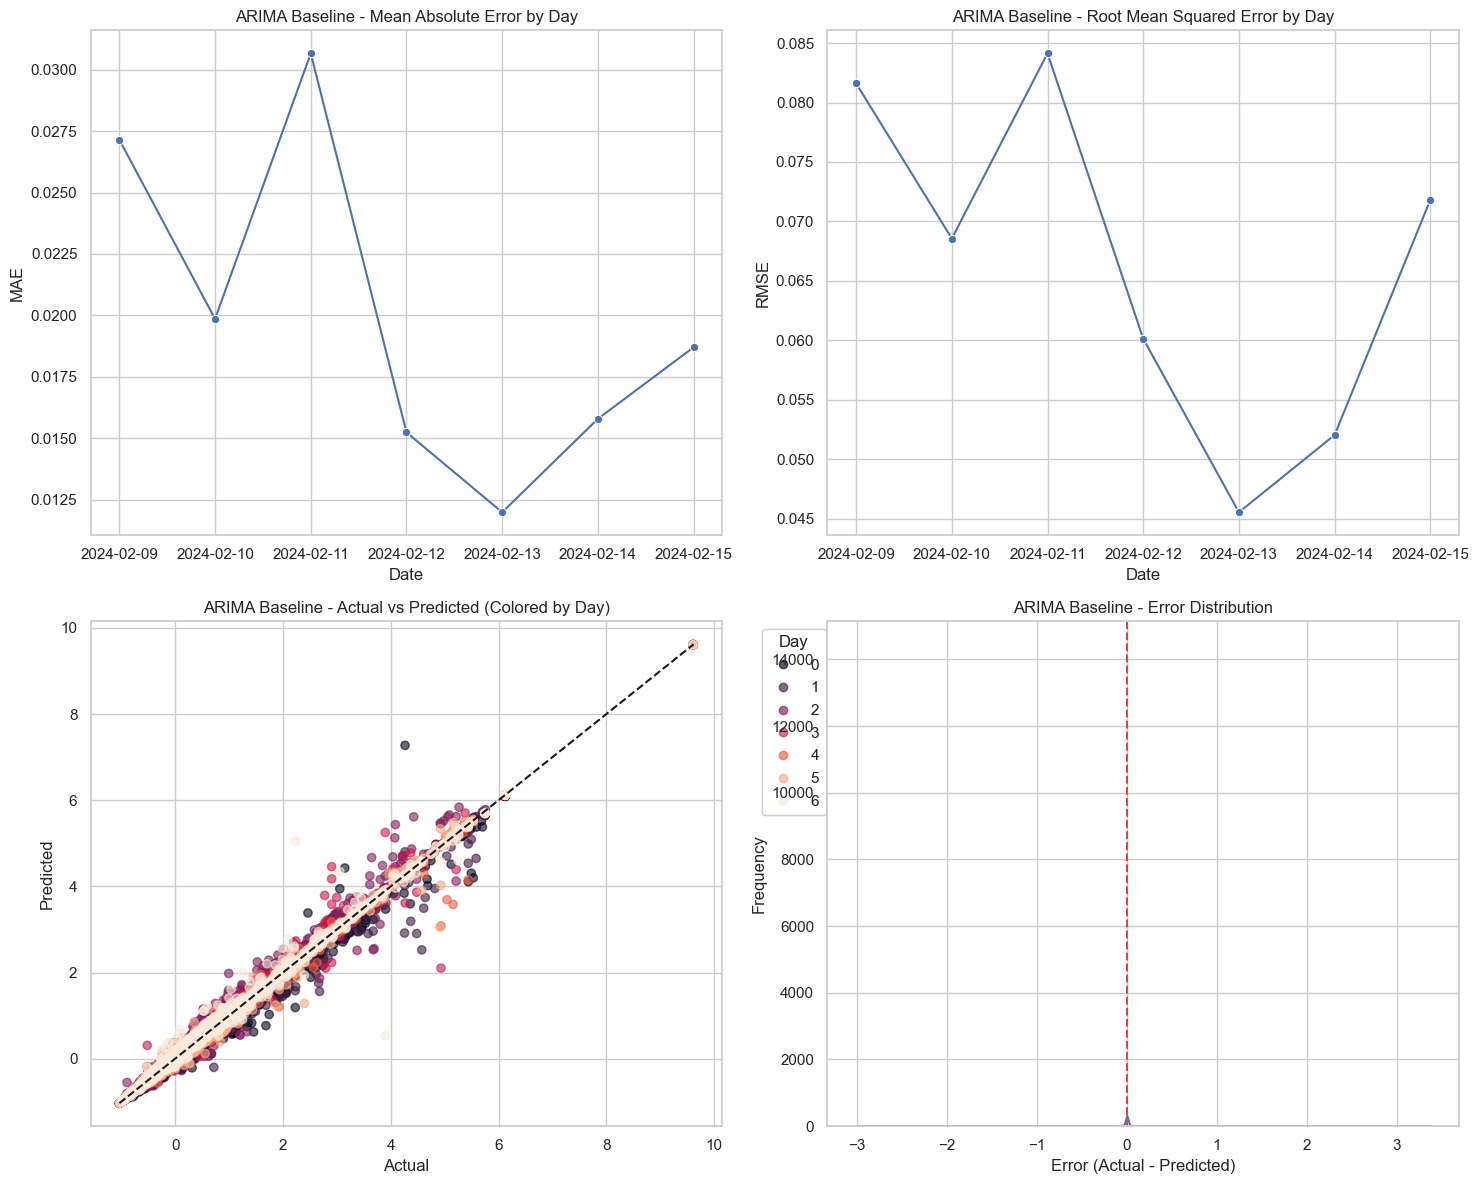

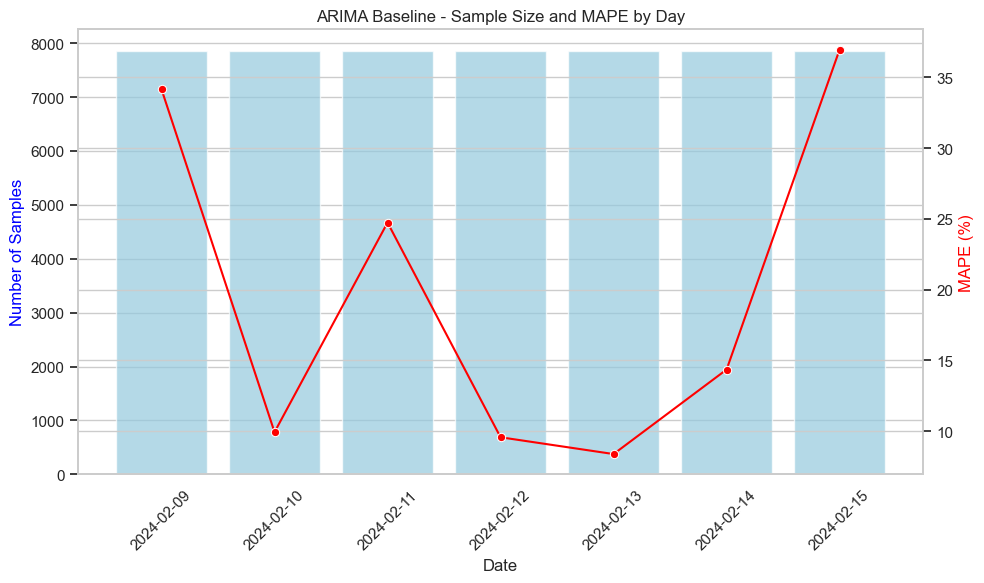

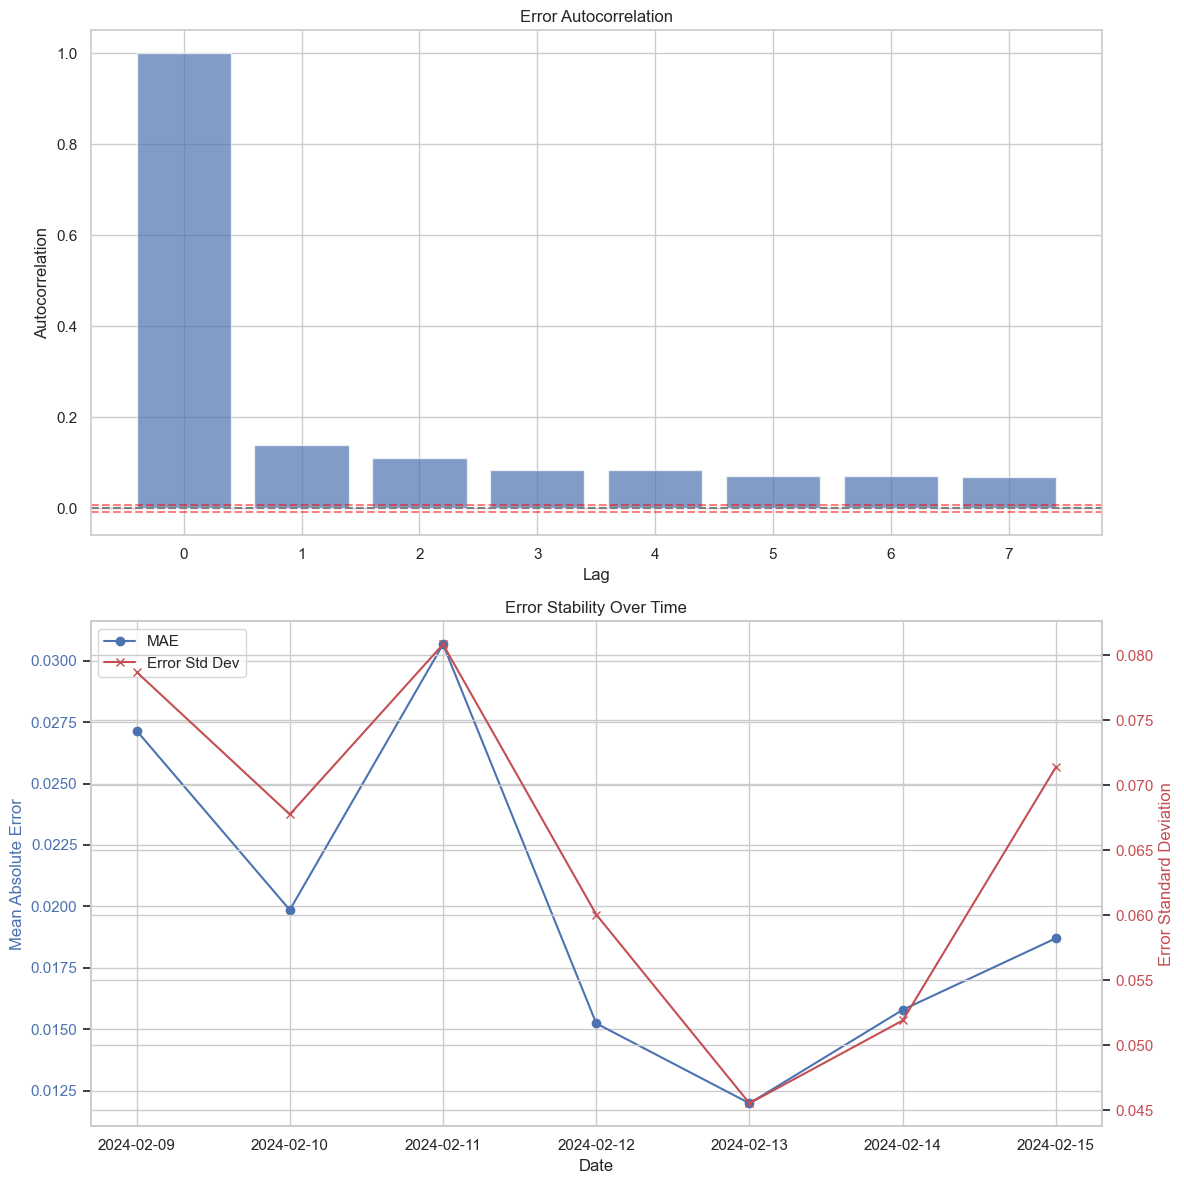

In [9]:
# Set the file path to your results
file_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\ARIMA RESULTS\Top Changers results\Single_Listing_arima_baseline_results.csv"

# Load the data
results_df = pd.read_csv(file_path)

# Ensure the date column is in datetime format
if 'date' in results_df.columns:
    results_df['date'] = pd.to_datetime(results_df['date'])
elif 'date_str' in results_df.columns:
    results_df['date'] = pd.to_datetime(results_df['date_str'])
    
# Make sure we have the expected columns
if 'price' not in results_df.columns or 'predicted' not in results_df.columns:
    print("Error: CSV file must contain 'price' and 'predicted' columns")
    exit()

# Add required columns for analysis
results_df['error'] = results_df['price'] - results_df['predicted']
results_df['abs_error'] = results_df['error'].abs()
results_df['date_str'] = results_df['date'].dt.strftime('%Y-%m-%d')

# Calculate overall metrics
overall_metrics = {
    'rmse': math.sqrt(mean_squared_error(results_df['price'], results_df['predicted'])),
    'mae': mean_absolute_error(results_df['price'], results_df['predicted']),
    'r2': r2_score(results_df['price'], results_df['predicted']),
    'mape': 100 * np.mean(np.abs((results_df['price'] - results_df['predicted']) / results_df['price']))
}

# Calculate daily metrics
daily_metrics = results_df.groupby('date_str').apply(
    lambda x: pd.Series({
        'rmse': math.sqrt(mean_squared_error(x['price'], x['predicted'])),
        'mae': mean_absolute_error(x['price'], x['predicted']),
        'r2': r2_score(x['price'], x['predicted']),
        'mape': 100 * np.mean(np.abs((x['price'] - x['predicted']) / x['price'])),
        'n_samples': len(x)
    })
).reset_index()
daily_metrics['date'] = pd.to_datetime(daily_metrics['date_str'])

# Calculate error autocorrelation
error_autocorr = calculate_error_autocorrelation(results_df['error'].values)

# Calculate error stability
error_stability = calculate_error_stability(results_df)

# Compile all results
evaluation_results = {
    'overall_metrics': overall_metrics,
    'daily_metrics': daily_metrics,
    'error_autocorrelation': error_autocorr,
    'error_stability': error_stability,
    'all_results': results_df
}

# Print summary and visualize results
print_summary(evaluation_results, model_name="ARIMA Baseline")
plot_results(evaluation_results, model_name="ARIMA Baseline")
plot_error_analysis(evaluation_results)

### Originele Arima Code

Running day-by-day ARIMA prediction with order (1, 1, 1)
Loading data...
Test set contains 7 unique dates.


Processing days: 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv with location data
Daily metrics saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results_daily_metrics.csv

===== ARIMA Baseline MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.1577
MAE: 0.0644
R²: 0.9665
MAPE: 11.7321%

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.228640 0.058655 14.097859       6581
2024-02-10 0.223899 0.177953 26.870249       6581
2024-02-11 0.254659 0.147447 28.191033       6581
2024-02-12 0.069043 0.021443  4.401785       6581
2024-02-13 0.026612 0.017621  3.265652       6581
2024-02-14 0.025899 0.016596  2.846091       6581
2024-02-15 0.026045 0.011252  2.451703       6581

=== Performance Statistics ===
MAE:
  Average: 0.0644
  Min: 0.0113 (Day: 2024-02-15)
  Max: 0.1780 (Day: 2024-02-10)

RMSE:
  Average: 0.1221
  Min: 0.0259 (Day: 2024-02-14)
  Max: 0.2547 (Day:

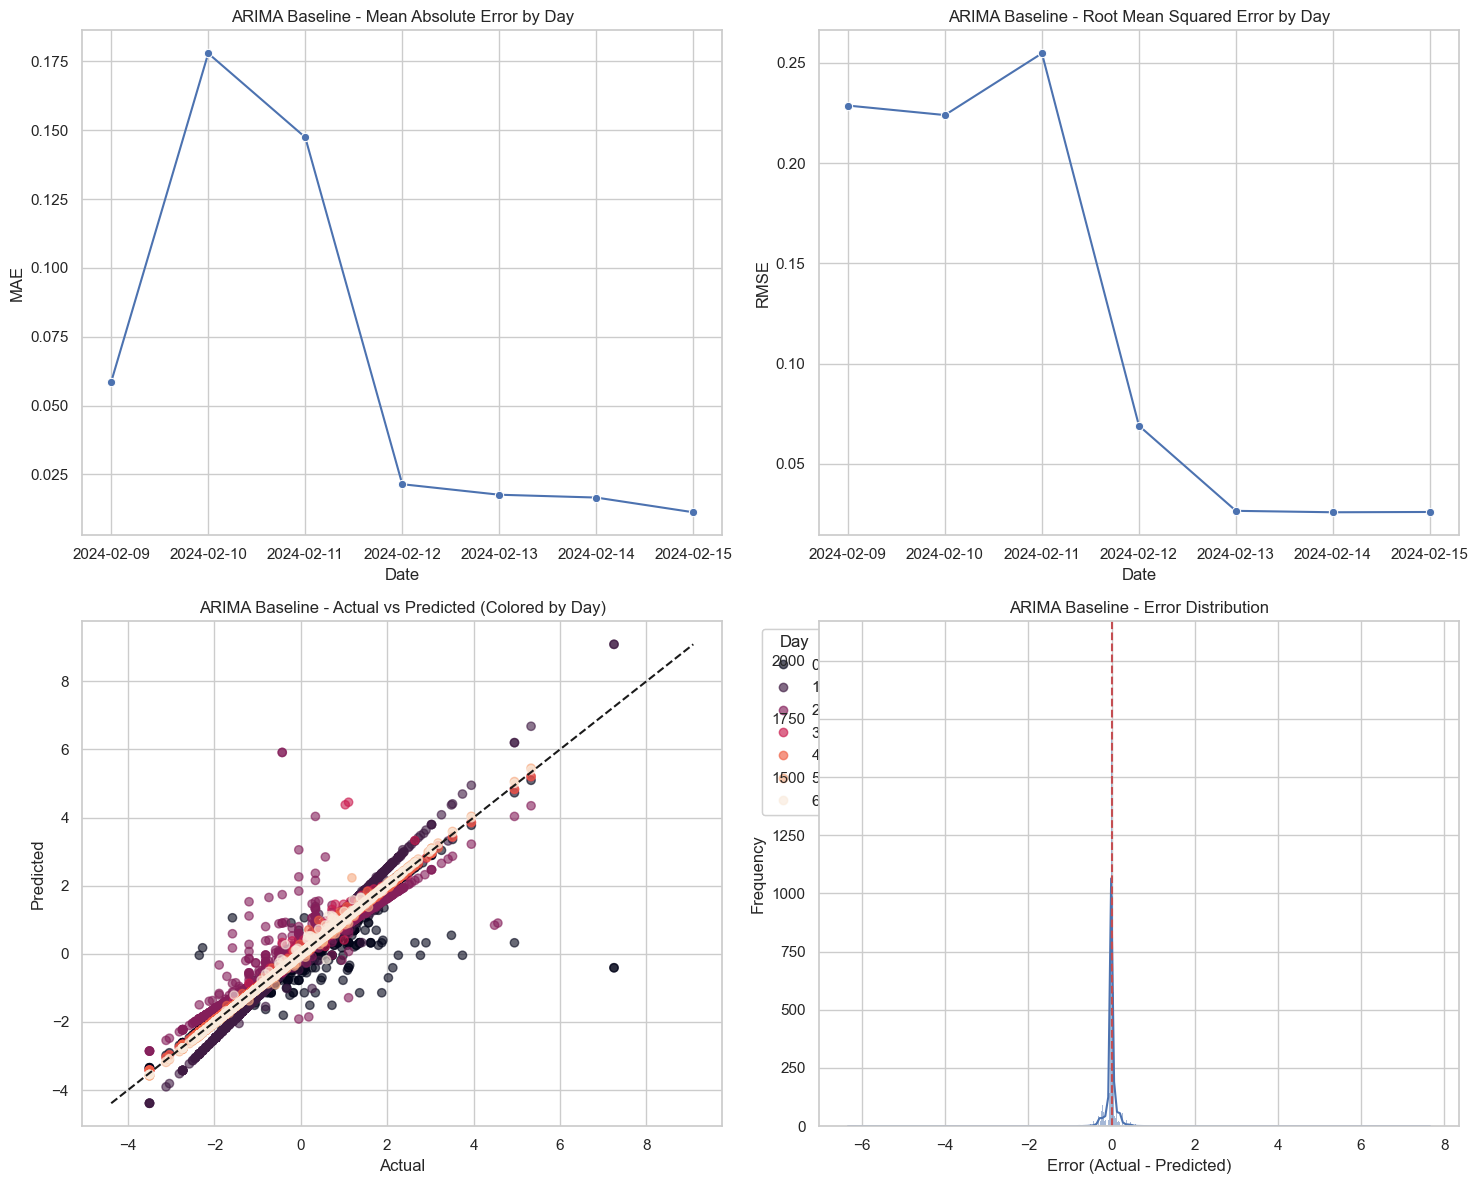

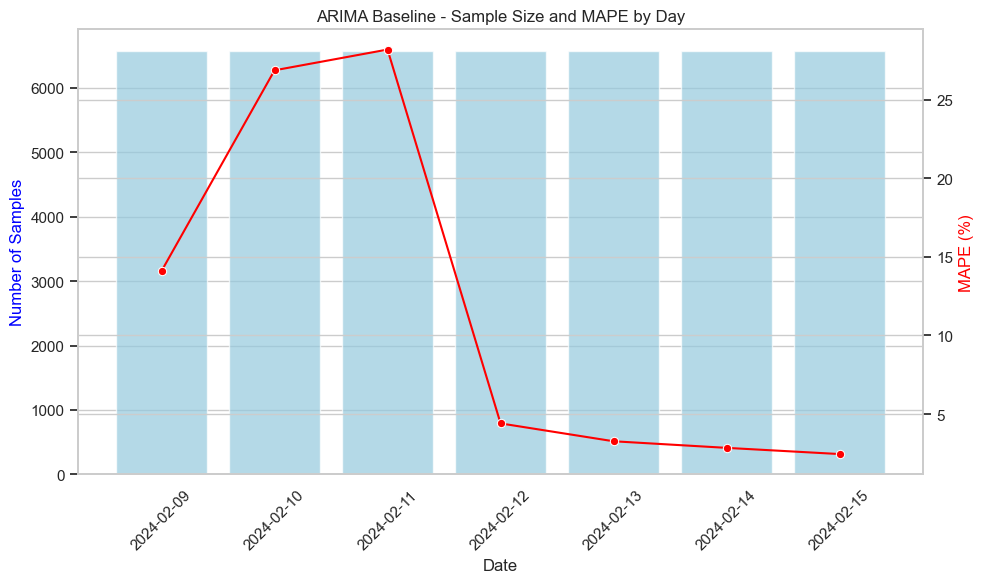

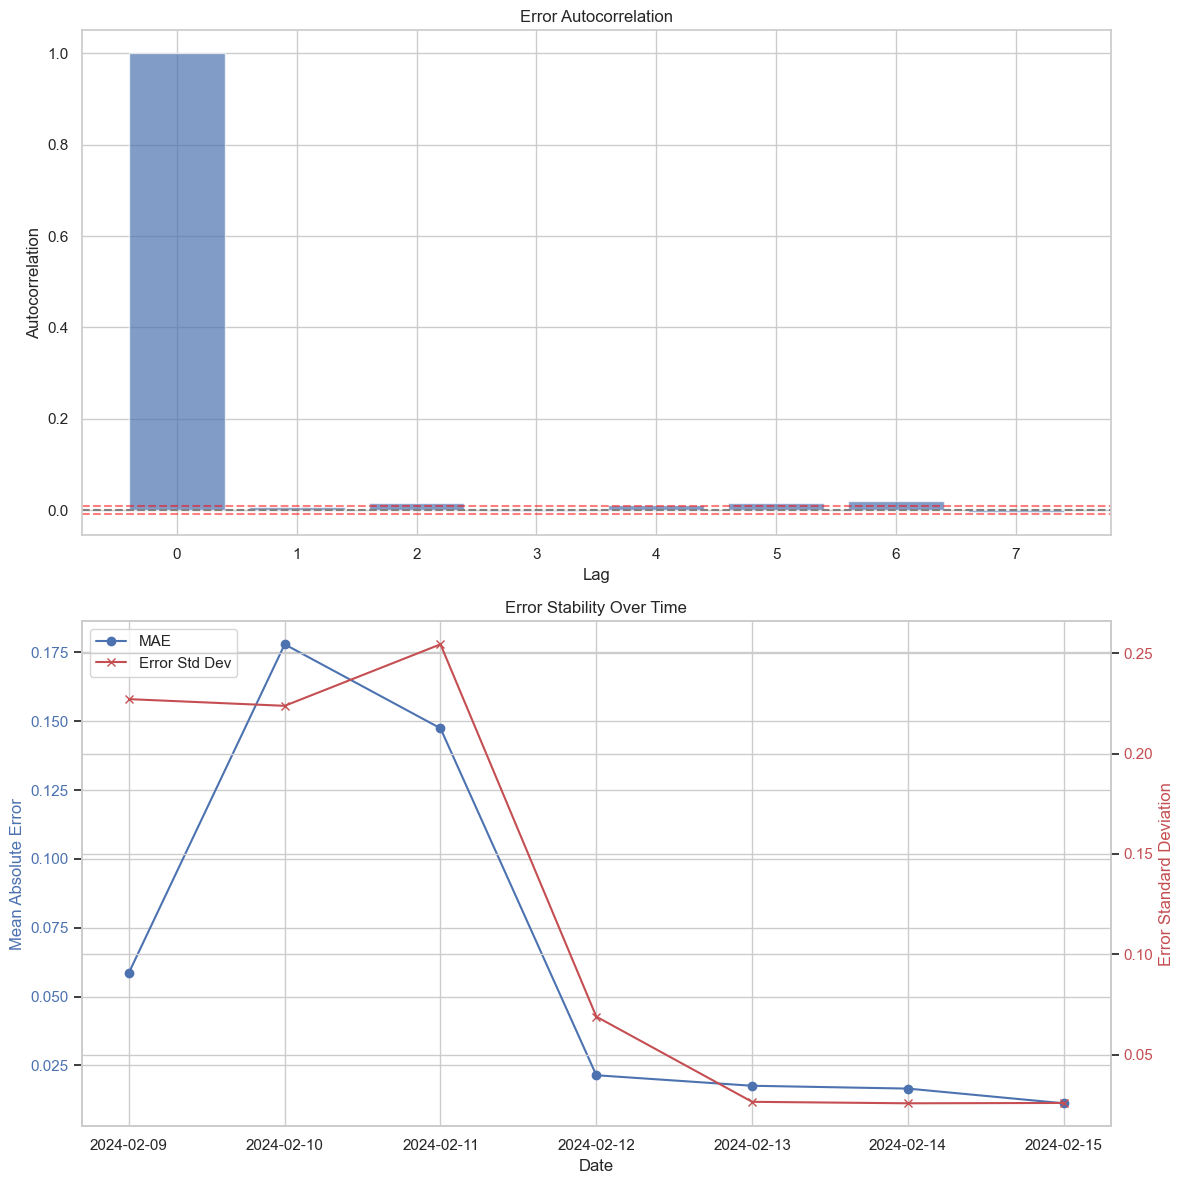

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import warnings
from datetime import datetime, timedelta
import math
import os  # Added for directory handling

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_day_by_day_arima_baseline(train_path, test_path, arima_order=(1, 1, 1), prediction_days=7, output_path=None):
    """
    Run ARIMA model with day-by-day prediction approach, exactly matching the ST-RAP neural network analysis.
    Uses a single ARIMA model for all listings but updates predictions day by day.
    
    Parameters:
    -----------
    train_path : str
        Path to training data CSV
    test_path : str
        Path to test data CSV
    arima_order : tuple
        Order of the ARIMA model (p,d,q)
    prediction_days : int
        Number of days to predict
    output_path : str, optional
        Path to save results CSV. If None, results won't be saved.
    """
    print(f"Running day-by-day ARIMA prediction with order {arima_order}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Initialize results storage
    daily_results = []
    
    # Get global average price from training data (used as fallback)
    global_avg_price = train_data['price'].mean()
    
    # Get the latest known price for each listing
    latest_prices = train_data.sort_values('date').groupby('listing_id').last()['price']
    
    # Process each day in the test set
    for day_idx, day in enumerate(tqdm(test_dates, desc="Processing days")):
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        # Get unique listings for this day
        day_listings = day_test['listing_id'].unique()
        
        # Calculate average price by day in the updated training data
        # This creates a time series of market trends
        daily_avg = train_data.groupby(train_data['date'].dt.date)['price'].mean().reset_index()
        daily_avg.columns = ['date', 'avg_price']
        
        # Fit ARIMA model on the average price time series
        try:
            # Only use ARIMA if we have enough data points
            if len(daily_avg) >= 4:  # Minimum data needed for meaningful ARIMA
                model = ARIMA(daily_avg['avg_price'].values, order=arima_order)
                model_fit = model.fit()
                
                # Forecast next day's average price
                forecast_avg = model_fit.forecast(steps=1)[0]
                
                # Get the most recent average price
                latest_avg = daily_avg['avg_price'].iloc[-1]
                
                # Calculate the market trend multiplier
                trend_multiplier = forecast_avg / latest_avg if latest_avg > 0 else 1.0
            else:
                # Not enough data for ARIMA, use the last day's average
                trend_multiplier = 1.0
        except:
            # If ARIMA fails, assume no trend change
            trend_multiplier = 1.0
            
        # Make predictions for each listing on this day
        day_predictions = []
        
        for listing_id in day_listings:
            # Get actual price from test data
            actual_price = day_test[day_test['listing_id'] == listing_id]['price'].values[0]
            
            # Get listing's most recent price from training data
            if listing_id in latest_prices.index:
                base_price = latest_prices[listing_id]
            else:
                # If we haven't seen this listing before, use global average
                base_price = global_avg_price
            
            # Apply the market trend to get predicted price
            predicted_price = base_price * trend_multiplier
            
            # Add to results
            day_predictions.append({
                'date': day,
                'listing_id': listing_id,
                'price': actual_price,
                'predicted': predicted_price,
                'abs_error': abs(actual_price - predicted_price),
                'error': actual_price - predicted_price,
                'pct_error': abs((actual_price - predicted_price) / actual_price) * 100 if actual_price > 0 else 0
            })
        
        # Store day's results
        day_results = pd.DataFrame(day_predictions)
        daily_results.append(day_results)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # before predicting the next day - exactly matching your neural network approach
        train_data = pd.concat([train_data, day_test], ignore_index=True)
        
        # Update latest prices with actual prices from this day
        for _, row in day_test.iterrows():
            latest_prices[row['listing_id']] = row['price']
    
    # Combine all daily results
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['price'].values
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,  # Added small epsilon
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability
    }
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Include location data from test data if available
        if 'longitude' in test_data.columns and 'latitude' in test_data.columns:
            location_data = test_data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_path, index=False)
            print(f"Results saved to {output_path} with location data")
        else:
            all_results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Also save daily metrics
        metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(metrics_path, index=False)
        print(f"Daily metrics saved to {metrics_path}")
    
    return evaluation_results

def plot_results(evaluation_results, model_name="ARIMA Baseline"):
    """Plot the results from predictions - matches ST-RAP visualization exactly"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title(f'{model_name} - Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title(f'{model_name} - Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title(f'{model_name} - Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['price'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title(f'{model_name} - Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title(f'{model_name} - Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results, model_name="ARIMA Baseline"):
    """Print a summary of performance - matches ST-RAP summary format"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print(f"\n===== {model_name} MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")

def compare_models(strap_results, arima_results):
    """Create comparison visualizations between ST-RAP and ARIMA models"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    strap_daily = strap_results['daily_metrics']
    arima_daily = arima_results['daily_metrics']
    
    # Ensure date is datetime
    strap_daily['date'] = pd.to_datetime(strap_daily['date'])
    arima_daily['date'] = pd.to_datetime(arima_daily['date'])
    
    # Create combined dataframe for metrics
    strap_daily['model'] = 'ST-RAP'
    arima_daily['model'] = 'ARIMA'
    combined_metrics = pd.concat([strap_daily, arima_daily])
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: MAE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mae', 
        hue='model',
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('MAE Comparison')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Mean Absolute Error')
    
    # Plot 2: RMSE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='rmse', 
        hue='model',
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('RMSE Comparison')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Root Mean Squared Error')
    
    # Plot 3: MAPE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mape', 
        hue='model',
        marker='o',
        ax=axes[1, 0]
    )
    axes[1, 0].set_title('MAPE Comparison')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Mean Absolute Percentage Error (%)')
    
    # Plot 4: R² Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='r2', 
        hue='model',
        marker='o',
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('R² Comparison')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('R² Score')
    
    plt.tight_layout()
    plt.show()
    
    # Create bar chart comparison of overall metrics
    strap_overall = strap_results['overall_metrics']
    arima_overall = arima_results['overall_metrics']
    
    metrics = ['rmse', 'mae', 'mape']
    strap_values = [strap_overall['rmse'], strap_overall['mae'], strap_overall['mape']]
    arima_values = [arima_overall['rmse'], arima_overall['mae'], arima_overall['mape']]
    
    # Set up figure
    plt.figure(figsize=(12, 6))
    
    # Set positions and width
    positions = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    plt.bar(positions - width/2, strap_values, width, label='ST-RAP')
    plt.bar(positions + width/2, arima_values, width, label='ARIMA')
    
    # Add labels and titles
    plt.ylabel('Value')
    plt.title('Overall Performance Metrics Comparison')
    plt.xticks(positions, ['RMSE', 'MAE', 'MAPE'])
    plt.legend()
    
    # Add value labels on top of bars
    for i, v in enumerate(strap_values):
        plt.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(arima_values):
        plt.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Specify paths to your data
    train_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_cheapest_listings_subset\train.csv"
    test_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_cheapest_listings_subset\test_feb.csv"
    
    # Specify output path for results CSV
    output_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv"
    
    # Run ARIMA prediction with specified parameters
    arima_order = (1, 1, 1)  # Using standard ARIMA(1,1,1) configuration
    arima_results = run_day_by_day_arima_baseline(
        train_path=train_path,
        test_path=test_path,
        arima_order=arima_order,
        prediction_days=7,
        output_path=output_path  # Added parameter for saving results
    )
    
    # Print summary and plot results
    print_summary(arima_results)
    plot_results(arima_results)
    plot_error_analysis(arima_results)
    
    # If you have STRAP results available, uncomment this code to compare them
    """
    # Assuming you've saved STRAP results or have them available in memory
    # import pickle
    # strap_results = pickle.load(open('strap_results.pkl', 'rb'))
    
    # Or if you have the results directly:
    # strap_results = your_strap_results_variable
    
    # Then compare the models
    compare_models(strap_results, arima_results)
    """

### Spatial Analysis


#### Error

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

def run_enhanced_spatial_analysis(results_path, geojson_path, output_dir):
    """
    Run an enhanced spatial analysis with clear, actionable insights
    
    Parameters:
    results_path: Path to naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running enhanced spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Create GeoDataFrame from results
    if 'longitude' in results_df.columns and 'latitude' in results_df.columns:
        # Clean data - remove rows with missing coordinates
        results_df = results_df.dropna(subset=['longitude', 'latitude'])
        
        # Convert coordinates to float if needed
        results_df['longitude'] = results_df['longitude'].astype(float)
        results_df['latitude'] = results_df['latitude'].astype(float)
        
        # Create geometry
        geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
        results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
        print(f"Created GeoDataFrame with {len(results_gdf)} points")
    else:
        raise ValueError("Results file missing longitude/latitude coordinates")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with newer geopandas versions
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with older geopandas versions
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback to simple approach
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            results_with_neighborhoods['index_right'] = None
            results_with_neighborhoods['neighbourhood'] = None
    
    # 5. Ensure we have a neighborhood column
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Look for another neighborhood column
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
        else:
            print("Warning: No neighborhood column identified")
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 6. Calculate distance to city center (in kilometers)
    paris_center = Point(2.3522, 48.8566)  # Approximate center of Paris
    results_with_neighborhoods['dist_to_center_km'] = results_with_neighborhoods.geometry.apply(
        lambda x: paris_center.distance(x) * 111.32  # Approximate conversion to km
    )
    
    # 7. Calculate neighborhood-level metrics
    print("Calculating neighborhood metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'abs_error': ['mean', 'median', 'std'],
        'error': ['mean', 'std'],
        'pct_error': ['mean', 'std'],
        'price': ['mean', 'median', 'std', 'count'],
        'dist_to_center_km': 'mean'
    })
    
    # Flatten column names
    neighborhood_metrics.columns = ['_'.join(col).strip('_') for col in neighborhood_metrics.columns.values]
    
    # Rename for clarity
    neighborhood_metrics = neighborhood_metrics.rename(columns={
        'abs_error_mean': 'mae',
        'abs_error_median': 'median_abs_error',
        'abs_error_std': 'error_volatility',
        'pct_error_mean': 'mape',
        'price_count': 'listing_count',
        'dist_to_center_km_mean': 'avg_distance_to_center'
    })
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['listing_count'] >= min_listings].copy()
    
    # 8. Create comprehensive spatial visualizations
    print("Creating visualizations...")
    
    # 8.1 Create main error map with key insights
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'mae', 
        'Mean Absolute Error by Neighborhood',
        os.path.join(output_dir, 'error_map.png')
    )
    
    # 8.2 Create map showing bias (over/under prediction)
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_mean', 
        'Prediction Bias by Neighborhood (+ = Underestimated, - = Overestimated)',
        os.path.join(output_dir, 'bias_map.png'),
        cmap='RdBu'
    )
    
    # 8.3 Create map showing error volatility
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_volatility', 
        'Error Volatility by Neighborhood',
        os.path.join(output_dir, 'volatility_map.png')
    )
    
    # 8.4 Create multi-panel analysis of key relationships
    create_multi_panel_analysis(filtered_metrics, os.path.join(output_dir, 'spatial_relationships.png'))
    
    # 8.5 Create scatterplot matrix
    create_scatterplot_matrix(filtered_metrics, os.path.join(output_dir, 'scatterplot_matrix.png'))
    
    # 9. Calculate error vs distance relationship
    dist_error_corr, dist_error_p = pearsonr(
        results_with_neighborhoods['dist_to_center_km'],
        results_with_neighborhoods['abs_error']
    )
    
    # 10. Create distance vs error analysis
    create_distance_analysis(
        results_with_neighborhoods,
        os.path.join(output_dir, 'distance_analysis.png')
    )
    
    # 11. Cluster neighborhoods by error patterns
    n_clusters = min(5, len(filtered_metrics))
    cluster_features = ['mae', 'error_mean', 'mape', 'price_mean', 'avg_distance_to_center']
    
    # Scale the data for clustering
    from sklearn.preprocessing import StandardScaler
    X = filtered_metrics[cluster_features].copy()
    X = StandardScaler().fit_transform(X)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    filtered_metrics['cluster'] = kmeans.fit_predict(X)
    
    # Create neighborhood cluster map
    create_cluster_map(
        neighborhoods,
        filtered_metrics,
        os.path.join(output_dir, 'neighborhood_clusters.png')
    )
    
    # 12. Create neighborhood performance table
    # Table of best and worst neighborhoods
    best_neighborhoods = filtered_metrics.sort_values('mae').head(5)
    worst_neighborhoods = filtered_metrics.sort_values('mae', ascending=False).head(5)
    
    performance_table = pd.concat([
        best_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']],
        worst_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    ])
    performance_table['category'] = ['Best'] * 5 + ['Worst'] * 5
    performance_table = performance_table[['category', 'neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    
    # Save to CSV
    performance_table.to_csv(os.path.join(output_dir, 'neighborhood_performance.csv'), index=False)
    
    # Save all metrics
    filtered_metrics.to_csv(os.path.join(output_dir, 'all_neighborhood_metrics.csv'))
    
    # 13. Print key insights
    print("\n--- KEY SPATIAL INSIGHTS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Best performing neighborhood: {best_neighborhoods.index[0]} (MAE = {best_neighborhoods['mae'].iloc[0]:.4f})")
    print(f"Worst performing neighborhood: {worst_neighborhoods.index[0]} (MAE = {worst_neighborhoods['mae'].iloc[0]:.4f})")
    
    # Calculate correlations between metrics
    corr = filtered_metrics[['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']].corr()
    
    # Print key correlations
    print("\n--- KEY CORRELATIONS ---")
    print(f"Price vs Error (MAE): {corr.loc['price_mean', 'mae']:.4f}")
    print(f"Distance to Center vs Error: {corr.loc['avg_distance_to_center', 'mae']:.4f}")
    print(f"Listing Count vs Error: {corr.loc['listing_count', 'mae']:.4f}")
    
    # Direct distance-error relationship from points
    print(f"Point-level Distance-Error Correlation: {dist_error_corr:.4f} (p-value: {dist_error_p:.4f})")
    
    # Interpret key findings
    print("\n--- INTERPRETATION ---")
    
    # Price-error relationship
    price_corr = corr.loc['price_mean', 'mae']
    if abs(price_corr) > 0.7:
        print(f"Very strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
        if price_corr > 0:
            print("- Higher-priced neighborhoods have significantly larger prediction errors")
            print("- Model struggles most with luxury/premium areas")
        else:
            print("- Higher-priced neighborhoods have significantly lower prediction errors")
            print("- Model performs better in premium/luxury areas")
    elif abs(price_corr) > 0.5:
        print(f"Strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    elif abs(price_corr) > 0.3:
        print(f"Moderate {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    else:
        print(f"Weak correlation between price and error ({price_corr:.2f})")
        print("- Neighborhood price level is not a strong predictor of model performance")
    
    # Distance-error relationship
    dist_corr = corr.loc['avg_distance_to_center', 'mae']
    if abs(dist_corr) > 0.5:
        print(f"\nStrong {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
        if dist_corr > 0:
            print("- Neighborhoods further from the city center have larger prediction errors")
            print("- Model performs worse in peripheral areas")
        else:
            print("- Central neighborhoods have larger prediction errors")
            print("- Model performs better in peripheral areas")
    elif abs(dist_corr) > 0.3:
        print(f"\nModerate {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
    else:
        print(f"\nWeak correlation between distance to center and error ({dist_corr:.2f})")
        print("- Location relative to city center doesn't strongly affect prediction accuracy")
    
    # Bias analysis (over/under prediction)
    avg_error = filtered_metrics['error_mean'].mean()
    if abs(avg_error) > 0.05:
        bias_direction = "underestimates" if avg_error > 0 else "overestimates"
        print(f"\nThe model generally {bias_direction} prices (average error: {avg_error:.4f})")
        
        # Check if bias is consistent across neighborhoods
        bias_std = filtered_metrics['error_mean'].std()
        if bias_std < abs(avg_error) * 0.5:
            print("- This bias is fairly consistent across neighborhoods")
        else:
            most_under = filtered_metrics.sort_values('error_mean', ascending=False).index[0]
            most_over = filtered_metrics.sort_values('error_mean', ascending=True).index[0]
            print(f"- Bias varies considerably by neighborhood")
            print(f"- Most underestimated neighborhood: {most_under}")
            print(f"- Most overestimated neighborhood: {most_over}")
    
    print(f"\nResults saved to {output_dir}")
    
    return {
        'neighborhood_metrics': filtered_metrics,
        'correlations': corr,
        'distance_correlation': dist_error_corr
    }

def create_error_map(neighborhoods, metrics, column, title, output_path, cmap='Reds'):
    """Create a detailed choropleth map with key insights"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create the map
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    map_data.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'label': column.replace('_', ' ').title(),
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.05
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Label top 3 and bottom 3 neighborhoods
    if column in metrics.columns:
        # Top 3 highest values
        top3 = metrics.sort_values(column, ascending=False).head(3)
        for idx, row in top3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
        
        # Top 3 lowest values
        bottom3 = metrics.sort_values(column).head(3)
        for idx, row in bottom3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
    
    # Add title and styling
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    
    # Add key statistics box
    if column in metrics.columns:
        corr_with_price = metrics[[column, 'price_mean']].corr().iloc[0, 1]
        corr_with_dist = metrics[[column, 'avg_distance_to_center']].corr().iloc[0, 1]
        
        stats_text = (
            f"Correlation with price: {corr_with_price:.2f}\n"
            f"Correlation with distance: {corr_with_dist:.2f}\n"
            f"Best area: {metrics[column].idxmin()}\n"
            f"Worst area: {metrics[column].idxmax()}"
        )
        
        # Place text box in bottom right
        plt.figtext(
            0.92, 0.05, 
            stats_text,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=10,
            ha='right'
        )
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_multi_panel_analysis(metrics, output_path):
    """Create a multi-panel figure showing key spatial relationships"""
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    
    # Panel 1: Price vs. Error
    ax1 = fig.add_subplot(gs[0, 0])
    sns.scatterplot(
        x='price_mean',
        y='mae',
        size='listing_count',
        hue='avg_distance_to_center',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax1
    )
    
    # Add correlation
    corr = metrics[['price_mean', 'mae']].corr().iloc[0, 1]
    ax1.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['price_mean'] > metrics['price_mean'].mean() + 1.5 * metrics['price_mean'].std()):
            ax1.annotate(
                idx,
                (row['price_mean'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax1.set_title('Price vs. Error by Neighborhood', fontsize=14)
    ax1.set_xlabel('Average Price', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Distance vs. Error
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(
        x='avg_distance_to_center',
        y='mae',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax2
    )
    
    # Add correlation
    corr = metrics[['avg_distance_to_center', 'mae']].corr().iloc[0, 1]
    ax2.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['avg_distance_to_center'] > metrics['avg_distance_to_center'].mean() + 1.5 * metrics['avg_distance_to_center'].std()):
            ax2.annotate(
                idx,
                (row['avg_distance_to_center'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax2.set_title('Distance from Center vs. Error', fontsize=14)
    ax2.set_xlabel('Average Distance from City Center (km)', fontsize=12)
    ax2.set_ylabel('Mean Absolute Error', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Error vs. Error Volatility
    ax3 = fig.add_subplot(gs[1, 0])
    sns.scatterplot(
        x='mae',
        y='error_volatility',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax3
    )
    
    # Add correlation
    corr = metrics[['mae', 'error_volatility']].corr().iloc[0, 1]
    ax3.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['error_volatility'] > metrics['error_volatility'].mean() + 1.5 * metrics['error_volatility'].std()):
            ax3.annotate(
                idx,
                (row['mae'], row['error_volatility']),
                fontsize=9,
                alpha=0.8
            )
    
    ax3.set_title('Error vs. Error Volatility', fontsize=14)
    ax3.set_xlabel('Mean Absolute Error', fontsize=12)
    ax3.set_ylabel('Error Volatility (Std Dev)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Bias Analysis (Error Mean)
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Create a centered colormap for bias
    error_mean_data = metrics['error_mean']
    max_abs_error = max(abs(error_mean_data.min()), abs(error_mean_data.max()))
    error_norm = plt.Normalize(-max_abs_error, max_abs_error)
    
    scatter = ax4.scatter(
        metrics['price_mean'],
        metrics['avg_distance_to_center'],
        s=metrics['listing_count'] * 2,
        c=metrics['error_mean'],
        cmap='RdBu_r',
        norm=error_norm,
        alpha=0.7
    )
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Prediction Bias (+ = Underestimated, - = Overestimated)', fontsize=10)
    
    # Label neighborhoods with extreme bias
    for idx, row in metrics.iterrows():
        if (abs(row['error_mean']) > abs(metrics['error_mean']).mean() + 1.5 * abs(metrics['error_mean']).std()):
            ax4.annotate(
                idx,
                (row['price_mean'], row['avg_distance_to_center']),
                fontsize=9,
                alpha=0.8
            )
    
    ax4.set_title('Prediction Bias by Price and Location', fontsize=14)
    ax4.set_xlabel('Average Price', fontsize=12)
    ax4.set_ylabel('Distance from City Center (km)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle('Spatial Patterns in Prediction Errors', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_scatterplot_matrix(metrics, output_path):
    """Create a scatterplot matrix of key metrics"""
    # Select features for the matrix
    features = ['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']
    
    # Create scatterplot matrix
    sns.set(style="ticks")
    sns.pairplot(
        metrics[features],
        diag_kind="kde",
        plot_kws={"alpha": 0.6}
    )
    
    plt.suptitle('Relationships Between Key Neighborhood Metrics', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_distance_analysis(results_gdf, output_path):
    """Create detailed analysis of distance-error relationship"""
    # Create distance bins
    max_dist = results_gdf['dist_to_center_km'].max()
    results_gdf['dist_bin'] = pd.cut(
        results_gdf['dist_to_center_km'],
        bins=10,
        include_lowest=True,
        labels=False
    )
    
    # Calculate stats by distance bin
    dist_stats = results_gdf.groupby('dist_bin').agg({
        'dist_to_center_km': ['mean', 'count'],
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'price': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    dist_stats.columns = ['_'.join(col).strip('_') for col in dist_stats.columns.values]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot distance vs error
    ax1.errorbar(
        dist_stats['dist_to_center_km_mean'],
        dist_stats['abs_error_mean'],
        yerr=dist_stats['abs_error_std'],
        fmt='o-',
        capsize=5,
        ecolor='gray',
        alpha=0.7
    )
    
    # Add sample size as text
    for i, row in dist_stats.iterrows():
        ax1.annotate(
            f"n={int(row['dist_to_center_km_count'])}",
            (row['dist_to_center_km_mean'], row['abs_error_mean']),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            fontsize=8
        )
    
    # Add correlation line
    x = results_gdf['dist_to_center_km']
    y = results_gdf['abs_error']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(np.sort(x.unique()), p(np.sort(x.unique())), "r--", alpha=0.7)
    
    # Calculate correlation
    corr, p_value = pearsonr(x, y)
    ax1.annotate(
        f"Correlation: {corr:.2f} (p={p_value:.4f})",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    ax1.set_title('Error vs. Distance from City Center', fontsize=14)
    ax1.set_xlabel('Distance from Center (km)', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Create spatial visualization of error by distance
    # Project to Web Mercator for mapping
    results_projected = results_gdf.to_crs('EPSG:3857')
    paris_center_projected = gpd.GeoDataFrame([1], geometry=[Point(2.3522, 48.8566)], crs="EPSG:4326").to_crs('EPSG:3857')
    
    # Plot on map
    scatter = ax2.scatter(
        results_projected.geometry.x,
        results_projected.geometry.y,
        c=results_projected['abs_error'],
        cmap='hot_r',
        alpha=0.6,
        s=20
    )
    
    # Add center point
    ax2.scatter(
        paris_center_projected.geometry.x,
        paris_center_projected.geometry.y,
        marker='*',
        s=300,
        color='blue',
        edgecolor='white',
        linewidth=1,
        zorder=10
    )
    
    # Draw distance rings
    for dist_km in [2, 4, 6, 8]:
        # Convert km to meters
        dist_m = dist_km * 1000
        circle = plt.Circle(
            (paris_center_projected.geometry.x, paris_center_projected.geometry.y),
            dist_m,
            fill=False,
            color='gray',
            linestyle='--',
            alpha=0.7
        )
        ax2.add_patch(circle)
        # Add label
        angle = np.pi/4  # 45 degrees
        x = paris_center_projected.geometry.x.iloc[0] + dist_m * np.cos(angle)
        y = paris_center_projected.geometry.y.iloc[0] + dist_m * np.sin(angle)
        ax2.annotate(
            f"{dist_km} km",
            (x, y),
            fontsize=9,
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7)
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Absolute Error', fontsize=12)
    
    # Add basemap
    try:
        ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
    except:
        print("Warning: Could not add basemap to distance analysis")
    
    ax2.set_title('Spatial Distribution of Errors', fontsize=14)
    ax2.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_map(neighborhoods, metrics, output_path):
    """Create a map showing neighborhood clusters based on error patterns"""
    # Join cluster information to neighborhoods
    map_data = neighborhoods.merge(metrics[['cluster']], left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot neighborhoods colored by cluster
    map_data.plot(
        column='cluster',
        categorical=True,
        ax=ax,
        legend=True,
        cmap='tab10',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'title': 'Cluster',
            'loc': 'lower left'
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Create cluster summary statistics
    cluster_stats = metrics.groupby('cluster').agg({
        'mae': 'mean',
        'error_mean': 'mean',
        'mape': 'mean',
        'price_mean': 'mean',
        'avg_distance_to_center': 'mean',
        'listing_count': 'sum'
    })
    
    # Add textbox with cluster characteristics
    cluster_desc = ""
    for cluster, row in cluster_stats.iterrows():
        # Determine key characteristics of this cluster
        price_level = "High" if row['price_mean'] > metrics['price_mean'].mean() else "Low"
        error_level = "High" if row['mae'] > metrics['mae'].mean() else "Low"
        location = "Central" if row['avg_distance_to_center'] < metrics['avg_distance_to_center'].mean() else "Peripheral"
        
        cluster_desc += f"Cluster {cluster}: {price_level} price, {error_level} error, {location}\n"
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        cluster_desc,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    # Add title and styling
    ax.set_title('Neighborhood Clusters Based on Error Patterns', fontsize=14)
    ax.set_axis_off()
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save cluster descriptions to CSV
    cluster_stats.to_csv(os.path.join(os.path.dirname(output_path), 'cluster_characteristics.csv'))

if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv"
    geojson_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\Arima_spatial_error_analysis.csv"
    
    # Run analysis
    run_enhanced_spatial_analysis(results_path, geojson_path, output_dir)

Running enhanced spatial analysis...
Loading data...
Created GeoDataFrame with 55048 points
Used 'predicate' parameter for spatial join
Calculating neighborhood metrics...
Creating visualizations...

--- KEY SPATIAL INSIGHTS ---
Total neighborhoods analyzed: 20
Best performing neighborhood: Ménilmontant (MAE = 0.0048)
Worst performing neighborhood: Louvre (MAE = 0.0435)

--- KEY CORRELATIONS ---
Price vs Error (MAE): 0.8710
Distance to Center vs Error: -0.3688
Listing Count vs Error: -0.1504
Point-level Distance-Error Correlation: -0.0485 (p-value: 0.0000)

--- INTERPRETATION ---
Very strong positive correlation between price and error (0.87)
- Higher-priced neighborhoods have significantly larger prediction errors
- Model struggles most with luxury/premium areas

Moderate negative correlation between distance to center and error (-0.37)

Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\Arima_spatial_error_analysis.csv


#### Price

In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def run_simplified_price_analysis(results_path, geojson_path, output_dir):
    """
    Run simplified but robust spatial analysis of predicted vs actual prices
    
    Parameters:
    results_path: Path to naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running simplified price spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Basic data preparation
    # Clean data - remove rows with missing values
    results_df = results_df.dropna(subset=['longitude', 'latitude', 'price', 'predicted'])
    
    # Convert coordinates to float if needed
    results_df['longitude'] = results_df['longitude'].astype(float)
    results_df['latitude'] = results_df['latitude'].astype(float)
    
    # Create geometry
    geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
    results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
    print(f"Created GeoDataFrame with {len(results_gdf)} points")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with newer geopandas versions
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with older geopandas versions
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback to simple approach
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 5. Ensure we have a neighborhood column
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Look for another neighborhood column
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
        else:
            print("Warning: No neighborhood column identified")
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 6. Calculate neighborhood-level price metrics
    print("Calculating neighborhood price metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'price': ['mean', 'median', 'std', 'count'],
        'predicted': ['mean', 'std'],
        'abs_error': 'mean'
    })
    
    # Flatten column names
    neighborhood_metrics.columns = ['_'.join(col).strip('_') for col in neighborhood_metrics.columns.values]
    
    # Rename for clarity
    neighborhood_metrics = neighborhood_metrics.rename(columns={
        'price_count': 'listing_count',
        'abs_error_mean': 'mae'
    })
    
    # Calculate price prediction bias
    neighborhood_metrics['prediction_bias'] = neighborhood_metrics['predicted_mean'] - neighborhood_metrics['price_mean']
    neighborhood_metrics['prediction_bias_pct'] = (neighborhood_metrics['prediction_bias'] / neighborhood_metrics['price_mean']) * 100
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['listing_count'] >= min_listings].copy()
    
    # 7. Create basic but robust visualizations
    print("Creating visualizations...")
    
    # 7.1 Create actual vs predicted prices scatter plot
    plot_price_comparison(filtered_metrics, os.path.join(output_dir, 'price_comparison.png'))
    
    # 7.2 Create error map
    plot_neighborhood_error_map(neighborhoods, filtered_metrics, os.path.join(output_dir, 'neighborhood_error.png'))
    
    # 7.3 Create bias map (over/under estimation)
    plot_neighborhood_bias_map(neighborhoods, filtered_metrics, os.path.join(output_dir, 'neighborhood_bias.png'))
    
    # 7.4 Create simple price histogram for top neighborhoods
    plot_price_histograms(results_with_neighborhoods, os.path.join(output_dir, 'price_histograms.png'))
    
    # 7.5 Create scatter map of all points
    plot_point_scatter_map(results_with_neighborhoods, os.path.join(output_dir, 'price_points_map.png'))
    
    # 8. Calculate overall correlations
    price_corr = pearsonr(filtered_metrics['price_mean'], filtered_metrics['predicted_mean'])[0]
    
    # Print key insights
    print("\n--- KEY PRICE INSIGHTS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Correlation between actual and predicted prices: {price_corr:.4f}")
    
    # Most over/under predicted neighborhoods
    over_predicted = filtered_metrics.sort_values('prediction_bias_pct', ascending=False).head(3)
    under_predicted = filtered_metrics.sort_values('prediction_bias_pct').head(3)
    
    print("\nMost over-predicted neighborhoods (model predicts too high):")
    for idx, row in over_predicted.iterrows():
        print(f"- {idx}: {row['prediction_bias_pct']:.1f}% higher than actual")
    
    print("\nMost under-predicted neighborhoods (model predicts too low):")
    for idx, row in under_predicted.iterrows():
        print(f"- {idx}: {row['prediction_bias_pct']:.1f}% lower than actual")
    
    # Save metrics to CSV for further analysis
    filtered_metrics.to_csv(os.path.join(output_dir, 'neighborhood_price_metrics.csv'))
    
    print(f"Results saved to {output_dir}")
    return filtered_metrics

def plot_price_comparison(metrics, output_path):
    """Create a simple scatter plot comparing actual vs predicted prices"""
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot
    sns.scatterplot(
        x='price_mean',
        y='predicted_mean',
        size='listing_count',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics
    )
    
    # Add diagonal line (perfect prediction)
    lims = [
        min(metrics['price_mean'].min(), metrics['predicted_mean'].min()),
        max(metrics['price_mean'].max(), metrics['predicted_mean'].max())
    ]
    plt.plot(lims, lims, 'r--', alpha=0.7)
    
    # Add correlation
    corr = pearsonr(metrics['price_mean'], metrics['predicted_mean'])[0]
    plt.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        # Label neighborhoods with large differences
        if abs(row['price_mean'] - row['predicted_mean']) > metrics['price_mean'].std():
            plt.annotate(
                idx,
                (row['price_mean'], row['predicted_mean']),
                fontsize=9,
                alpha=0.8
            )
    
    plt.title('Actual vs. Predicted Average Prices by Neighborhood', fontsize=14)
    plt.xlabel('Actual Average Price', fontsize=12)
    plt.ylabel('Predicted Average Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_neighborhood_error_map(neighborhoods, metrics, output_path):
    """Create a simplified map showing MAE by neighborhood"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    map_data.plot(
        column='mae',
        ax=ax,
        legend=True,
        cmap='Reds',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
    )
    
    # Add basemap (safely)
    try:
        # Convert to Web Mercator for basemap
        map_data = map_data.to_crs('EPSG:3857')
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        # Fallback to simpler map without basemap
        ax.set_axis_off()
    
    # Add title
    ax.set_title('Mean Absolute Error by Neighborhood', fontsize=14)
    
    # Add key statistics
    best_hood = metrics['mae'].idxmin()
    worst_hood = metrics['mae'].idxmax()
    
    stats_text = (
        f"Best neighborhood: {best_hood} (MAE: {metrics.loc[best_hood, 'mae']:.2f})\n"
        f"Worst neighborhood: {worst_hood} (MAE: {metrics.loc[worst_hood, 'mae']:.2f})"
    )
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        stats_text,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_neighborhood_bias_map(neighborhoods, metrics, output_path):
    """Create a simplified map showing prediction bias by neighborhood"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    divnorm = plt.Normalize(vmin=-metrics['prediction_bias_pct'].abs().max(), 
                           vmax=metrics['prediction_bias_pct'].abs().max())
    
    map_data.plot(
        column='prediction_bias_pct',
        ax=ax,
        legend=True,
        cmap='RdBu',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        norm=divnorm
    )
    
    # Add basemap (safely)
    try:
        # Convert to Web Mercator for basemap
        map_data = map_data.to_crs('EPSG:3857')
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        # Fallback to simpler map without basemap
        ax.set_axis_off()
    
    # Add title
    ax.set_title('Price Prediction Bias by Neighborhood (%)', fontsize=14)
    
    # Add key statistics
    most_over = metrics['prediction_bias_pct'].idxmax()
    most_under = metrics['prediction_bias_pct'].idxmin()
    
    stats_text = (
        f"Most overestimated: {most_over} ({metrics.loc[most_over, 'prediction_bias_pct']:.1f}%)\n"
        f"Most underestimated: {most_under} ({metrics.loc[most_under, 'prediction_bias_pct']:.1f}%)"
    )
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        stats_text,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_price_histograms(results_gdf, output_path):
    """Create histograms of actual vs predicted prices for top neighborhoods"""
    # Select top 4 neighborhoods by listing count
    top_neighborhoods = results_gdf.groupby('neighbourhood').size().sort_values(ascending=False).head(4).index
    
    # Filter data
    filtered_data = results_gdf[results_gdf['neighbourhood'].isin(top_neighborhoods)]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Plot distributions for each neighborhood
    for i, neighborhood in enumerate(top_neighborhoods):
        if i >= len(axes):
            break
            
        neighborhood_data = filtered_data[filtered_data['neighbourhood'] == neighborhood]
        
        # Plot actual prices
        sns.histplot(
            neighborhood_data['price'],
            color='blue',
            alpha=0.5,
            label='Actual',
            ax=axes[i],
            kde=True
        )
        
        # Plot predicted prices
        sns.histplot(
            neighborhood_data['predicted'],
            color='red',
            alpha=0.5,
            label='Predicted',
            ax=axes[i],
            kde=True
        )
        
        # Add annotation with key stats
        axes[i].annotate(
            f"n={len(neighborhood_data)}\nMAE: {neighborhood_data['abs_error'].mean():.2f}",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
            va='top'
        )
        
        axes[i].set_title(f'{neighborhood}', fontsize=14)
        axes[i].set_xlabel('Price', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].legend()
    
    # Add overall title
    fig.suptitle('Price Distributions: Actual vs. Predicted', fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_point_scatter_map(results_gdf, output_path):
    """Create a scatter map of all points colored by prediction accuracy"""
    # Calculate percentage error
    results_gdf['pct_error'] = (results_gdf['predicted'] - results_gdf['price']) / results_gdf['price'] * 100
    results_gdf['pct_error'] = results_gdf['pct_error'].clip(-100, 100)  # Clip extreme values
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Try to convert to appropriate CRS
    try:
        results_projected = results_gdf.to_crs('EPSG:3857')
    except:
        results_projected = results_gdf
    
    # Create scatter plot with diverging colormap
    divnorm = plt.Normalize(vmin=-50, vmax=50)
    
    # Plot points - using a simpler approach to avoid colorbar issues
    for category, color, label in [
        (results_projected['pct_error'] < -20, 'blue', 'Underestimated (>20%)'),
        ((results_projected['pct_error'] >= -20) & (results_projected['pct_error'] <= 20), 'green', 'Accurate (±20%)'),
        (results_projected['pct_error'] > 20, 'red', 'Overestimated (>20%)')
    ]:
        subset = results_projected[category]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            color=color,
            alpha=0.6,
            s=15,
            label=label
        )
    
    # Add basemap (safely)
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
    
    # Add title and legend
    ax.set_title('Spatial Distribution of Price Prediction Accuracy', fontsize=14)
    ax.legend(loc='upper right')
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv"
    geojson_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\Arima_spatial_price_analysis.csv"
    
    # Run analysis
    run_simplified_price_analysis(results_path, geojson_path, output_dir)

Running simplified price spatial analysis...
Loading data...
Created GeoDataFrame with 55048 points
Used 'predicate' parameter for spatial join
Calculating neighborhood price metrics...
Creating visualizations...

--- KEY PRICE INSIGHTS ---
Total neighborhoods analyzed: 20
Correlation between actual and predicted prices: 1.0000

Most over-predicted neighborhoods (model predicts too high):
- Opéra: 4.6% higher than actual
- Entrepôt: 1.3% higher than actual
- Batignolles-Monceau: 0.4% higher than actual

Most under-predicted neighborhoods (model predicts too low):
- Vaugirard: -9.0% lower than actual
- Panthéon: -3.7% lower than actual
- Passy: -1.7% lower than actual
Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\Arima_spatial_price_analysis.csv


### Temporal Analysis


#### Error

Running simple temporal analysis...


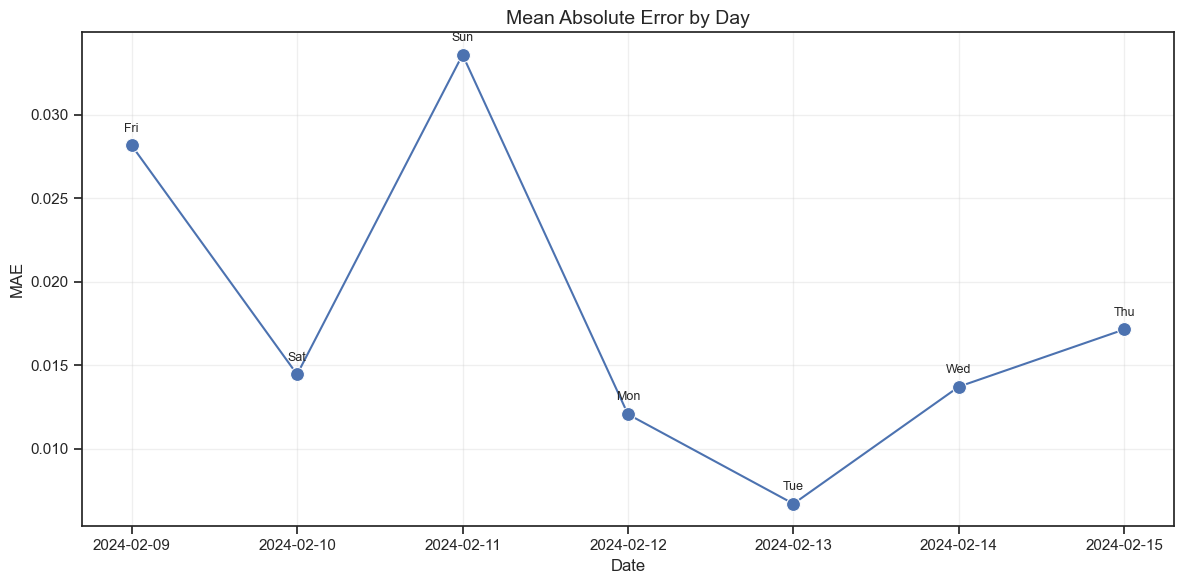


--- Weekend vs Weekday Performance ---
                 mae      rmse       mape
is_weekend                               
False       0.015561  0.061082  19.042932
True        0.024027  0.079712  17.797574


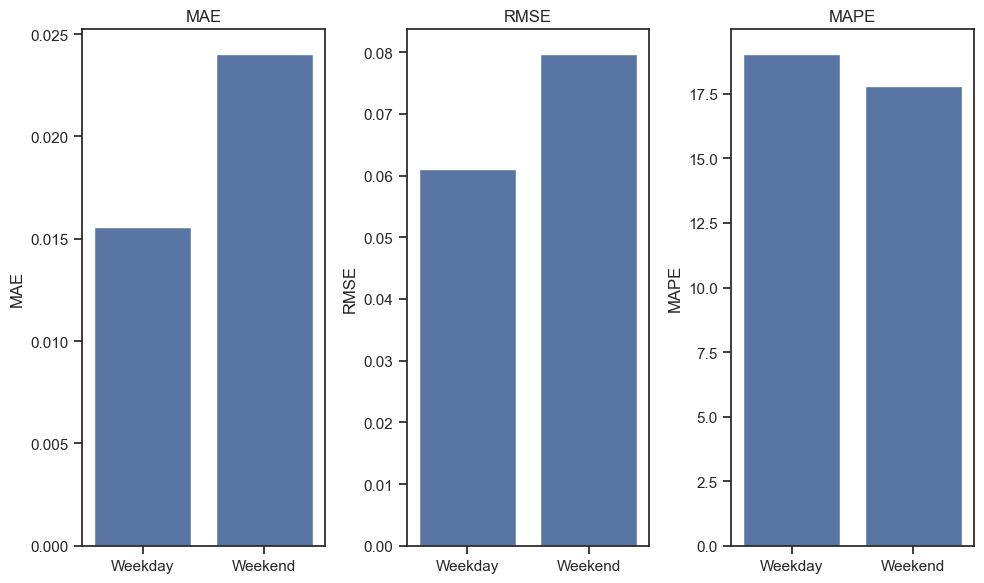


--- Error by Day of Week ---
                  mae     error       mape  count
day_of_week                                      
Monday       0.012064  0.000611   2.081993   7864
Tuesday      0.006701  0.003171   2.247891   7864
Wednesday    0.013720  0.006396   5.808299   7864
Thursday     0.017149 -0.005776  25.743038   7864
Friday       0.028172  0.024725  27.124198   7864
Saturday     0.014452  0.010356   3.725863   7864
Sunday       0.033602 -0.028301  19.327109   7864


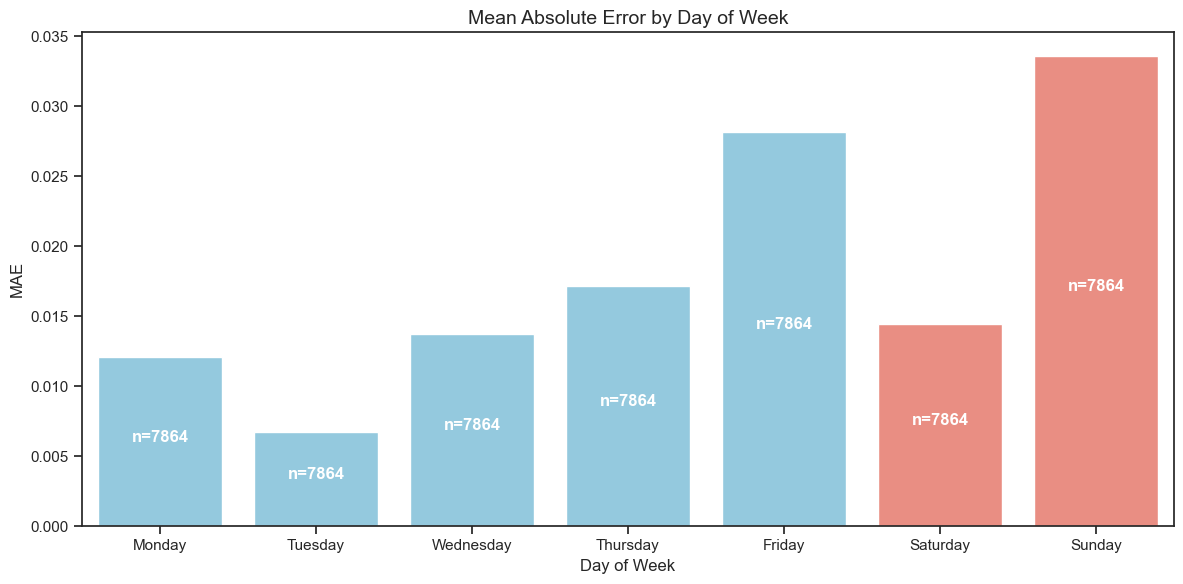

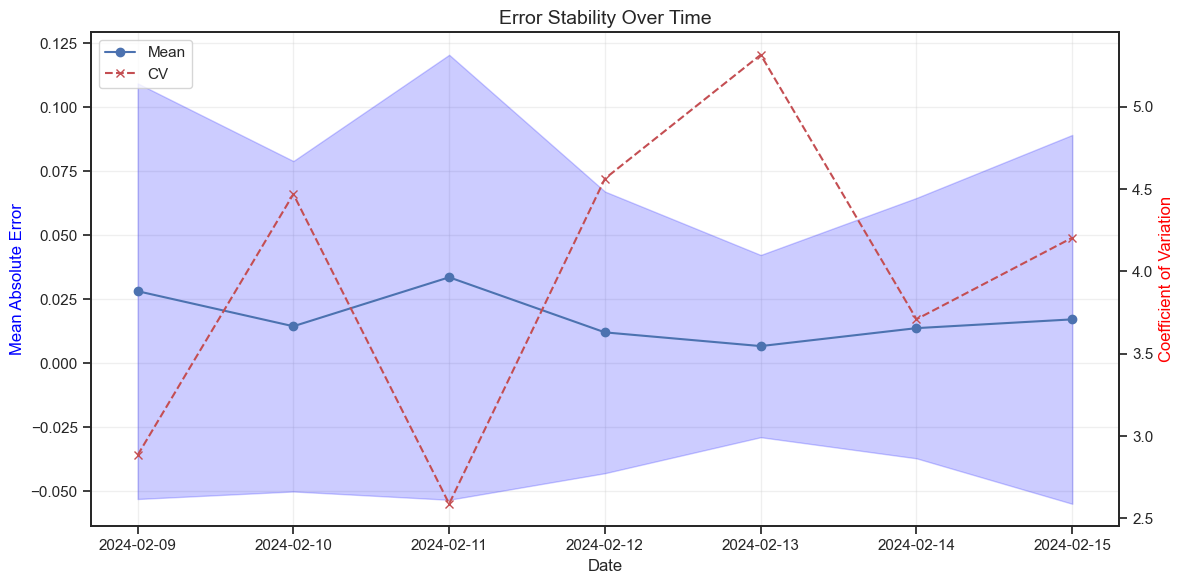


--- KEY TEMPORAL INSIGHTS ---
Weekend vs Weekday Difference: 54.40% higher error on weekends
Correlation between time and error: -0.0660
Best performing day: Tuesday (MAE = 0.0067)
Worst performing day: Sunday (MAE = 0.0336)
Average error volatility (CV): 3.9621


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

def run_simple_temporal_analysis(results_path, daily_metrics_path=None, output_dir=None):
    """
    Run a simple temporal analysis to understand how prediction errors vary over time
    
    Parameters:
    results_path: Path to naive baseline results CSV
    daily_metrics_path: Path to daily metrics CSV (if available)
    output_dir: Directory to save output visualizations
    """
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    print("Running simple temporal analysis...")
    
    # Load results data
    results_df = pd.read_csv(results_path)
    
    # Ensure date is in datetime format
    results_df['date'] = pd.to_datetime(results_df['date'])
    
    # Extract day of week
    results_df['day_of_week'] = results_df['date'].dt.day_name()
    results_df['is_weekend'] = results_df['day_of_week'].isin(['Saturday', 'Sunday'])
    
    # 1. Analyze daily metrics if available
    if daily_metrics_path and os.path.exists(daily_metrics_path):
        daily_df = pd.read_csv(daily_metrics_path)
        daily_df['date'] = pd.to_datetime(daily_df['date'])
        daily_df['day_of_week'] = daily_df['date'].dt.day_name()
        daily_df['is_weekend'] = daily_df['day_of_week'].isin(['Saturday', 'Sunday'])
        
        # Plot daily metrics
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='date', y='mae', data=daily_df, marker='o', markersize=10)
        plt.title('Mean Absolute Error by Day', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add day of week labels
        for i, row in daily_df.iterrows():
            plt.annotate(
                row['day_of_week'][:3],  # First 3 letters of day name
                (row['date'], row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'daily_mae_trend.png'), dpi=300)
        plt.show()
        
        # Compare weekend vs weekday performance
        weekend_stats = daily_df.groupby('is_weekend').agg({
            'mae': 'mean',
            'rmse': 'mean',
            'mape': 'mean'
        })
        
        print("\n--- Weekend vs Weekday Performance ---")
        print(weekend_stats)
        
        # Plot weekend vs weekday comparison
        plt.figure(figsize=(10, 6))
        metrics = ['mae', 'rmse', 'mape']
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.barplot(
                x=weekend_stats.index.map({True: 'Weekend', False: 'Weekday'}), 
                y=metric, 
                data=weekend_stats
            )
            plt.title(metric.upper())
            plt.xlabel('')
            plt.ylabel(metric.upper())
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'weekend_weekday_comparison.png'), dpi=300)
        plt.show()
    
    # 2. Analyze error patterns by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = results_df.groupby('day_of_week').agg({
        'abs_error': 'mean',
        'error': 'mean',
        'pct_error': 'mean',
        'listing_id': 'count'
    }).reindex(day_order).rename(columns={
        'abs_error': 'mae',
        'pct_error': 'mape',
        'listing_id': 'count'
    })
    
    print("\n--- Error by Day of Week ---")
    print(weekday_stats)
    
    # Plot error by day of week
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=weekday_stats.index, 
        y='mae', 
        data=weekday_stats,
        palette=['skyblue' if day not in ['Saturday', 'Sunday'] else 'salmon' for day in weekday_stats.index]
    )
    plt.title('Mean Absolute Error by Day of Week', fontsize=14)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    
    # Add count labels
    for i, count in enumerate(weekday_stats['count']):
        plt.text(
            i, 
            weekday_stats['mae'].iloc[i] / 2,
            f"n={count}",
            ha='center',
            color='white',
            fontweight='bold'
        )
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_by_day_of_week.png'), dpi=300)
    plt.show()
    
    # 3. Analyze error trends over prediction horizon
    if 'last_train_date' in results_df.columns:
        # Calculate days since last training point
        results_df['last_train_date'] = pd.to_datetime(results_df['last_train_date'])
        results_df['days_since_training'] = (results_df['date'] - results_df['last_train_date']).dt.days
        
        horizon_stats = results_df.groupby('days_since_training').agg({
            'abs_error': 'mean',
            'error': 'mean',
            'pct_error': 'mean',
            'listing_id': 'count'
        }).rename(columns={
            'abs_error': 'mae',
            'pct_error': 'mape',
            'listing_id': 'count'
        })
        
        print("\n--- Error by Prediction Horizon ---")
        print(horizon_stats)
        
        # Plot error by prediction horizon
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            x=horizon_stats.index, 
            y='mae', 
            data=horizon_stats,
            marker='o',
            markersize=10
        )
        plt.title('Mean Absolute Error by Prediction Horizon', fontsize=14)
        plt.xlabel('Days Since Last Training Point', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add count labels
        for i, row in horizon_stats.iterrows():
            plt.annotate(
                f"n={row['count']}",
                (i, row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'error_by_horizon.png'), dpi=300)
        plt.show()
    
    # 4. Analyze error stability over time
    # Group by date and calculate error statistics
    date_stats = results_df.groupby('date').agg({
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    date_stats.columns = ['_'.join(col).strip('_') for col in date_stats.columns.values]
    
    # Calculate coefficient of variation (measure of relative variability)
    date_stats['error_cv'] = date_stats['abs_error_std'] / date_stats['abs_error_mean']
    
    # Plot error stability
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot mean and std
    ax1.plot(date_stats.index, date_stats['abs_error_mean'], 'b-', marker='o', label='Mean')
    ax1.fill_between(
        date_stats.index,
        date_stats['abs_error_mean'] - date_stats['abs_error_std'],
        date_stats['abs_error_mean'] + date_stats['abs_error_std'],
        alpha=0.2,
        color='blue'
    )
    
    # Plot coefficient of variation
    ax2.plot(date_stats.index, date_stats['error_cv'], 'r--', marker='x', label='CV')
    
    # Add styling
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', color='blue', fontsize=12)
    ax2.set_ylabel('Coefficient of Variation', color='red', fontsize=12)
    plt.title('Error Stability Over Time', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_stability.png'), dpi=300)
    plt.show()
    
    # 5. Calculate key insights
    # Check for weekday-weekend difference
    weekend_mean = results_df[results_df['is_weekend']]['abs_error'].mean()
    weekday_mean = results_df[~results_df['is_weekend']]['abs_error'].mean()
    weekend_diff = ((weekend_mean - weekday_mean) / weekday_mean) * 100
    
    # Check for trend over time (correlation between date and error)
    date_nums = (results_df['date'] - results_df['date'].min()).dt.days
    time_corr = np.corrcoef(date_nums, results_df['abs_error'])[0, 1]
    
    # Print key insights
    print("\n--- KEY TEMPORAL INSIGHTS ---")
    print(f"Weekend vs Weekday Difference: {weekend_diff:.2f}% {'higher' if weekend_diff > 0 else 'lower'} error on weekends")
    print(f"Correlation between time and error: {time_corr:.4f}")
    
    # Identify best and worst days
    best_day = weekday_stats['mae'].idxmin()
    worst_day = weekday_stats['mae'].idxmax()
    print(f"Best performing day: {best_day} (MAE = {weekday_stats.loc[best_day, 'mae']:.4f})")
    print(f"Worst performing day: {worst_day} (MAE = {weekday_stats.loc[worst_day, 'mae']:.4f})")
    
    # Check error volatility
    cv_mean = date_stats['error_cv'].mean()
    print(f"Average error volatility (CV): {cv_mean:.4f}")
    
    if 'days_since_training' in results_df.columns:
        # Check if error grows with prediction horizon
        horizon_corr = np.corrcoef(
            results_df['days_since_training'], 
            results_df['abs_error']
        )[0, 1]
        print(f"Correlation between prediction horizon and error: {horizon_corr:.4f}")
    
    return {
        'weekday_stats': weekday_stats,
        'date_stats': date_stats,
        'weekend_diff': weekend_diff,
        'time_correlation': time_corr,
        'best_day': best_day,
        'worst_day': worst_day
    }

if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv"
    daily_metrics_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results_daily_metrics.csv"
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\Arima_temporal_error_analysis.csv"
    
    # Run analysis
    run_simple_temporal_analysis(results_path, daily_metrics_path, output_dir)
    

#### Price

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def run_temporal_price_analysis(results_path, output_dir):
    """
    Run temporal analysis focusing on predicted prices rather than errors
    
    Parameters:
    results_path: Path to naive baseline results CSV
    output_dir: Directory to save output visualizations
    """
    print("Running temporal analysis of predicted prices...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    
    # 2. Basic data preparation
    # Ensure date is in datetime format
    results_df['date'] = pd.to_datetime(results_df['date'])
    
    # Extract date components
    results_df['day_of_week'] = results_df['date'].dt.day_name()
    results_df['day_num'] = results_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    results_df['is_weekend'] = results_df['day_num'].isin([5, 6])  # Saturday and Sunday
    
    # 3. Analyze prices by day of week
    print("Analyzing prices by day of week...")
    
    # Set day of week order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    # Calculate daily price statistics
    day_stats = results_df.groupby('day_of_week').agg({
        'price': ['mean', 'median', 'std'],
        'predicted': ['mean', 'median', 'std'],
        'listing_id': 'count'
    }).reindex(day_order)
    
    # Flatten column names
    day_stats.columns = ['_'.join(col).strip('_') for col in day_stats.columns.values]
    day_stats = day_stats.rename(columns={'listing_id_count': 'count'})
    
    # Calculate daily price bias
    day_stats['price_diff'] = day_stats['predicted_mean'] - day_stats['price_mean']
    day_stats['price_diff_pct'] = (day_stats['price_diff'] / day_stats['price_mean']) * 100
    
    # 4. Analyze daily trending
    print("Analyzing daily price trends...")
    
    # Calculate daily average prices
    date_stats = results_df.groupby('date').agg({
        'price': ['mean', 'median', 'std'],
        'predicted': ['mean', 'median', 'std'],
        'listing_id': 'count'
    })
    
    # Flatten column names
    date_stats.columns = ['_'.join(col).strip('_') for col in date_stats.columns.values]
    date_stats = date_stats.rename(columns={'listing_id_count': 'count'})
    
    # Add day of week
    date_stats['day_of_week'] = date_stats.index.day_name()
    date_stats['is_weekend'] = date_stats.index.dayofweek.isin([5, 6])
    
    # Calculate daily bias
    date_stats['price_diff'] = date_stats['predicted_mean'] - date_stats['price_mean']
    date_stats['price_diff_pct'] = (date_stats['price_diff'] / date_stats['price_mean']) * 100
    
    # 5. Analyze weekend vs. weekday differences
    print("Analyzing weekend vs. weekday patterns...")
    
    weekend_stats = results_df.groupby('is_weekend').agg({
        'price': ['mean', 'median', 'std'],
        'predicted': ['mean', 'median', 'std'],
        'listing_id': 'count'
    })
    
    # Flatten column names
    weekend_stats.columns = ['_'.join(col).strip('_') for col in weekend_stats.columns.values]
    weekend_stats = weekend_stats.rename(columns={'listing_id_count': 'count'})
    
    # Calculate weekend premium (how much prices increase on weekends)
    if True in weekend_stats.index and False in weekend_stats.index:
        actual_weekend_premium = ((weekend_stats.loc[True, 'price_mean'] / weekend_stats.loc[False, 'price_mean']) - 1) * 100
        predicted_weekend_premium = ((weekend_stats.loc[True, 'predicted_mean'] / weekend_stats.loc[False, 'predicted_mean']) - 1) * 100
    else:
        actual_weekend_premium = np.nan
        predicted_weekend_premium = np.nan
    
    # 6. Create visualizations
    print("Creating visualizations...")
    
    # 6.1 Plot daily price patterns
    plot_daily_prices(day_stats, day_abbr, os.path.join(output_dir, 'daily_price_patterns.png'))
    
    # 6.2 Plot prices over time
    plot_price_trends(date_stats, os.path.join(output_dir, 'price_trends.png'))
    
    # 6.3 Plot weekend vs. weekday comparison
    plot_weekend_comparison(weekend_stats, os.path.join(output_dir, 'weekend_comparison.png'))
    
    # 6.4 Plot prediction bias by day of week
    plot_daily_bias(day_stats, day_abbr, os.path.join(output_dir, 'daily_prediction_bias.png'))
    
    # 6.5 Plot price distributions by day type
    plot_price_distributions(results_df, os.path.join(output_dir, 'price_distributions.png'))
    
    # 7. Print key insights
    print("\n--- KEY TEMPORAL INSIGHTS ---")
    
    # Overall price correlation
    price_corr = pearsonr(results_df['price'], results_df['predicted'])[0]
    print(f"Overall correlation between actual and predicted prices: {price_corr:.4f}")
    
    # Day of week patterns
    highest_day_actual = day_stats['price_mean'].idxmax()
    lowest_day_actual = day_stats['price_mean'].idxmin()
    highest_day_predicted = day_stats['predicted_mean'].idxmax()
    lowest_day_predicted = day_stats['predicted_mean'].idxmin()
    
    print("\nDay of week patterns:")
    print(f"Highest priced day (actual): {highest_day_actual}")
    print(f"Lowest priced day (actual): {lowest_day_actual}")
    print(f"Highest priced day (predicted): {highest_day_predicted}")
    print(f"Lowest priced day (predicted): {lowest_day_predicted}")
    
    # Weekend insights
    print("\nWeekend insights:")
    if not np.isnan(actual_weekend_premium):
        print(f"Actual weekend premium: {actual_weekend_premium:.2f}%")
        print(f"Predicted weekend premium: {predicted_weekend_premium:.2f}%")
        
        if abs(actual_weekend_premium - predicted_weekend_premium) > 5:
            print("Your model doesn't fully capture the weekend price differential")
        else:
            print("Your model captures the weekend price differential well")
    
    # Price variability capture
    actual_cv = results_df.groupby('day_of_week')['price'].std() / results_df.groupby('day_of_week')['price'].mean()
    predicted_cv = results_df.groupby('day_of_week')['predicted'].std() / results_df.groupby('day_of_week')['predicted'].mean()
    
    # Average CV difference
    cv_diff = (predicted_cv - actual_cv).mean()
    print(f"\nPrice variability capture: {cv_diff:.4f}")
    if cv_diff < -0.05:
        print("Your model underestimates daily price variability (predictions too uniform)")
    elif cv_diff > 0.05:
        print("Your model overestimates daily price variability (predictions too scattered)")
    else:
        print("Your model captures daily price variability well")
    
    # Most accurate/inaccurate days
    day_stats['accuracy'] = 100 - abs(day_stats['price_diff_pct'])
    most_accurate_day = day_stats['accuracy'].idxmax()
    least_accurate_day = day_stats['accuracy'].idxmin()
    
    print(f"\nMost accurately predicted day: {most_accurate_day}")
    print(f"Least accurately predicted day: {least_accurate_day}")
    
    # Save statistics to CSV
    day_stats.to_csv(os.path.join(output_dir, 'day_of_week_stats.csv'))
    date_stats.to_csv(os.path.join(output_dir, 'daily_stats.csv'))
    weekend_stats.to_csv(os.path.join(output_dir, 'weekend_stats.csv'))
    
    print(f"\nResults saved to {output_dir}")
    
    return {
        'day_stats': day_stats,
        'date_stats': date_stats,
        'weekend_stats': weekend_stats,
        'price_correlation': price_corr,
        'weekend_premium_actual': actual_weekend_premium,
        'weekend_premium_predicted': predicted_weekend_premium
    }

def plot_daily_prices(day_stats, day_abbr, output_path):
    """Plot actual and predicted prices by day of week"""
    plt.figure(figsize=(12, 8))
    
    # Create bars for actual and predicted prices
    x = np.arange(len(day_abbr))
    width = 0.35
    
    plt.bar(x - width/2, day_stats['price_mean'], width, label='Actual', color='blue', alpha=0.7)
    plt.bar(x + width/2, day_stats['predicted_mean'], width, label='Predicted', color='red', alpha=0.7)
    
    # Add error bars
    plt.errorbar(
        x - width/2, 
        day_stats['price_mean'], 
        yerr=day_stats['price_std'] / np.sqrt(day_stats['count']), 
        fmt='none', 
        color='blue', 
        alpha=0.5
    )
    plt.errorbar(
        x + width/2, 
        day_stats['predicted_mean'], 
        yerr=day_stats['predicted_std'] / np.sqrt(day_stats['count']), 
        fmt='none', 
        color='red', 
        alpha=0.5
    )
    
    # Add sample sizes
    for i, count in enumerate(day_stats['count']):
        plt.text(
            i, 
            min(day_stats['price_mean'].min(), day_stats['predicted_mean'].min()) / 2, 
            f'n={count}',
            ha='center',
            va='center',
            fontsize=9
        )
    
    # Add styling
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Average Price', fontsize=12)
    plt.title('Actual vs. Predicted Prices by Day of Week', fontsize=14)
    plt.xticks(x, day_abbr)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculate correlation
    corr = pearsonr(day_stats['price_mean'], day_stats['predicted_mean'])[0]
    plt.figtext(
        0.15, 0.9, 
        f"Day pattern correlation: {corr:.2f}",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_price_trends(date_stats, output_path):
    """Plot price trends over time"""
    plt.figure(figsize=(12, 8))
    
    # Create line plot for actual and predicted prices
    plt.plot(
        date_stats.index, 
        date_stats['price_mean'], 
        'o-', 
        color='blue', 
        label='Actual',
        alpha=0.7
    )
    plt.plot(
        date_stats.index, 
        date_stats['predicted_mean'], 
        'o-', 
        color='red', 
        label='Predicted',
        alpha=0.7
    )
    
    # Add confidence bands
    plt.fill_between(
        date_stats.index,
        date_stats['price_mean'] - date_stats['price_std'] / np.sqrt(date_stats['count']),
        date_stats['price_mean'] + date_stats['price_std'] / np.sqrt(date_stats['count']),
        color='blue',
        alpha=0.2
    )
    plt.fill_between(
        date_stats.index,
        date_stats['predicted_mean'] - date_stats['predicted_std'] / np.sqrt(date_stats['count']),
        date_stats['predicted_mean'] + date_stats['predicted_std'] / np.sqrt(date_stats['count']),
        color='red',
        alpha=0.2
    )
    
    # Add day of week labels
    for i, (idx, row) in enumerate(date_stats.iterrows()):
        plt.annotate(
            row['day_of_week'][:3],
            (idx, row['price_mean']),
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=9,
            ha='center'
        )
    
    # Highlight weekends
    for i, (idx, row) in enumerate(date_stats.iterrows()):
        if row['is_weekend']:
            plt.axvspan(
                idx - pd.Timedelta(hours=12), 
                idx + pd.Timedelta(hours=12), 
                alpha=0.1, 
                color='gray'
            )
    
    # Add styling
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Price', fontsize=12)
    plt.title('Actual vs. Predicted Price Trends Over Time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Calculate trend correlation
    corr = pearsonr(date_stats['price_mean'], date_stats['predicted_mean'])[0]
    plt.figtext(
        0.15, 0.9, 
        f"Trend correlation: {corr:.2f}",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_weekend_comparison(weekend_stats, output_path):
    """Plot comparison of weekend and weekday prices"""
    plt.figure(figsize=(10, 8))
    
    # Create bar chart
    index = ['Weekday', 'Weekend']
    x = np.arange(len(index))
    width = 0.35
    
    # Check if both weekend and weekday data exists
    if True in weekend_stats.index and False in weekend_stats.index:
        weekday_actual = weekend_stats.loc[False, 'price_mean']
        weekend_actual = weekend_stats.loc[True, 'price_mean']
        weekday_predicted = weekend_stats.loc[False, 'predicted_mean']
        weekend_predicted = weekend_stats.loc[True, 'predicted_mean']
        
        # Create bar chart
        plt.bar(x - width/2, [weekday_actual, weekend_actual], width, label='Actual', color='blue', alpha=0.7)
        plt.bar(x + width/2, [weekday_predicted, weekend_predicted], width, label='Predicted', color='red', alpha=0.7)
        
        # Add error bars
        plt.errorbar(
            x - width/2, 
            [weekday_actual, weekend_actual], 
            yerr=[weekend_stats.loc[False, 'price_std'] / np.sqrt(weekend_stats.loc[False, 'count']),
                 weekend_stats.loc[True, 'price_std'] / np.sqrt(weekend_stats.loc[True, 'count'])], 
            fmt='none', 
            color='blue', 
            alpha=0.5
        )
        plt.errorbar(
            x + width/2, 
            [weekday_predicted, weekend_predicted], 
            yerr=[weekend_stats.loc[False, 'predicted_std'] / np.sqrt(weekend_stats.loc[False, 'count']),
                 weekend_stats.loc[True, 'predicted_std'] / np.sqrt(weekend_stats.loc[True, 'count'])], 
            fmt='none', 
            color='red', 
            alpha=0.5
        )
        
        # Add percentage differences
        weekend_premium_actual = ((weekend_actual / weekday_actual) - 1) * 100
        weekend_premium_predicted = ((weekend_predicted / weekday_predicted) - 1) * 100
        
        plt.annotate(
            f"+{weekend_premium_actual:.1f}%",
            (x[1] - width/2, weekend_actual),
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10,
            ha='center'
        )
        plt.annotate(
            f"+{weekend_premium_predicted:.1f}%",
            (x[1] + width/2, weekend_predicted),
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10,
            ha='center'
        )
        
        # Add sample sizes
        for i, day_type in enumerate([False, True]):
            plt.text(
                i, 
                min(weekday_actual, weekend_actual, weekday_predicted, weekend_predicted) / 2, 
                f'n={weekend_stats.loc[day_type, "count"]}',
                ha='center',
                va='center',
                fontsize=9
            )
    
    # Add styling
    plt.xlabel('Day Type', fontsize=12)
    plt.ylabel('Average Price', fontsize=12)
    plt.title('Weekend vs. Weekday Price Comparison', fontsize=14)
    plt.xticks(x, index)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add key insight
    if True in weekend_stats.index and False in weekend_stats.index:
        diff = abs(weekend_premium_actual - weekend_premium_predicted)
        if diff < 2:
            insight = "Your model accurately captures the weekend price premium"
        elif diff < 5:
            insight = "Your model reasonably captures the weekend price premium"
        else:
            insight = "Your model doesn't fully capture the weekend price premium"
            
        plt.figtext(
            0.5, 0.01, 
            insight,
            fontsize=12,
            ha='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_daily_bias(day_stats, day_abbr, output_path):
    """Plot prediction bias by day of week"""
    plt.figure(figsize=(12, 8))
    
    # Create bars for prediction bias
    bias_values = day_stats['price_diff_pct'].values
    colors = ['red' if x > 0 else 'blue' for x in bias_values]  # Red for overestimation, blue for underestimation
    
    plt.bar(day_abbr, bias_values, color=colors, alpha=0.7)
    
    # Add zero line
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add styling
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Prediction Bias (%)', fontsize=12)
    plt.title('Price Prediction Bias by Day of Week', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add labels explaining colors
    plt.figtext(
        0.15, 0.9, 
        "Red = Overestimated\nBlue = Underestimated",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Annotate the values
    for i, bias in enumerate(bias_values):
        plt.annotate(
            f"{bias:.1f}%",
            (i, bias),
            xytext=(0, 5 if bias >= 0 else -15),
            textcoords='offset points',
            fontsize=9,
            ha='center'
        )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_price_distributions(results_df, output_path):
    """Plot price distributions for weekdays and weekends"""
    plt.figure(figsize=(12, 10))
    
    # Create a 2x2 grid
    gs = plt.GridSpec(2, 2)
    
    # Plot 1: Weekday distributions
    ax1 = plt.subplot(gs[0, 0])
    weekday_data = results_df[~results_df['is_weekend']]
    
    sns.histplot(
        weekday_data['price'],
        color='blue',
        alpha=0.5,
        label='Actual',
        kde=True,
        ax=ax1
    )
    sns.histplot(
        weekday_data['predicted'],
        color='red',
        alpha=0.5,
        label='Predicted',
        kde=True,
        ax=ax1
    )
    
    ax1.set_title('Weekday Price Distributions', fontsize=12)
    ax1.set_xlabel('Price', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.legend()
    
    # Plot 2: Weekend distributions
    ax2 = plt.subplot(gs[0, 1])
    weekend_data = results_df[results_df['is_weekend']]
    
    sns.histplot(
        weekend_data['price'],
        color='blue',
        alpha=0.5,
        label='Actual',
        kde=True,
        ax=ax2
    )
    sns.histplot(
        weekend_data['predicted'],
        color='red',
        alpha=0.5,
        label='Predicted',
        kde=True,
        ax=ax2
    )
    
    ax2.set_title('Weekend Price Distributions', fontsize=12)
    ax2.set_xlabel('Price', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.legend()
    
    # Plot 3: Scatter plot for weekdays
    ax3 = plt.subplot(gs[1, 0])
    
    ax3.scatter(
        weekday_data['price'],
        weekday_data['predicted'],
        alpha=0.3,
        s=10
    )
    
    # Add diagonal line
    lims = [
        min(weekday_data['price'].min(), weekday_data['predicted'].min()),
        max(weekday_data['price'].max(), weekday_data['predicted'].max())
    ]
    ax3.plot(lims, lims, 'r--', alpha=0.7)
    
    # Add correlation
    corr = pearsonr(weekday_data['price'], weekday_data['predicted'])[0]
    ax3.annotate(
        f"r = {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8)
    )
    
    ax3.set_title('Weekday: Actual vs. Predicted', fontsize=12)
    ax3.set_xlabel('Actual Price', fontsize=10)
    ax3.set_ylabel('Predicted Price', fontsize=10)
    
    # Plot 4: Scatter plot for weekends
    ax4 = plt.subplot(gs[1, 1])
    
    ax4.scatter(
        weekend_data['price'],
        weekend_data['predicted'],
        alpha=0.3,
        s=10
    )
    
    # Add diagonal line
    lims = [
        min(weekend_data['price'].min(), weekend_data['predicted'].min()),
        max(weekend_data['price'].max(), weekend_data['predicted'].max())
    ]
    ax4.plot(lims, lims, 'r--', alpha=0.7)
    
    # Add correlation
    corr = pearsonr(weekend_data['price'], weekend_data['predicted'])[0]
    ax4.annotate(
        f"r = {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8)
    )
    
    ax4.set_title('Weekend: Actual vs. Predicted', fontsize=12)
    ax4.set_xlabel('Actual Price', fontsize=10)
    ax4.set_ylabel('Predicted Price', fontsize=10)
    
    # Add overall title
    plt.suptitle('Price Distributions and Correlations: Weekdays vs. Weekends', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\arima_baseline_results.csv"
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\Arima_temporal_price_analysis"
    
    # Run analysis
    run_temporal_price_analysis(results_path, output_dir)

Running temporal analysis of predicted prices...
Loading data...
Analyzing prices by day of week...
Analyzing daily price trends...
Analyzing weekend vs. weekday patterns...
Creating visualizations...

--- KEY TEMPORAL INSIGHTS ---
Overall correlation between actual and predicted prices: 0.9971

Day of week patterns:
Highest priced day (actual): Saturday
Lowest priced day (actual): Sunday
Highest priced day (predicted): Sunday
Lowest priced day (predicted): Friday

Weekend insights:
Actual weekend premium: -18.38%
Predicted weekend premium: -50.56%
Your model doesn't fully capture the weekend price differential

Price variability capture: 0.7505
Your model overestimates daily price variability (predictions too scattered)

Most accurately predicted day: Monday
Least accurately predicted day: Friday

Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\Arima_temporal_price_analysis
